In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

# 3. Prediction of EV and ICE purchase in the next 5 years.

In [2]:
data = pd.read_csv(r"C:\Users\harri\Desktop\DataScienceProj\005_CarPurchase\EVnICE.csv")

In [3]:
data.head(10)

Unnamed: 0  year carType
0           0  2011     ICE
1           1  2011     ICE
2           2  2011     ICE
3           3  2011     ICE
4           4  2011     ICE
5           5  2011     ICE
6           6  2011     ICE
7           7  2011     ICE
8           8  2011     ICE
9           9  2011     ICE

In [4]:
data.drop('Unnamed: 0', inplace=True, axis=1)

In [5]:
data["year"].value_counts()

2020    4252
2013    4238
2016    4235
2018    4201
2017    4198
2019    4191
2012    4180
2015    4179
2021    4153
2014    4149
2011    4095
Name: year, dtype: int64

In [6]:
data.head()

year carType
0  2011     ICE
1  2011     ICE
2  2011     ICE
3  2011     ICE
4  2011     ICE

In [7]:
data.groupby(["year"], as_index=False).count()

year  carType
0   2011     4095
1   2012     4180
2   2013     4238
3   2014     4149
4   2015     4179
5   2016     4235
6   2017     4198
7   2018     4201
8   2019     4191
9   2020     4252
10  2021     4153

# **ICE**

In [8]:
ice = data.query('carType == "ICE"').groupby(["year"], as_index=False).count()
ice.rename(columns={"carType": "count"}, inplace=True)
ice


year  count
0   2011   4092
1   2012   4170
2   2013   4217
3   2014   4098
4   2015   4126
5   2016   4164
6   2017   4139
7   2018   4149
8   2019   4093
9   2020   4142
10  2021   4020

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='count'>)

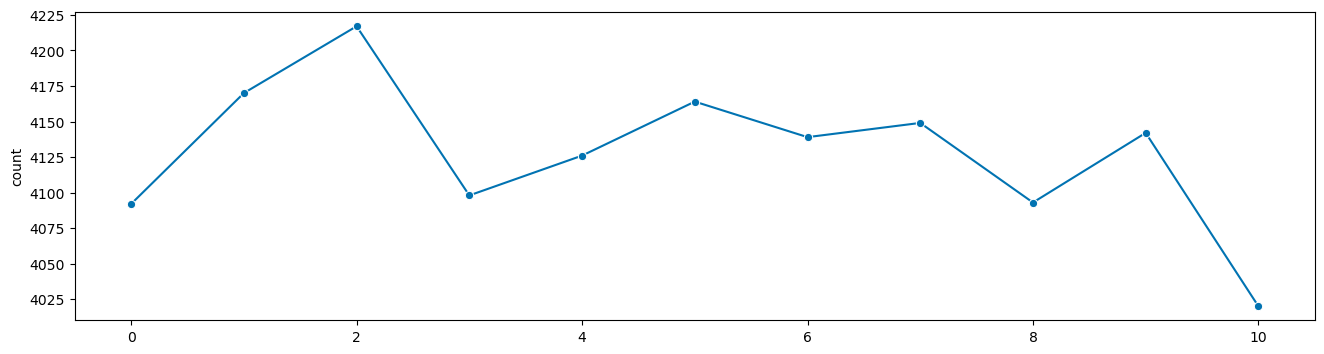

In [9]:
plot_series(ice["count"])

From the graph, it does not have seasonal component and trend shows a decreasing pattern (but not significant). Also, it is not stationary which is not suitable to be used for forecasting algoritm. Later, I apply a method to preserve the stationary feature from time series.

## TIME FEATURE

C:\Users\harri\AppData\Local\Temp\ipykernel_26344\473529809.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


Text(0.5, 1.0, 'Time Plot of ICE Car Sales')

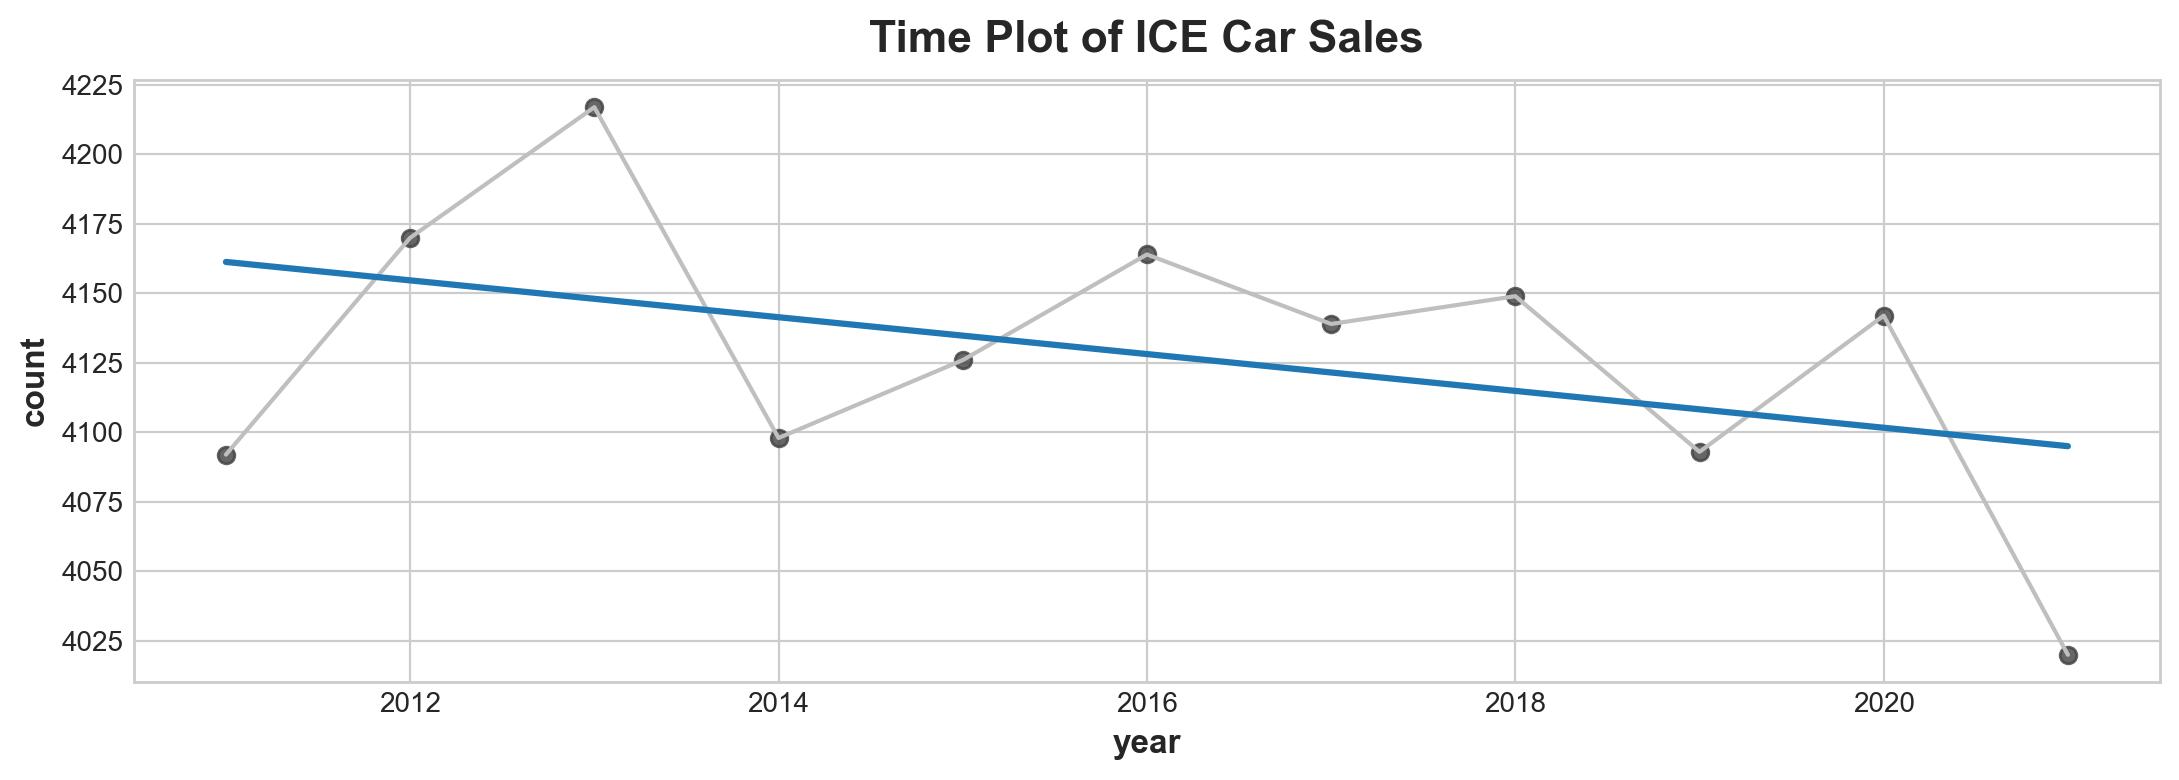

In [10]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('year', 'count', data=ice, color='0.75')
ax = sns.regplot(x='year', y='count', data=ice, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of ICE Car Sales')

In [11]:
print("Range of ICE is (" + str(ice["count"].min()) + "," + str(ice["count"].max()) + ")")

Range of ICE is (4020,4217)


## LAG Feature

In [12]:
ice_copy1 = ice.copy()


ice_copy1['Lag_1'] = ice_copy1['count'].shift(1)
df = ice_copy1.reindex(columns=['count', 'Lag_1'])

df.head()

count   Lag_1
0   4092     NaN
1   4170  4092.0
2   4217  4170.0
3   4098  4217.0
4   4126  4098.0

In [13]:
ice_copy1.head()

year  count   Lag_1
0  2011   4092     NaN
1  2012   4170  4092.0
2  2013   4217  4170.0
3  2014   4098  4217.0
4  2015   4126  4098.0

Text(0.5, 1.0, 'Lag Plot of ICE Car Sales')

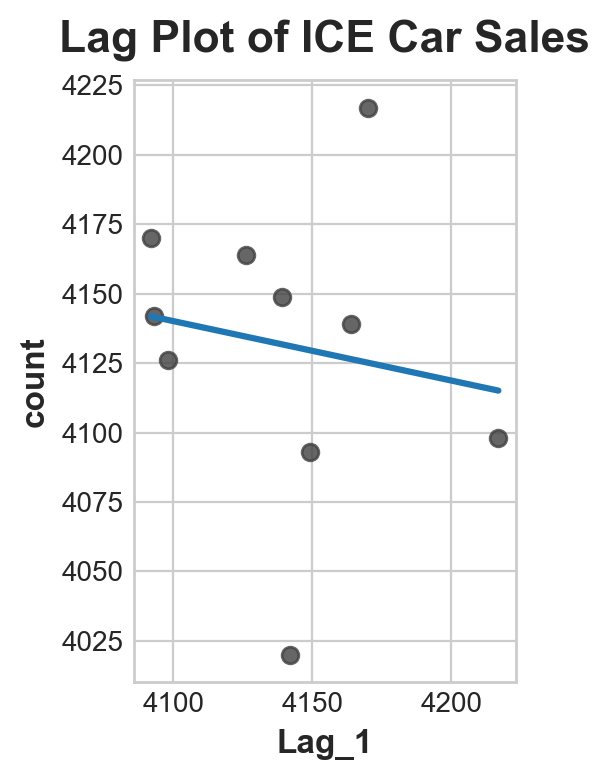

In [14]:
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='count', data=ice_copy1, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of ICE Car Sales')

From the lag plot, ice car purchase sale does not show a significant correlation with previous year (lag_1) because it shows slight decrease on previous year may contribute small effect on the next year purchase

https://www.kaggle.com/code/ryanholbrook/linear-regression-with-time-series

## ARIMA


In [17]:
from sktime.forecasting.arima import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.api import (kpss, adfuller,seasonal_decompose, STL)
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
from pathlib import Path
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 5]

In [18]:
ice_copy2 = ice.copy()

In [21]:
def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
    print(f"'{s}\t p-value:{results[0]} \tlags:{results[1]}")
    return (s, results[0])

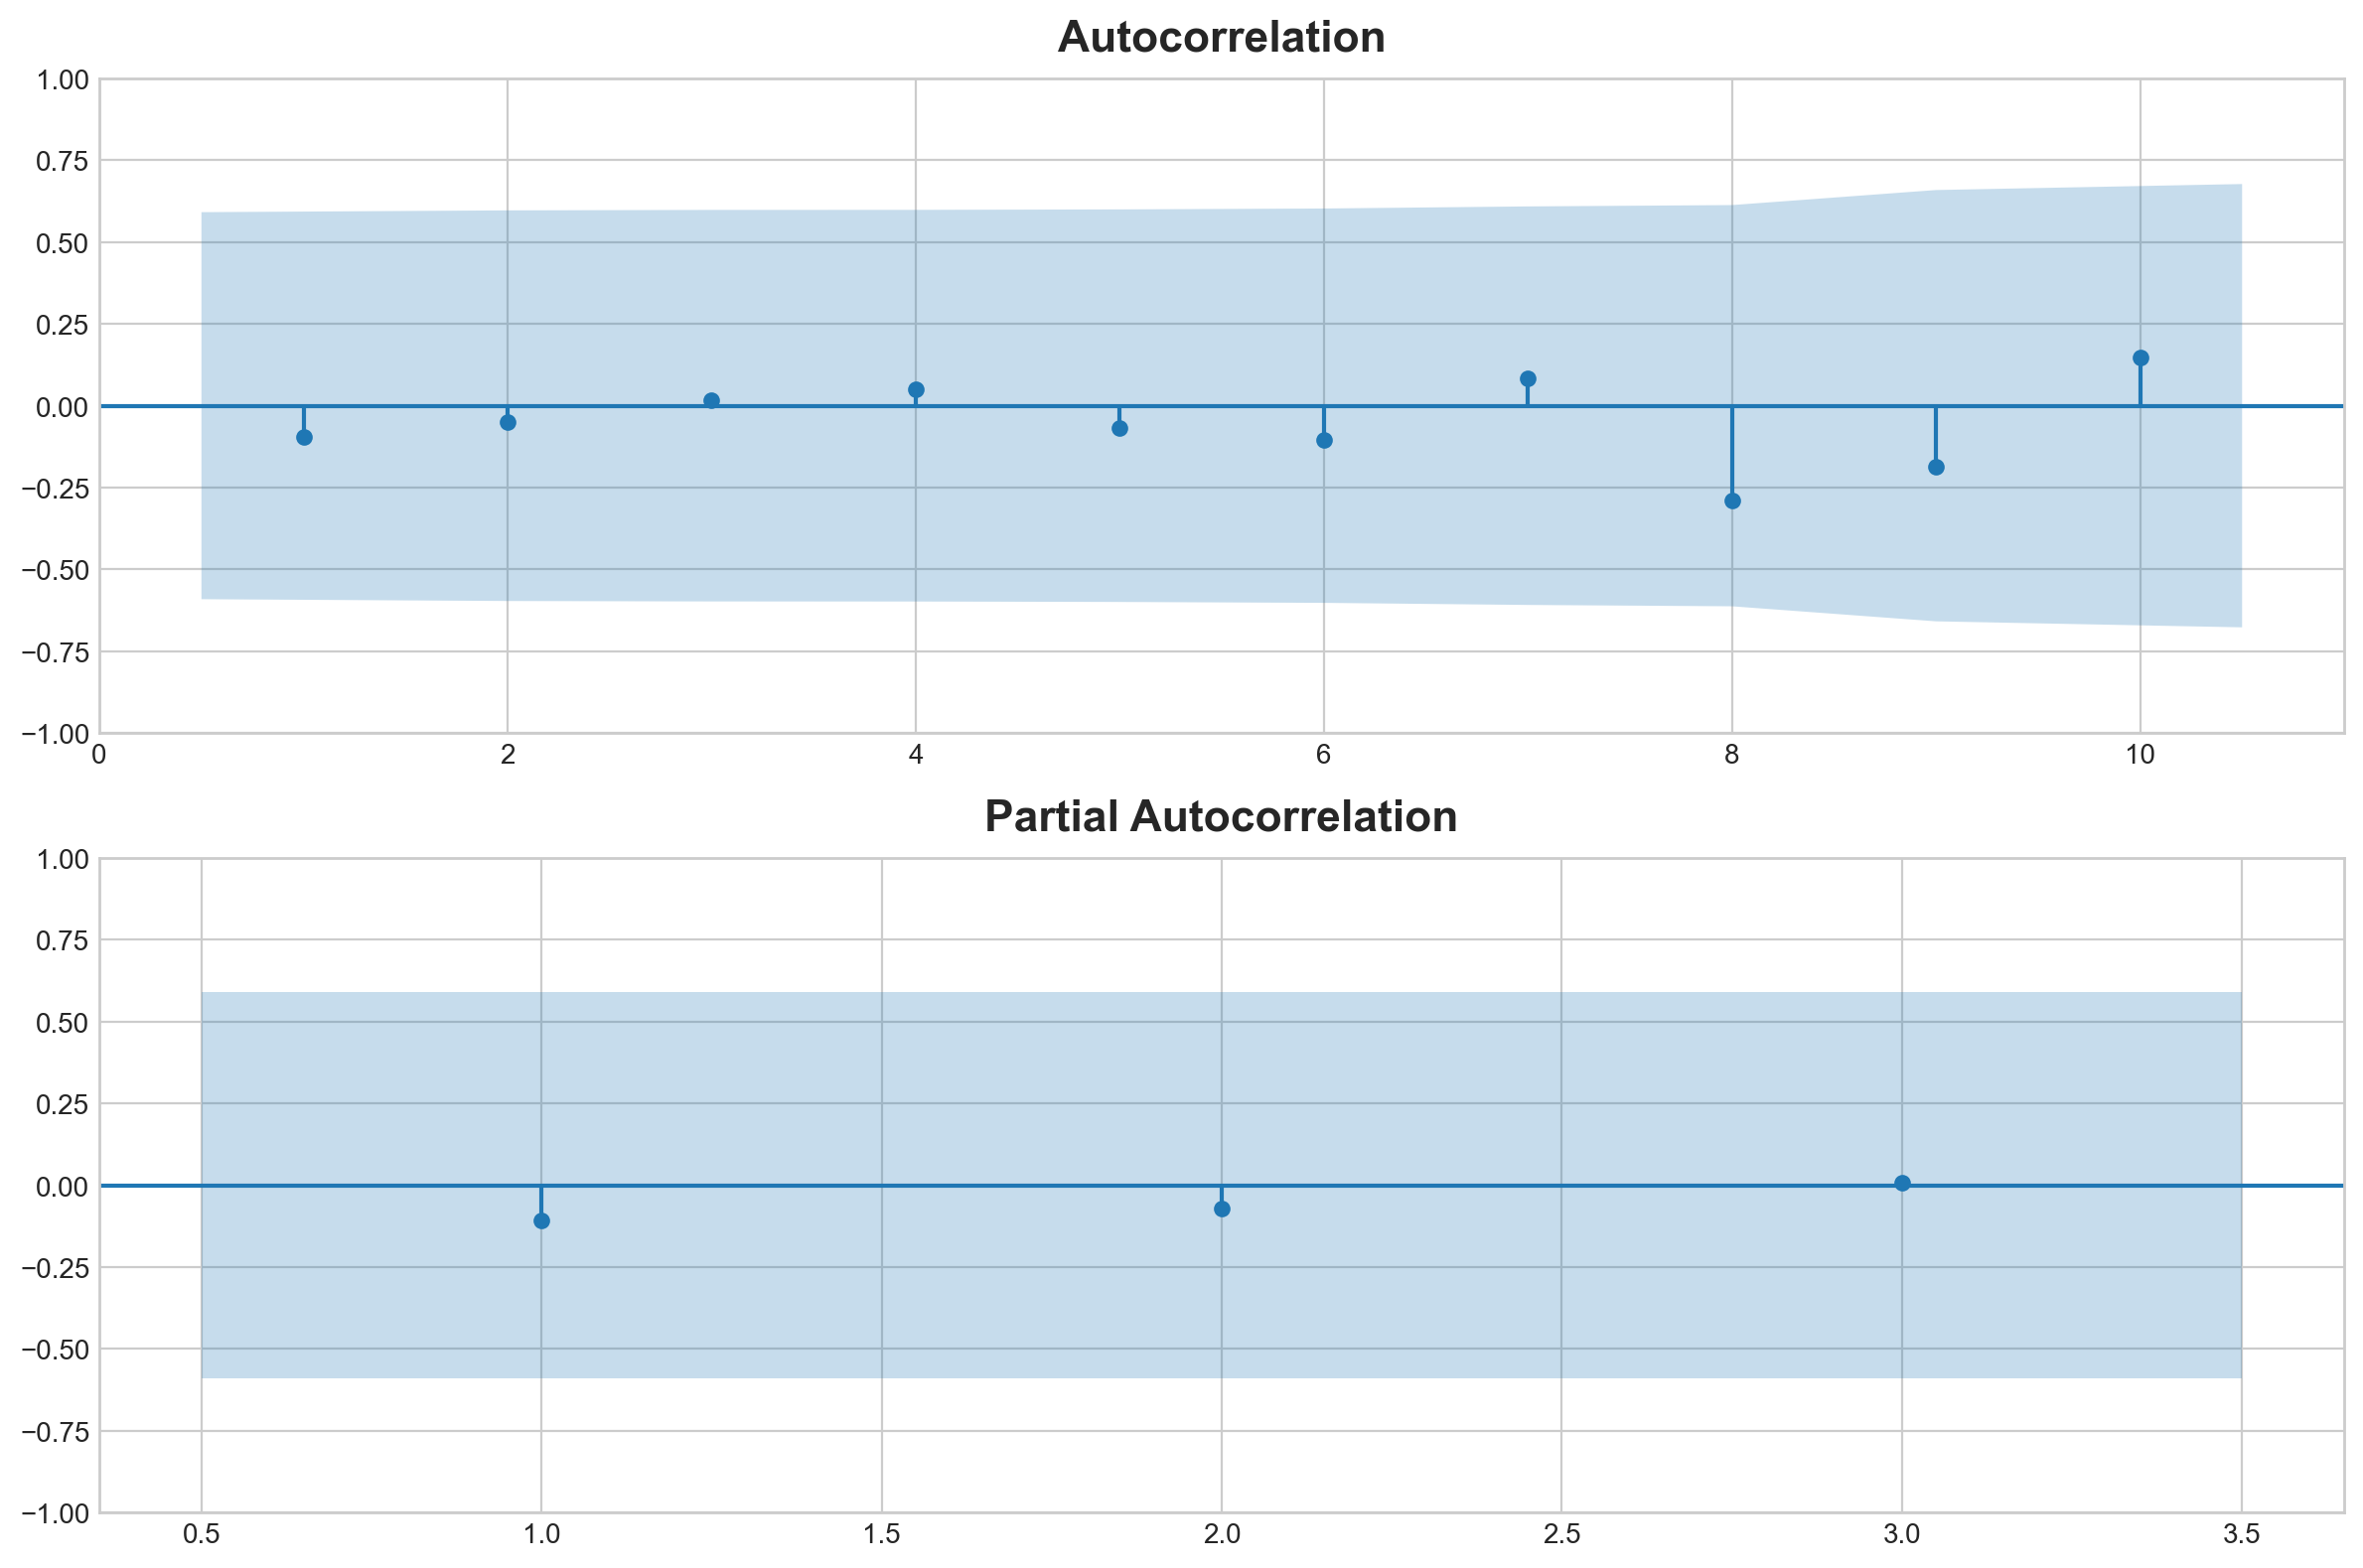

'Non-Stationary	 p-value:0.09764048503765743 	lags:0


('Non-Stationary', 0.09764048503765743)

In [22]:
ice_diff = ice.diff().dropna()
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(ice_copy2["count"], zero=False, ax=ax[0])
plot_pacf(ice_copy2["count"], zero=False, lags=3,ax=ax[1])
plt.show()

check_stationarity(ice_copy2["count"])

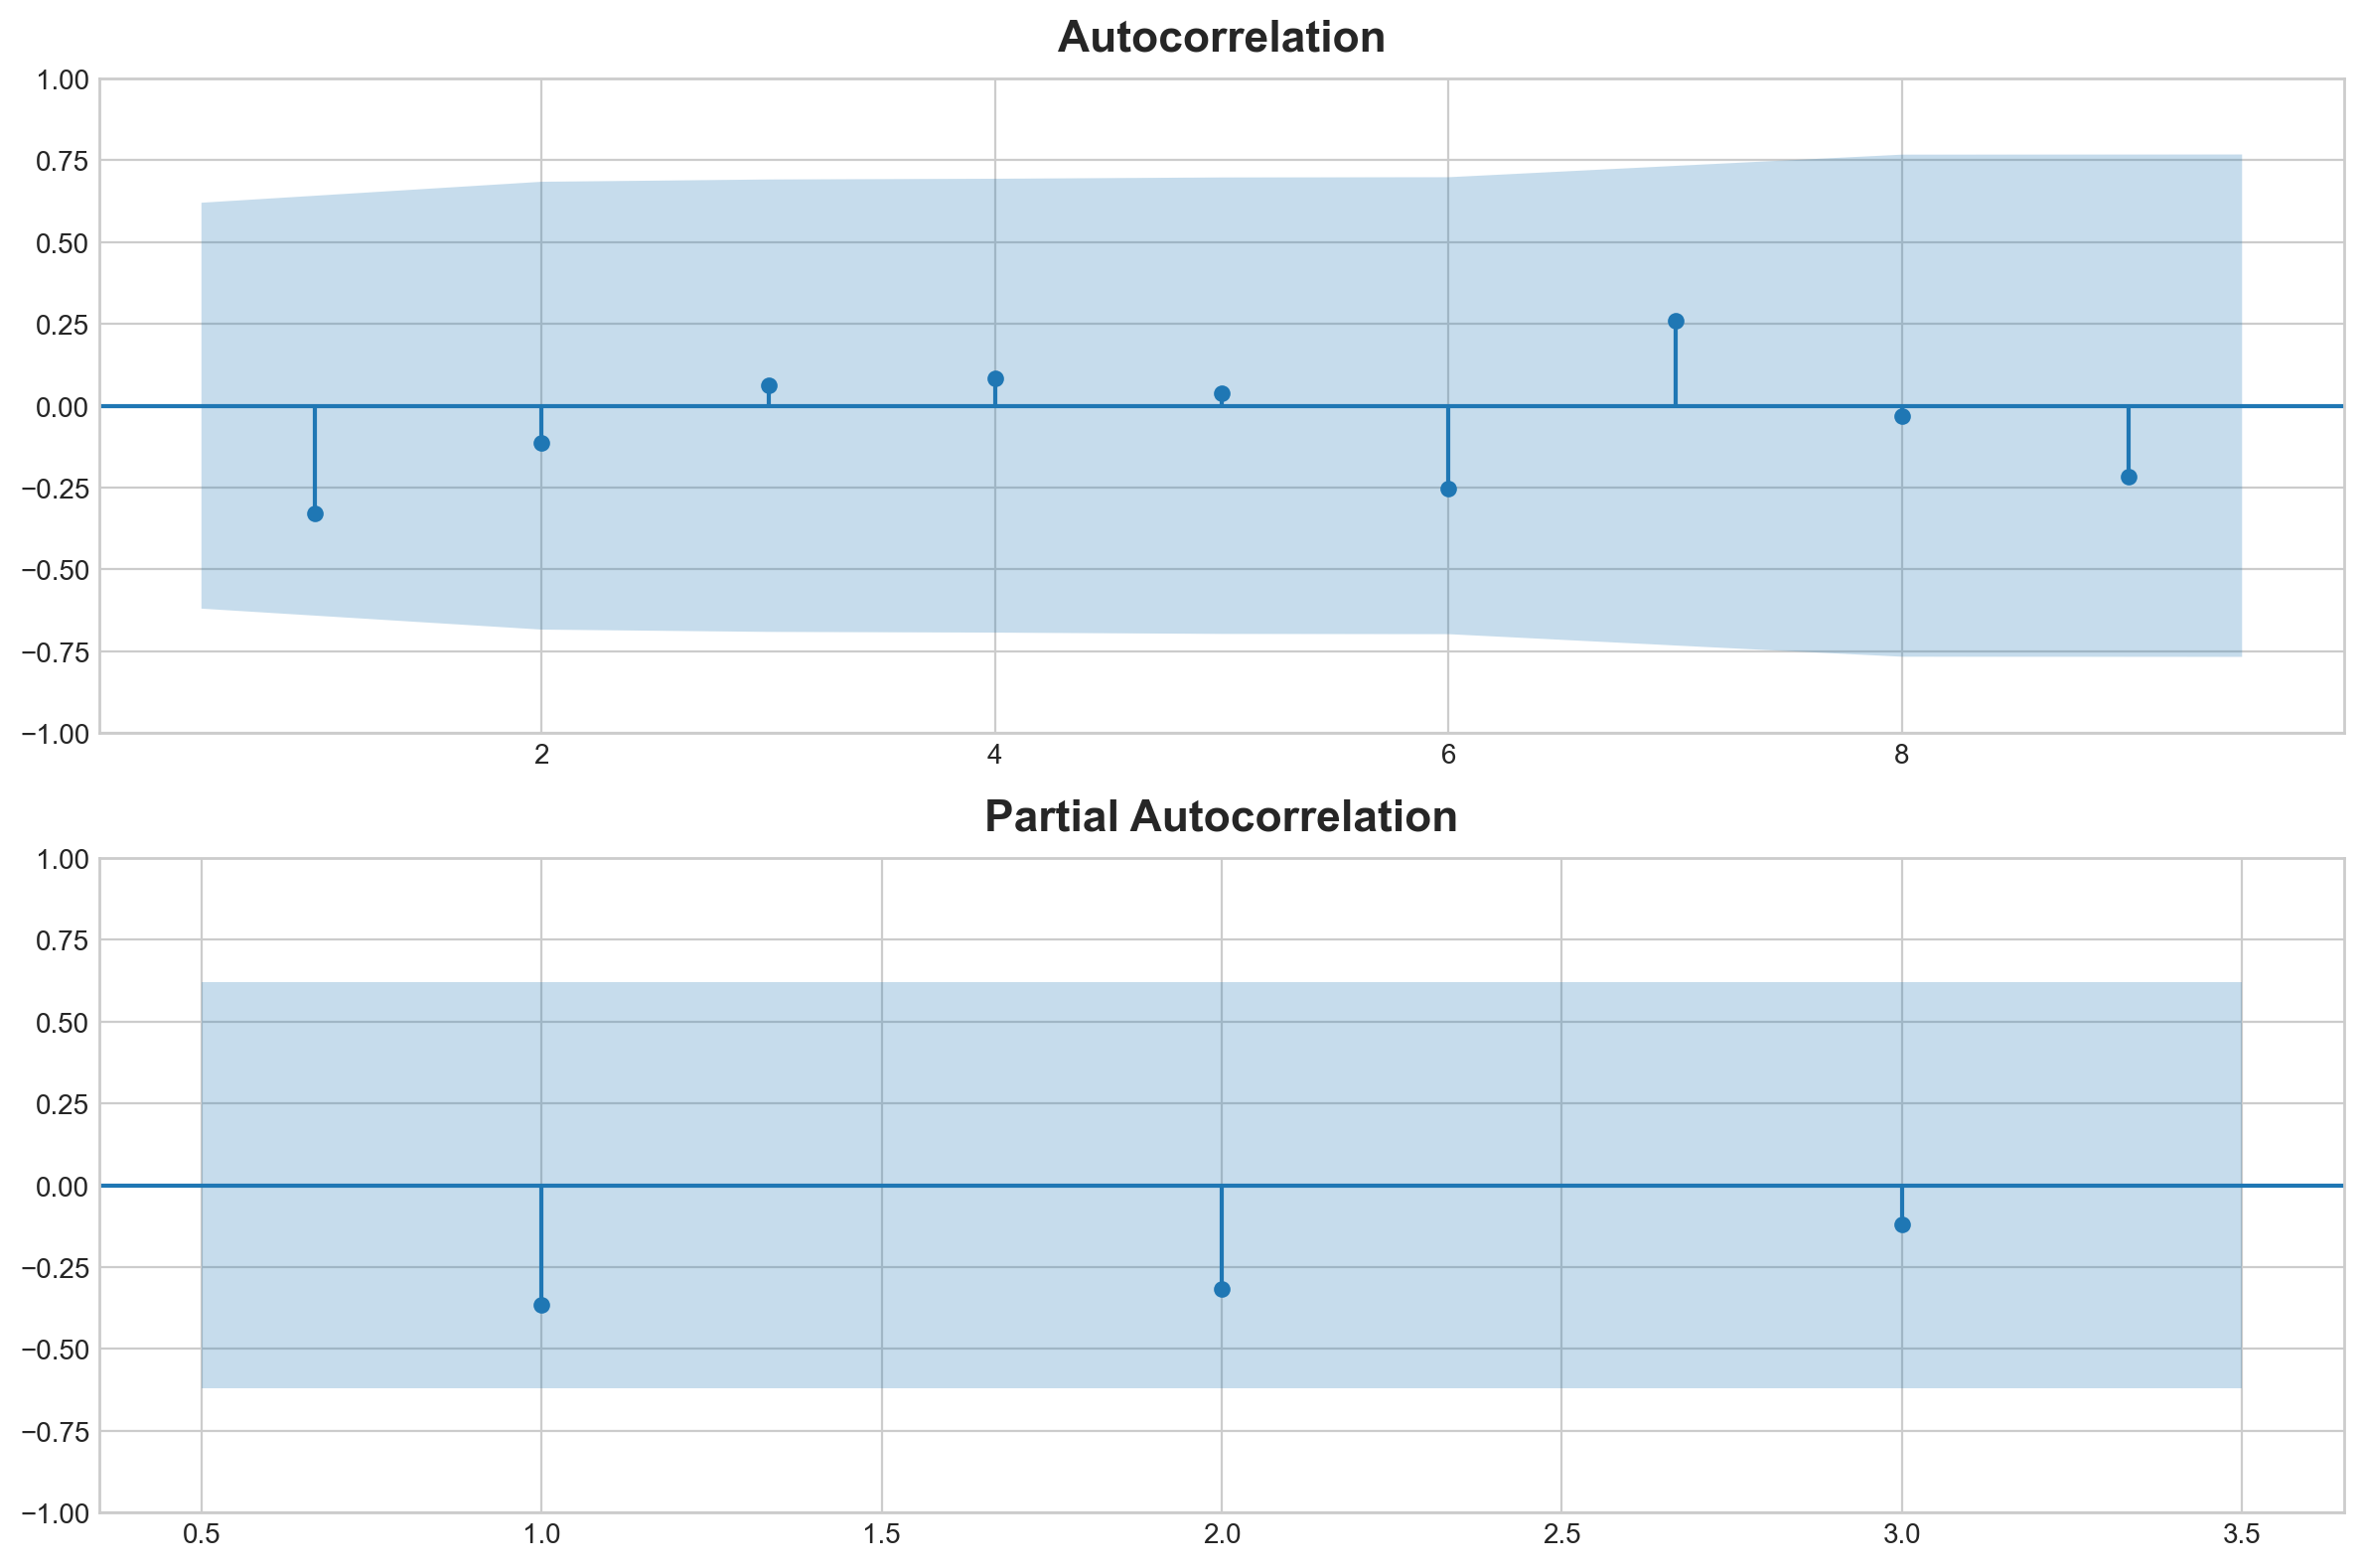

'Stationary	 p-value:0.0027117741254559136 	lags:0


('Stationary', 0.0027117741254559136)

In [23]:
#1st order
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(ice_copy2["count"].diff().dropna(), zero=False, ax=ax[0])
plot_pacf(ice_copy2["count"].diff().dropna(), zero=False, lags=3,ax=ax[1])
plt.show()

check_stationarity(ice_copy2["count"].diff().dropna())

In [29]:
ice_copy2 = ice_copy2.set_index("year")
ice_copy2

count
year       
2011   4092
2012   4170
2013   4217
2014   4098
2015   4126
2016   4164
2017   4139
2018   4149
2019   4093
2020   4142
2021   4020

In [30]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
y_train, y_test = temporal_train_test_split(ice_copy2, test_size=2)
fh = ForecastingHorizon(y_test.index, is_relative=False)

In [35]:
fh

ForecastingHorizon([2020, 2021], dtype='int64', name='year', is_relative=False)

0.01471184025021834

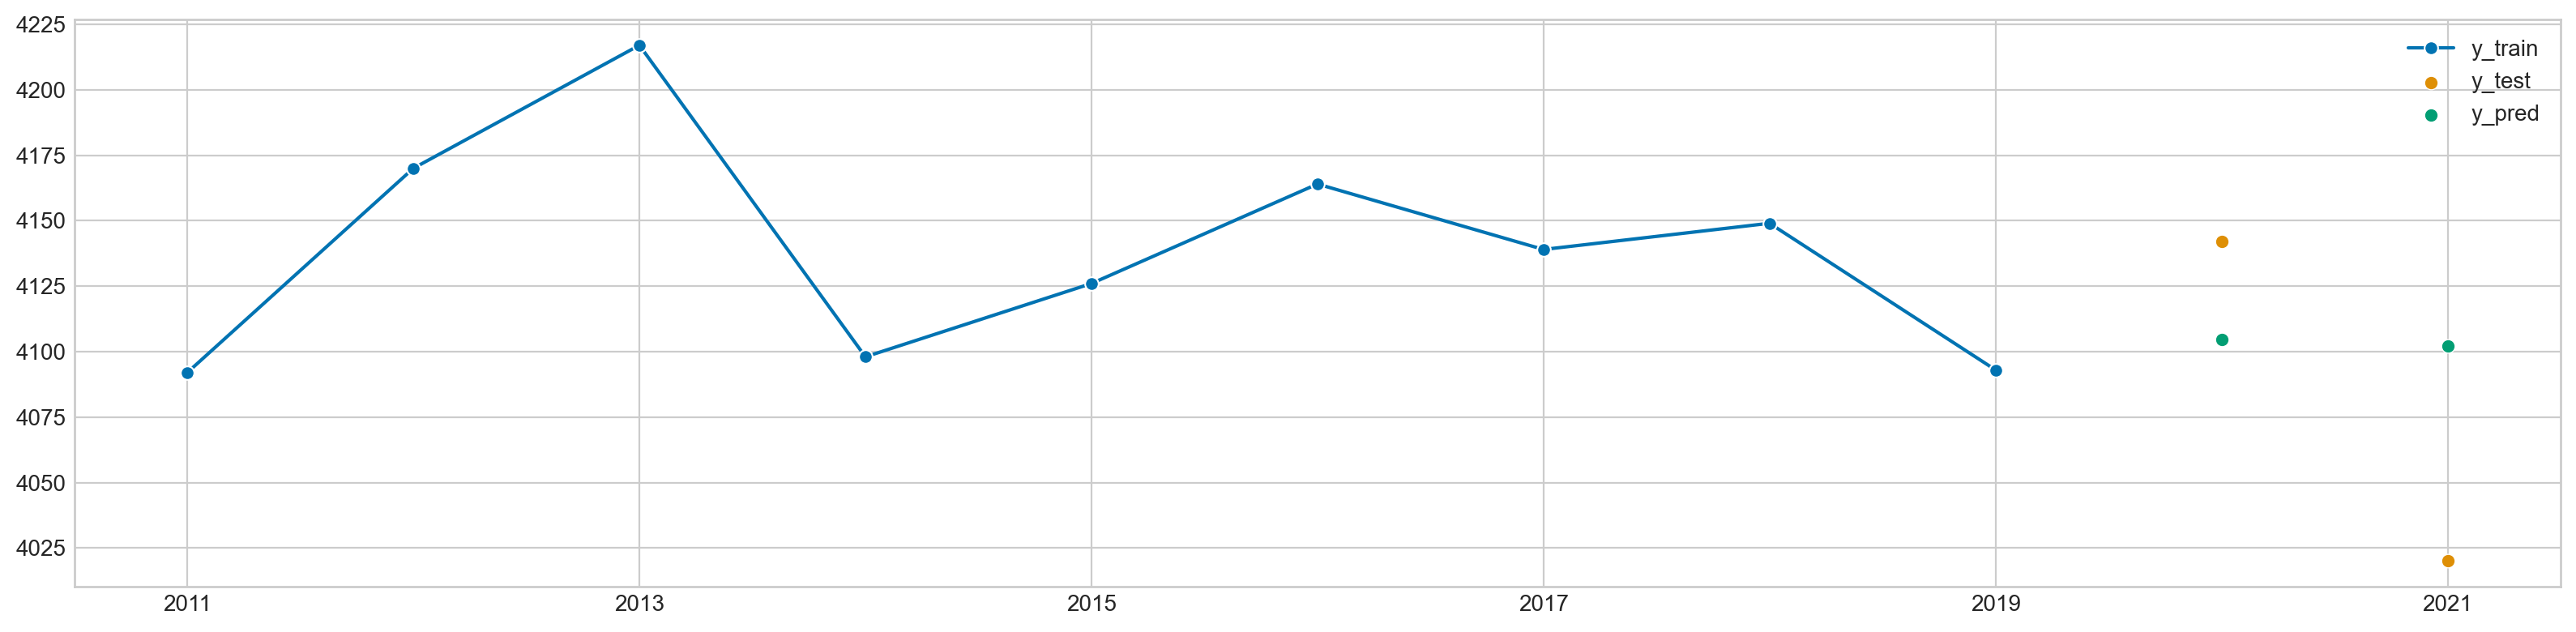

In [31]:
forecaster = ARIMA(order=(1, 1, 0),  suppress_warnings=True)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In [34]:
y_pred

count
2020  4104.741579
2021  4102.122198

In [36]:
y_eval = pd.DataFrame({"year":[2022,2023,2024,2025,2026], "count":[0,0,0,0,0]})

In [38]:
y_eval = y_eval.set_index("year")
y_eval

count
year       
2022      0
2023      0
2024      0
2025      0
2026      0

In [39]:
new_fh = ForecastingHorizon(y_eval.index, is_relative=False)

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: >)

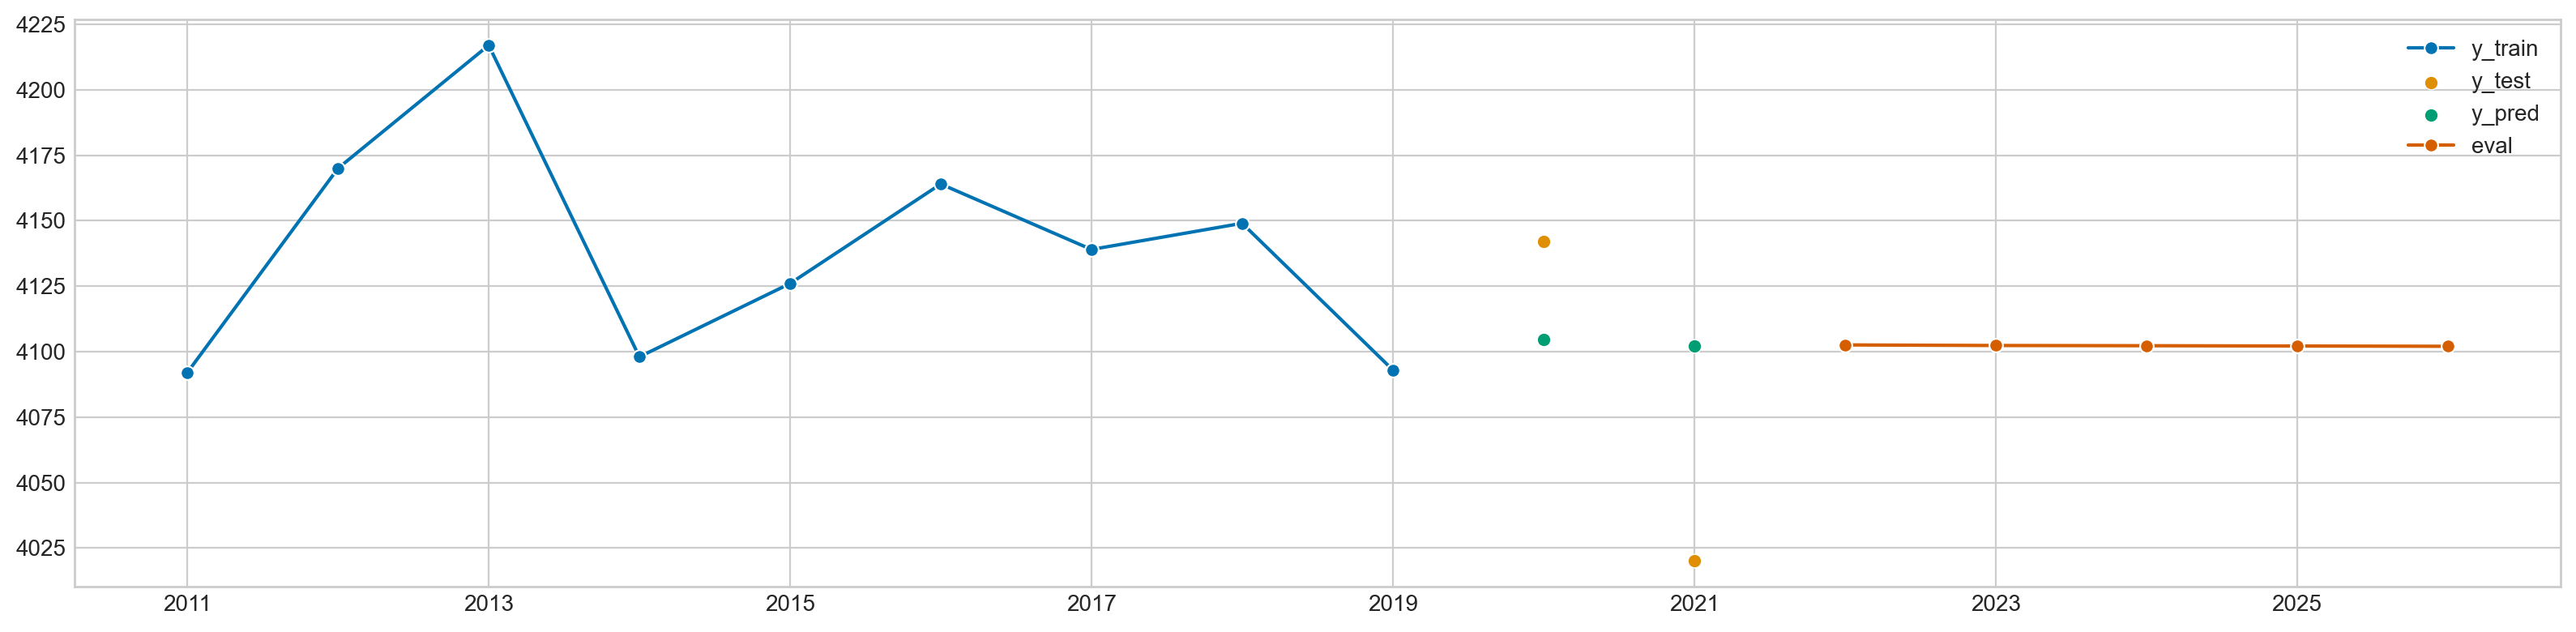

In [40]:

y_pred_eval = forecaster.predict(new_fh)
plot_series(y_train, y_test, y_pred,y_pred_eval,  labels=["y_train", "y_test", "y_pred", "eval"])


## Exponential Smoothing

In [42]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

0.01480755725981334

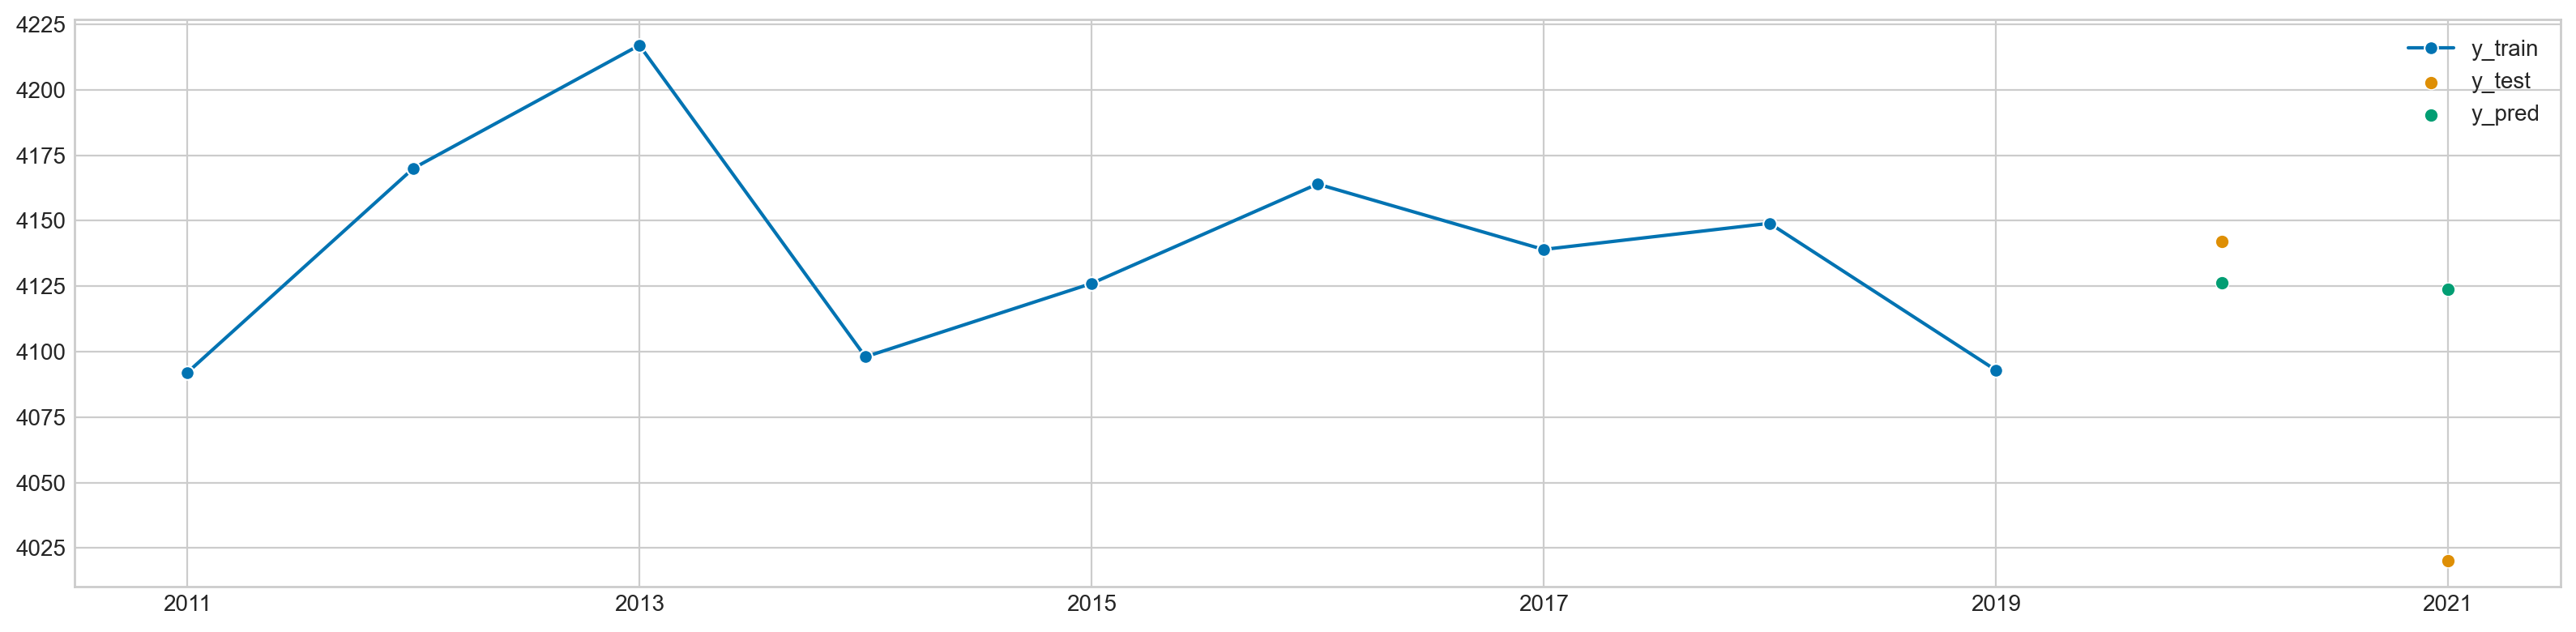

In [43]:
forecaster = ExponentialSmoothing(trend="add")

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: >)

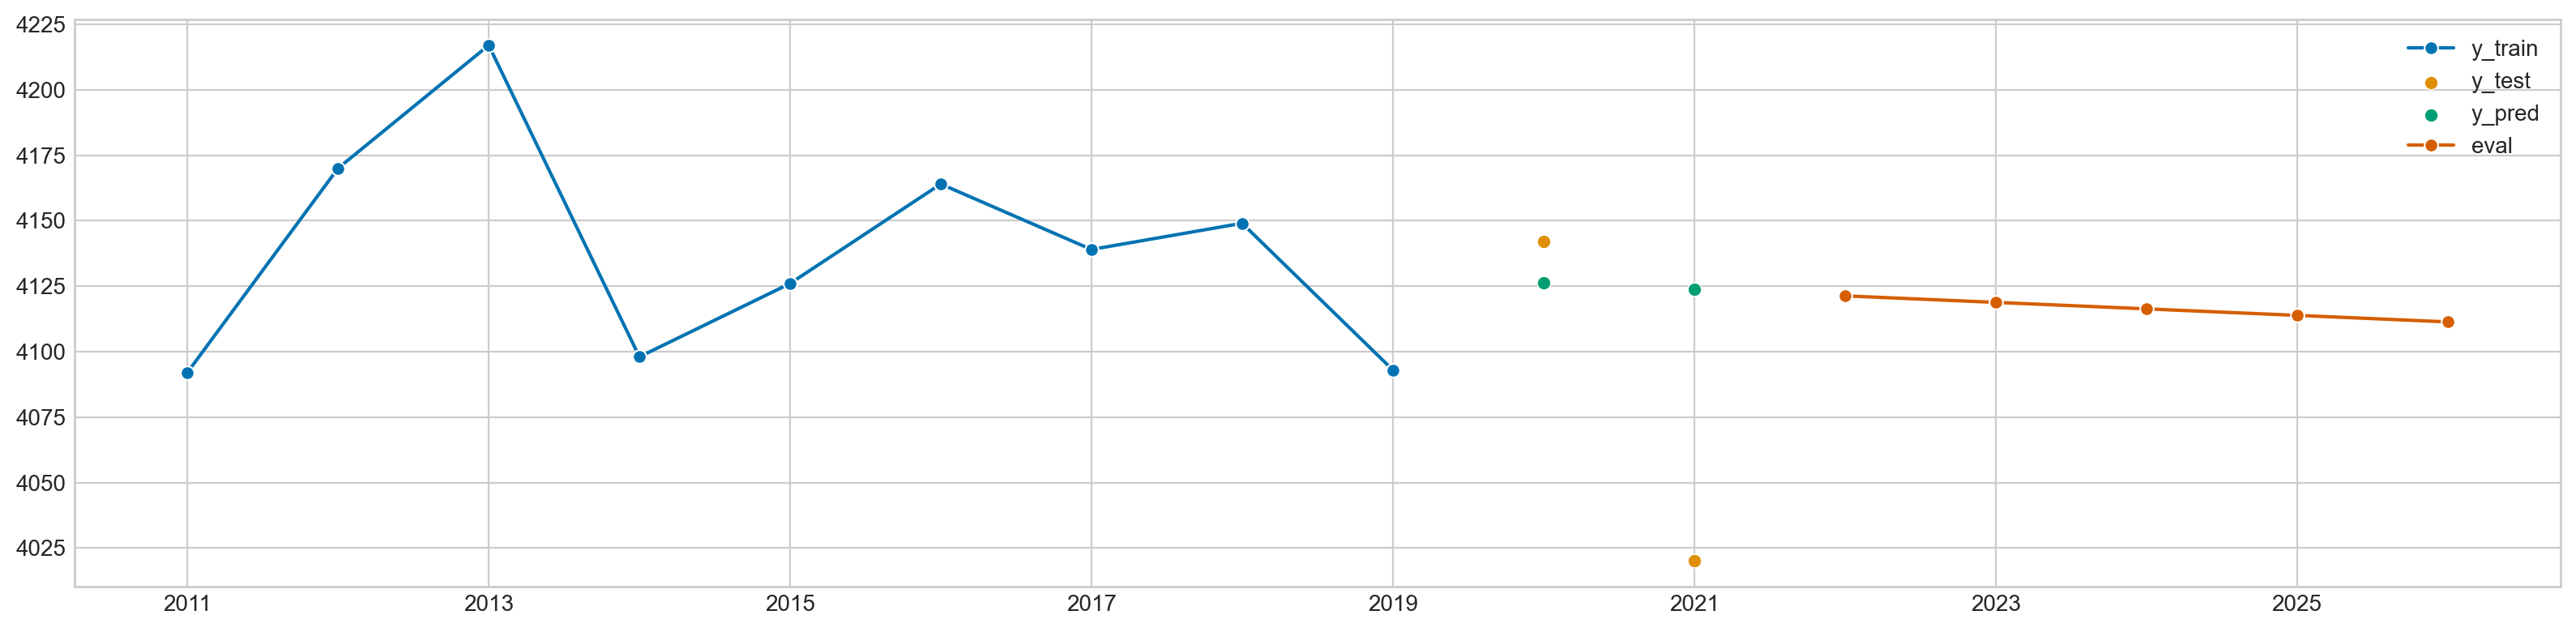

In [44]:

y_pred_eval = forecaster.predict(new_fh)
plot_series(y_train, y_test, y_pred,y_pred_eval,  labels=["y_train", "y_test", "y_pred", "eval"])


MACHINE LEARNING

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [45]:
ice

year  count
0   2011   4092
1   2012   4170
2   2013   4217
3   2014   4098
4   2015   4126
5   2016   4164
6   2017   4139
7   2018   4149
8   2019   4093
9   2020   4142
10  2021   4020

In [46]:
ice_cop3 = ice.copy()

In [47]:
def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()

In [48]:
def split_data(df, test_split=0.25):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test

In [49]:
class Standardize:
    def __init__(self, split=0.15):
        self.split = split
    
    def _transform(self, df):
        return (df - self.mu)/self.sigma
    
    def split_data(self, df):
        n = int(len(df) * test_split)
        train, test = df[:-n], df[-n:]
        return train, test
    
    def fit_transform(self, train, test):
        self.mu = train.mean()
        self.sigma = train.std()
        train_s = self._transform(train)
        test_s =  self._transform(test)
        return train_s, test_s

    def transform(self, df):
        return self._transform(df)
    
    def inverse(self, df):
        return (df * self.sigma)+self.mu
        
    def inverse_y(self, df):
        return (df * self.sigma[0])+self.mu[0]

In [50]:
def train_model(train, test, regressor, reg_name):
    X_train, y_train  = train.drop(columns=['y']), train['y']
    X_test, y_test  = test.drop(columns=['y']), test['y']   

    print(f'training {reg_name} ...')
    
    regressor.fit(X_train, y_train) 
     
    yhat = regressor.predict(X_test)    
    rmse_test = np.sqrt(mse(y_test, yhat))
    mape_test = mape(y_test, yhat)
    mase_test = mase(y_test, yhat, y_train=y_train)    
    residuals = y_test.values - yhat     
    
    model_metadata = {
        'Model Name': reg_name, 'Model': regressor, 
        'RMSE': rmse_test, 'MAPE': mape_test, 'MASE': mase_test,
        'yhat': yhat, 'resid': residuals, 'actual': y_test.values}

    return model_metadata

In [51]:
def train_different_models(train, test, regressors):
    results = []
    for reg_name, regressor in regressors.items():
        results.append(train_model(train,
                                   test,
                                   regressor,
                                   reg_name))
    return results

In [52]:
from statsmodels.graphics.tsaplots import plot_acf
def plot_results(cols, results, data_name):
    for row in results[cols].iterrows():
        yhat, resid, actual, name = row[1]
        plt.title(f'{data_name} - {name}')
        plt.plot(actual, 'k--', alpha=0.5)
        plt.plot(yhat, 'k')
        plt.legend(['actual', 'forecast'])
        plot_acf(resid, zero=False, 
                 title=f'{data_name} - Autocorrelation')
        plt.show()

In [53]:
from sktime.performance_metrics.forecasting import(MeanAbsolutePercentageError, 
                                                   MeanSquaredError, 
                                                   MeanAbsoluteScaledError)

mse = MeanSquaredError()
mape = MeanAbsolutePercentageError()
mase = MeanAbsoluteScaledError()

In [54]:
ice_cop3 = ice_cop3.set_index("year")

In [55]:
ice_cop3.head()

count
year       
2011   4092
2012   4170
2013   4217
2014   4098
2015   4126

In [56]:
ice_os = one_step_forecast(ice_cop3, 3)
print(ice_os.shape)

(8, 4)


In [57]:
ice_os.head()

x_1   x_2   x_3     y
year                        
2011  4092  4170  4217  4098
2012  4170  4217  4098  4126
2013  4217  4098  4126  4164
2014  4098  4126  4164  4139
2015  4126  4164  4139  4149

In [58]:
train, test = split_data(ice_os)
print(f'Train: {len(train)} Test: {len(test)}')

Train: 6 Test: 2


In [59]:
scaler = Standardize()
train_s, test_s = scaler.fit_transform(train, test)
train_s.head()

x_1       x_2       x_3         y
year                                        
2011 -1.092447  0.429661  1.695832 -1.068312
2012  0.530617  1.572720 -1.264618 -0.076730
2013  1.508617 -1.321409 -0.568041  1.268990
2014 -0.967596 -0.640438  0.377312  0.383648
2015 -0.384957  0.283738 -0.244631  0.737785

In [60]:
y_train_original = scaler.inverse_y(train_s['y'])

In [61]:
train_original = scaler.inverse(train_s)
train_original.head()

x_1     x_2     x_3       y
year                                
2011  4092.0  4170.0  4217.0  4098.0
2012  4170.0  4217.0  4098.0  4126.0
2013  4217.0  4098.0  4126.0  4164.0
2014  4098.0  4126.0  4164.0  4139.0
2015  4126.0  4164.0  4139.0  4149.0

In [62]:
from sklearn.linear_model import( LinearRegression, ElasticNet, Ridge, Lasso, HuberRegressor)

In [63]:
train_s.head()

x_1       x_2       x_3         y
year                                        
2011 -1.092447  0.429661  1.695832 -1.068312
2012  0.530617  1.572720 -1.264618 -0.076730
2013  1.508617 -1.321409 -0.568041  1.268990
2014 -0.967596 -0.640438  0.377312  0.383648
2015 -0.384957  0.283738 -0.244631  0.737785

In [64]:
test_s.head()

x_1       x_2       x_3         y
year                                        
2017 -0.114447 -0.081068 -1.389006  0.489889
2018  0.093638 -1.443011 -0.169998 -3.830579

In [65]:
regressors = {
    'Linear Regression': LinearRegression(fit_intercept=False),
    'Elastic Net': ElasticNet(0.5, fit_intercept=False),
    'Ridge Regression': Ridge(0.5, fit_intercept=False),
    'Lasso Regression': Lasso(0.5, fit_intercept=False),
    'Huber Regression': HuberRegressor(fit_intercept=False)}

In [66]:
ice_results = train_different_models(train_s, test_s, regressors)

training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...


In [67]:
cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
ice_results = pd.DataFrame(ice_results)
ice_results[cols].sort_values('MASE')

Model Name      RMSE      MAPE      MASE
1        Elastic Net  2.815709  0.784702  1.903860
3   Lasso Regression  2.730689  1.000000  1.942675
2   Ridge Regression  3.292683  1.107721  2.303762
4   Huber Regression  3.473733  1.313771  2.487495
0  Linear Regression  3.528758  1.614074  2.631858

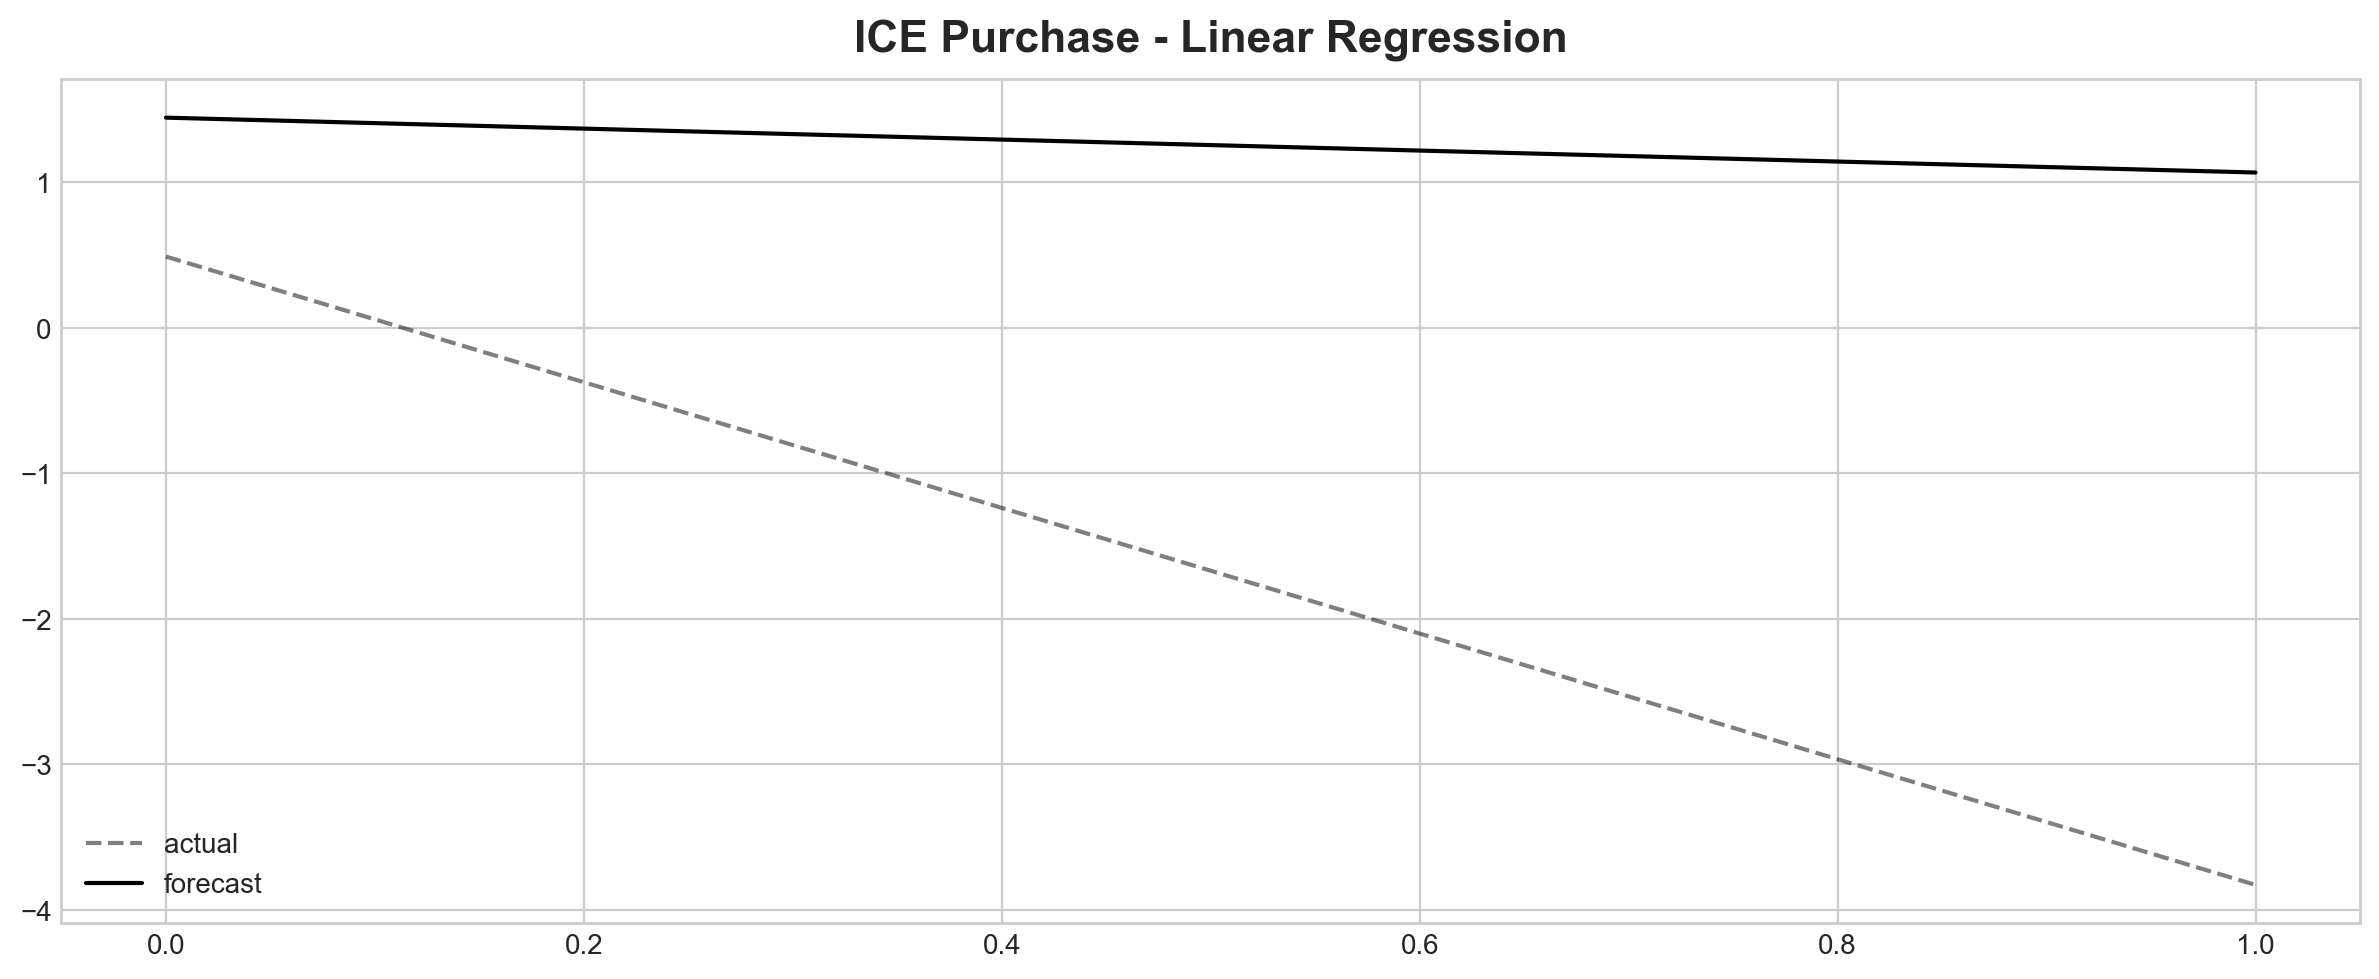

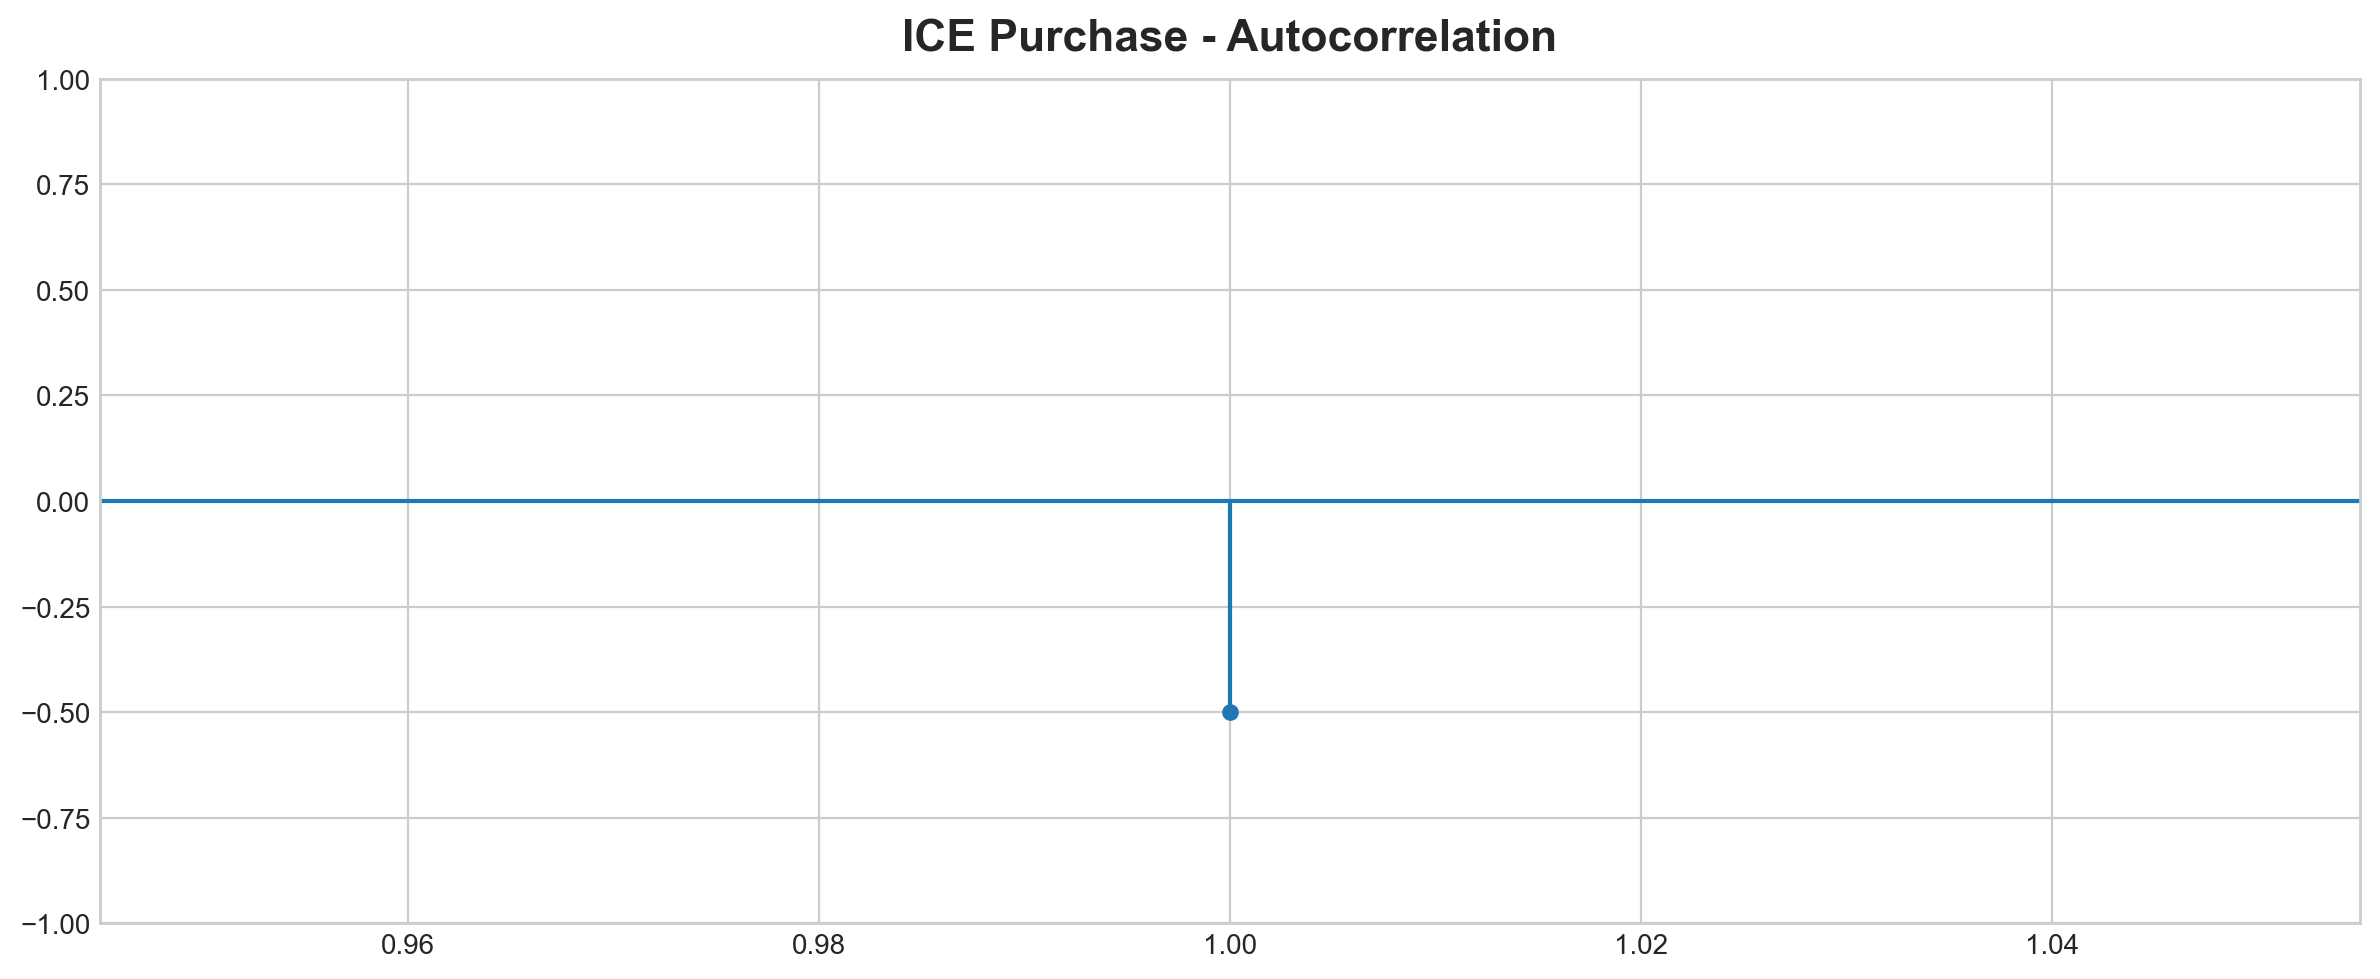

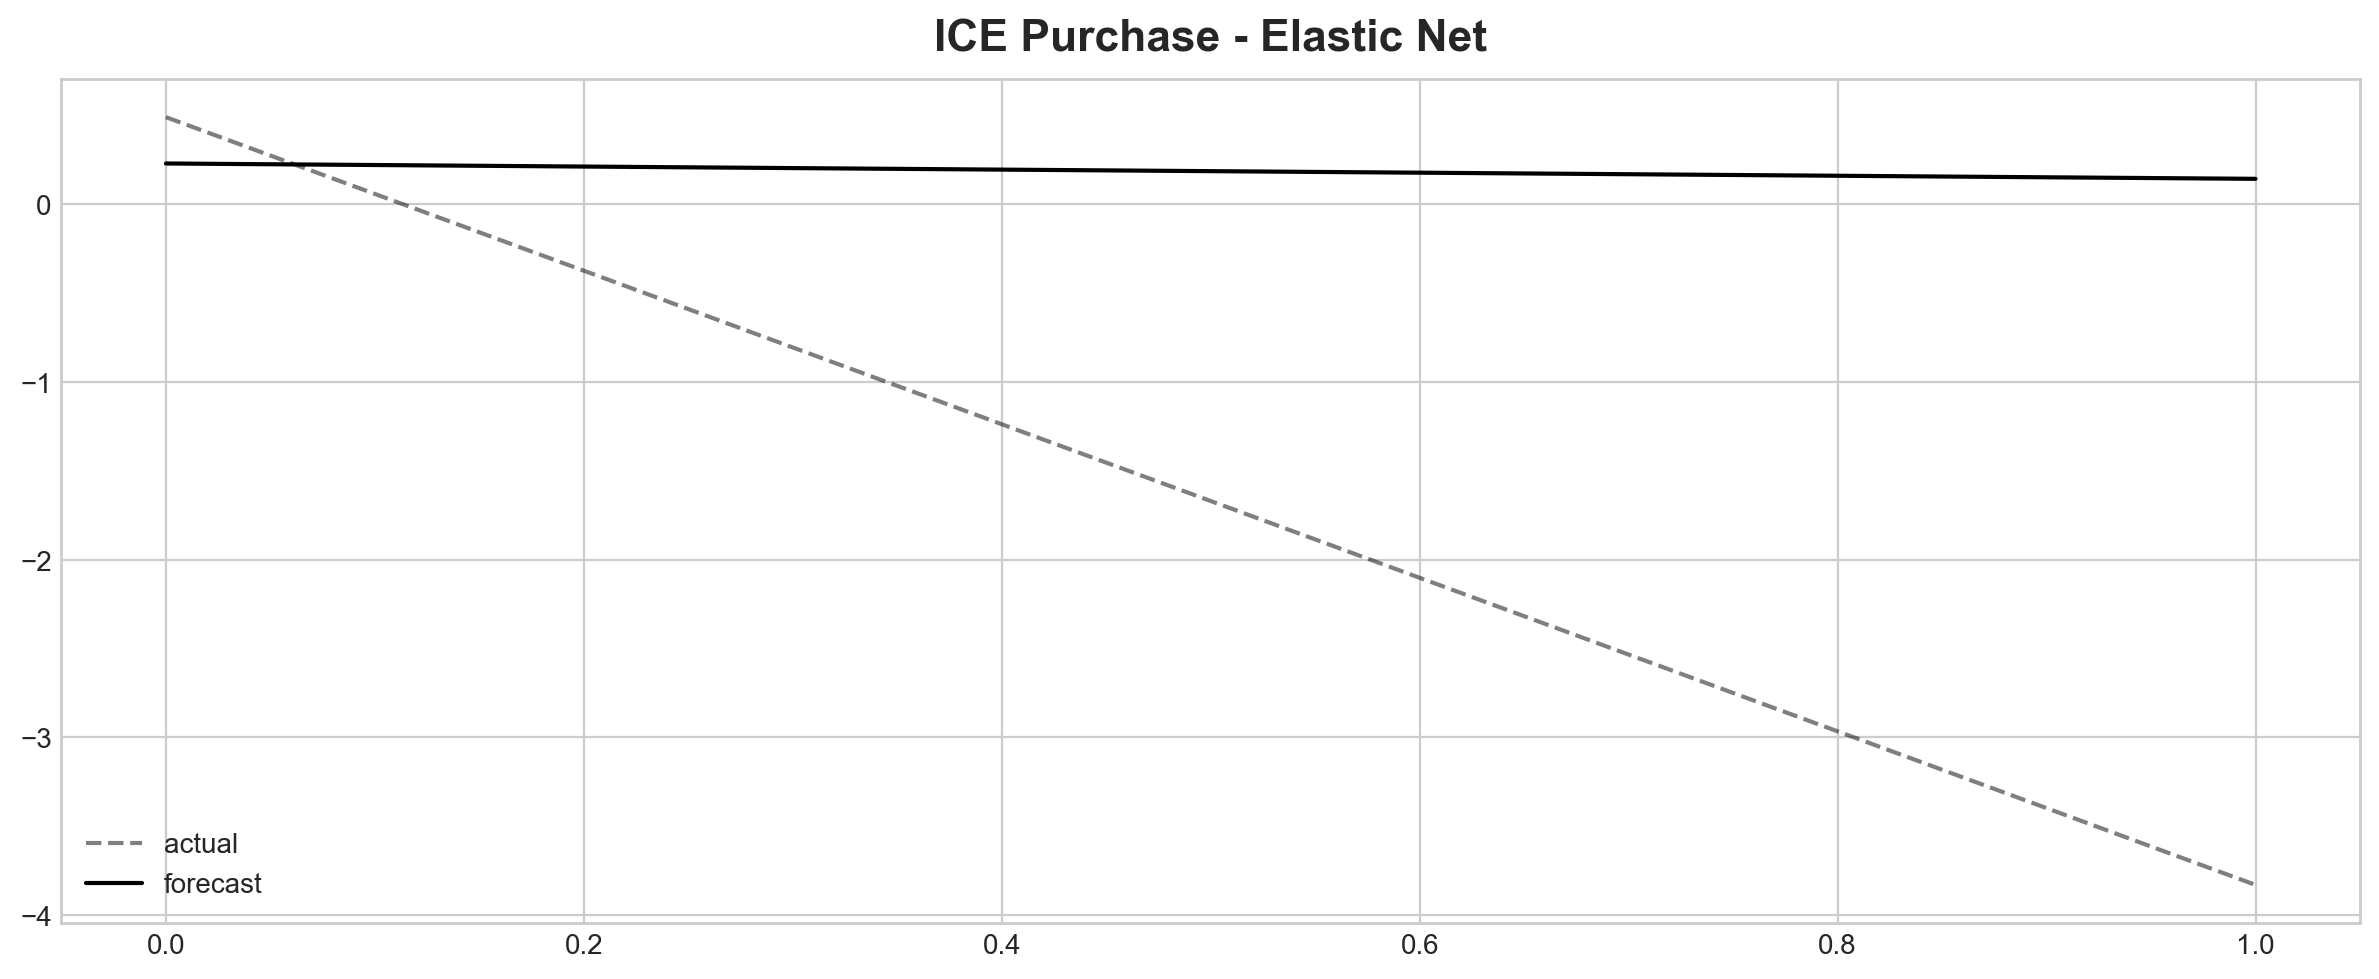

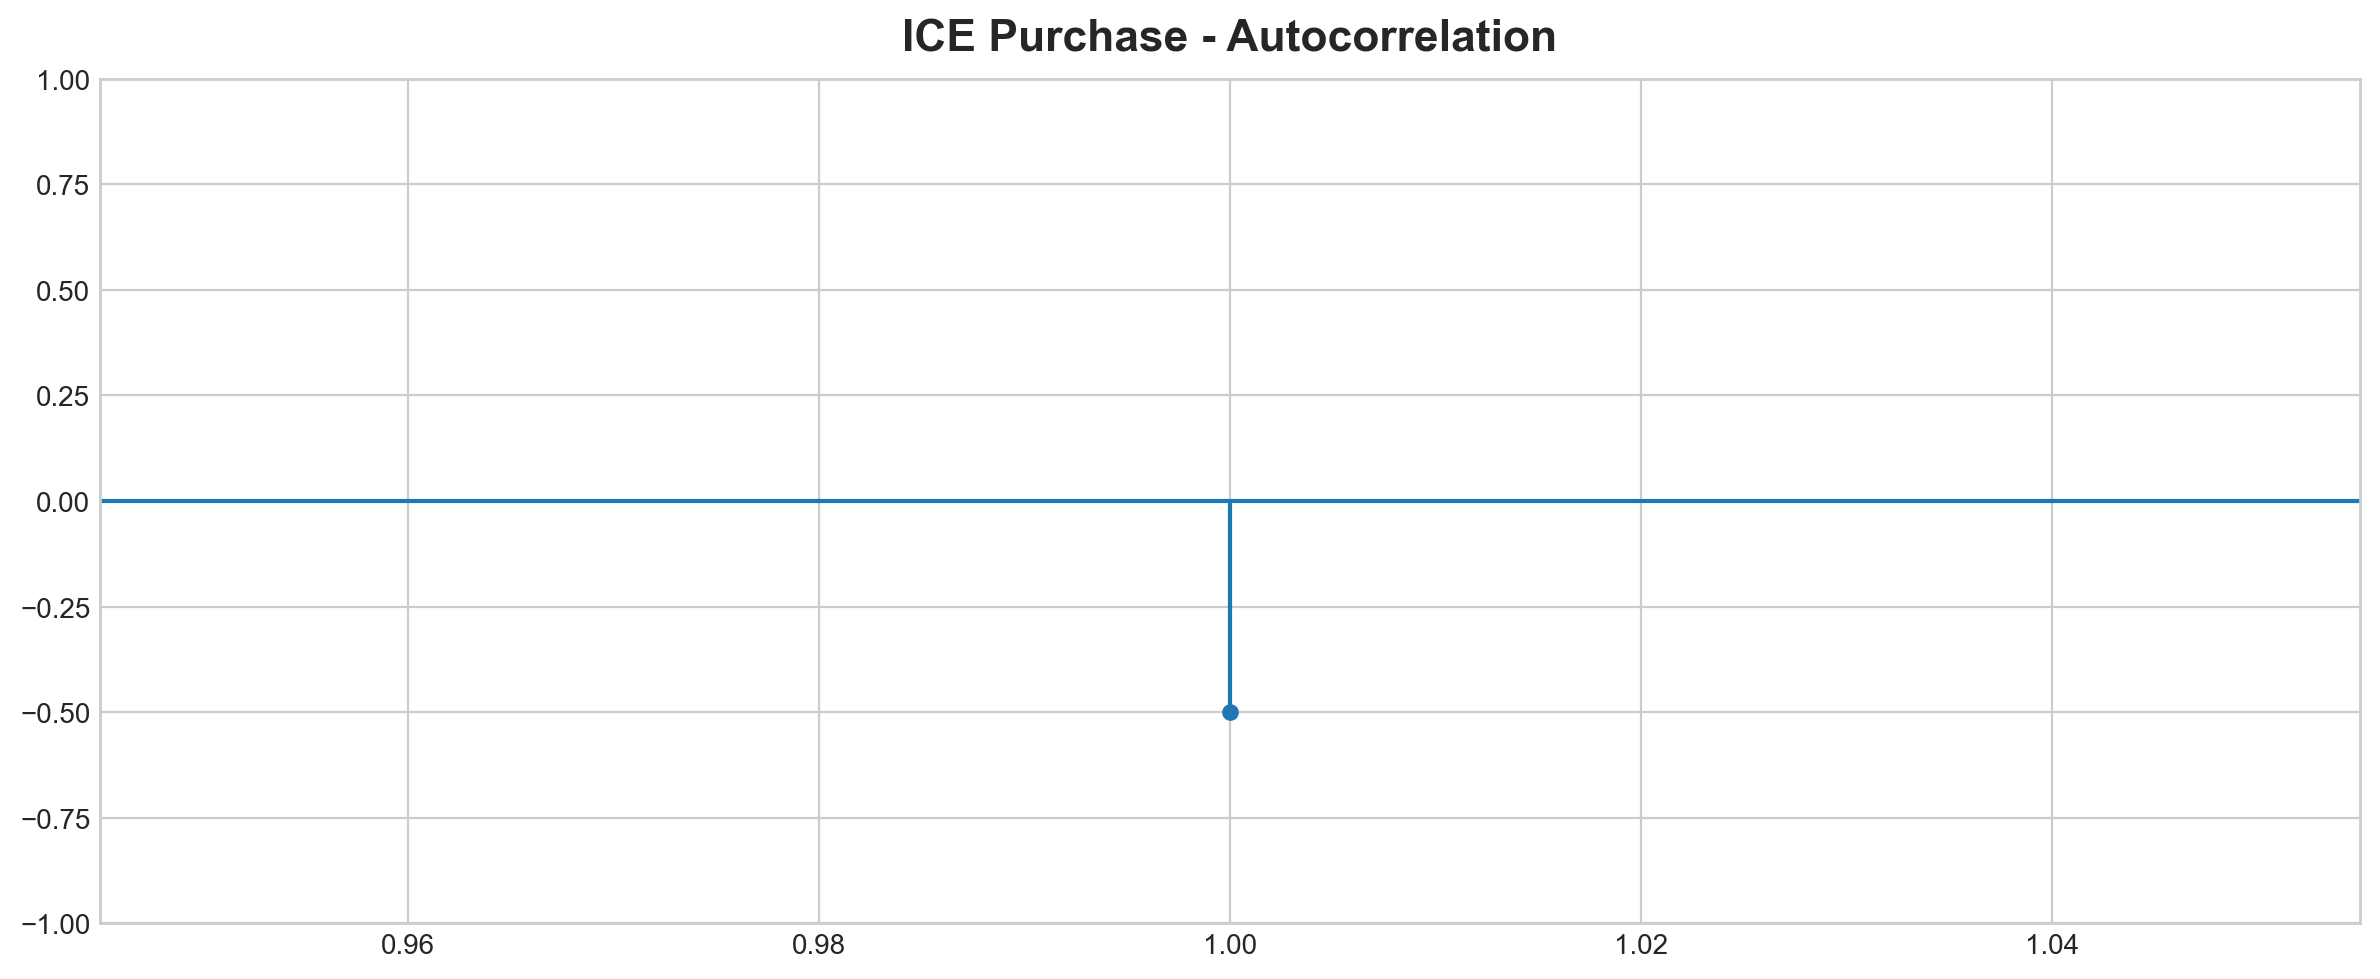

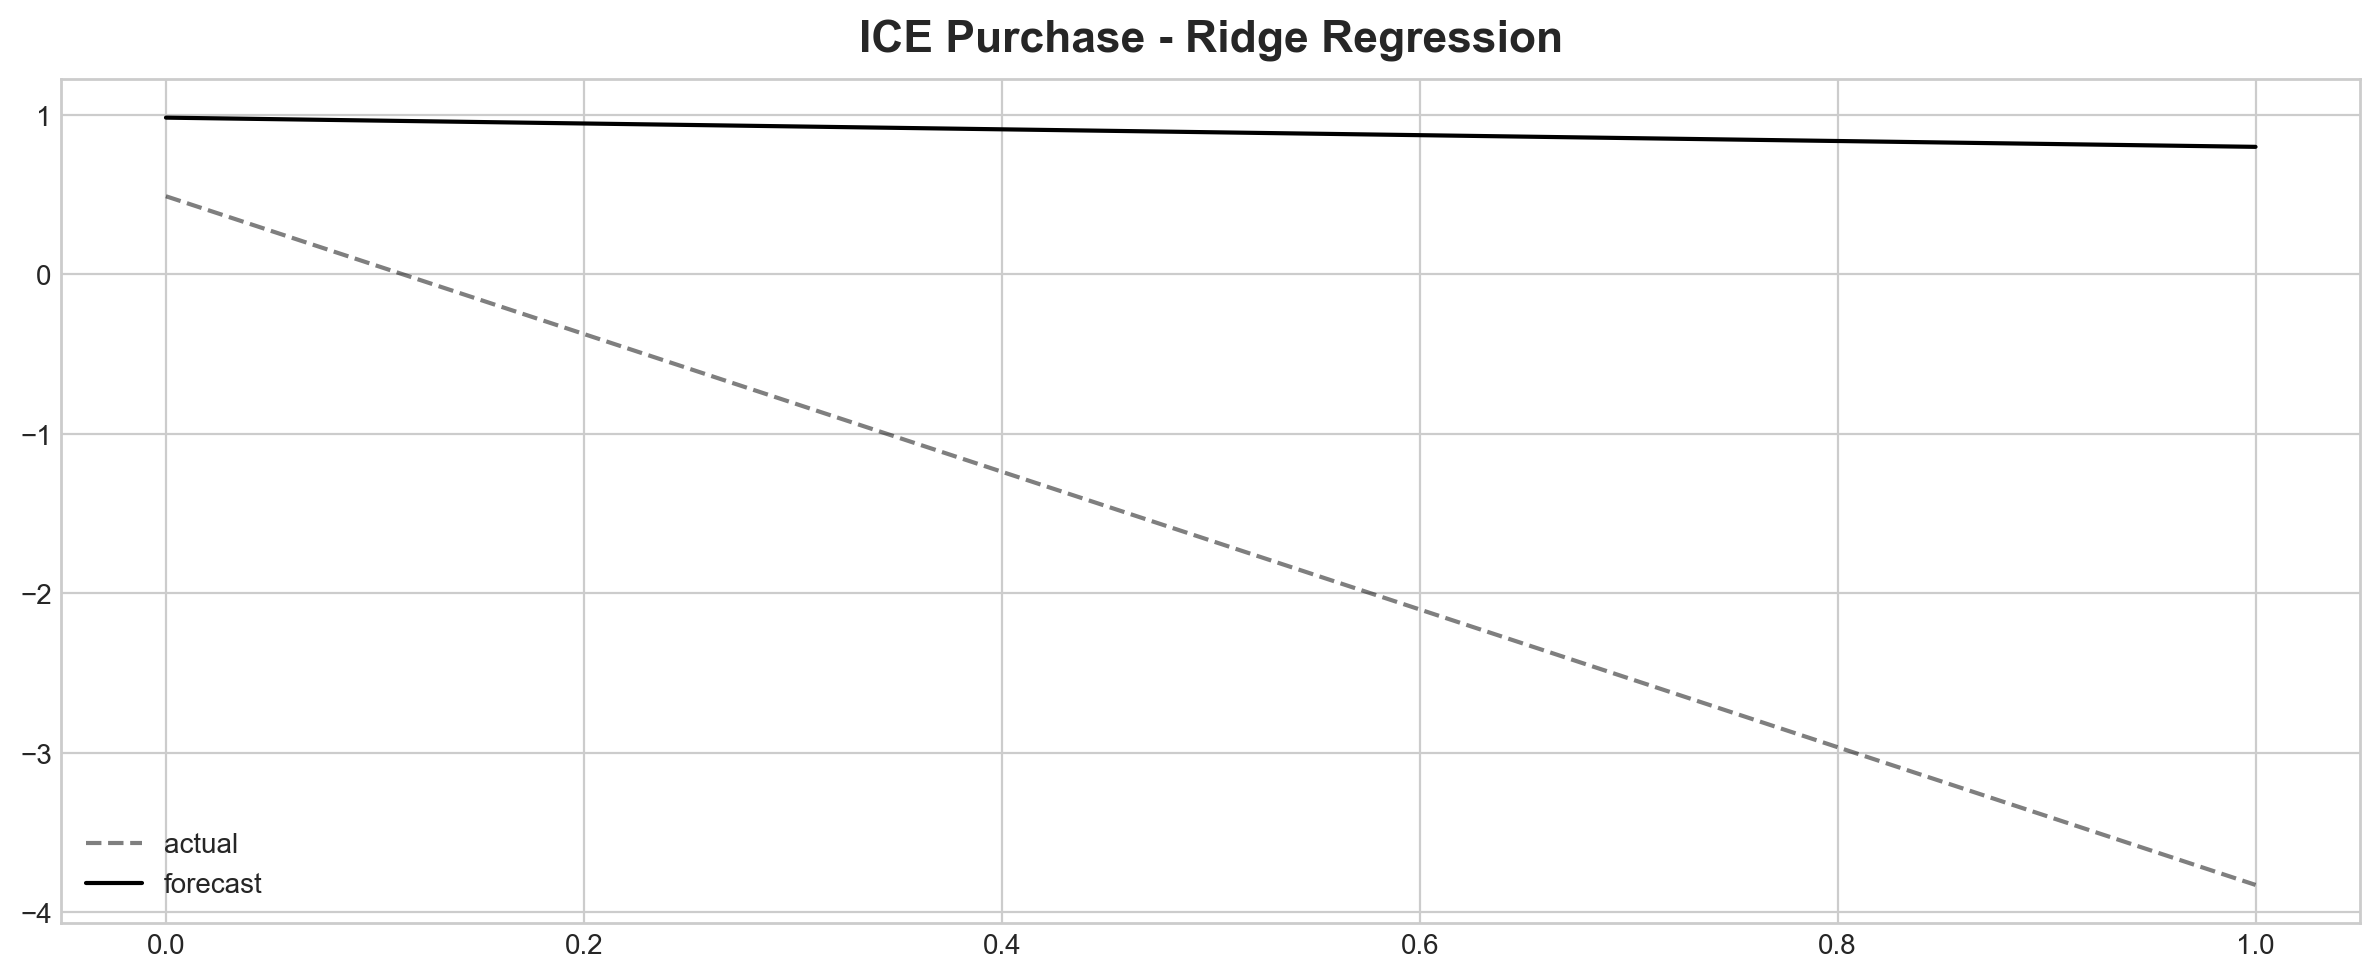

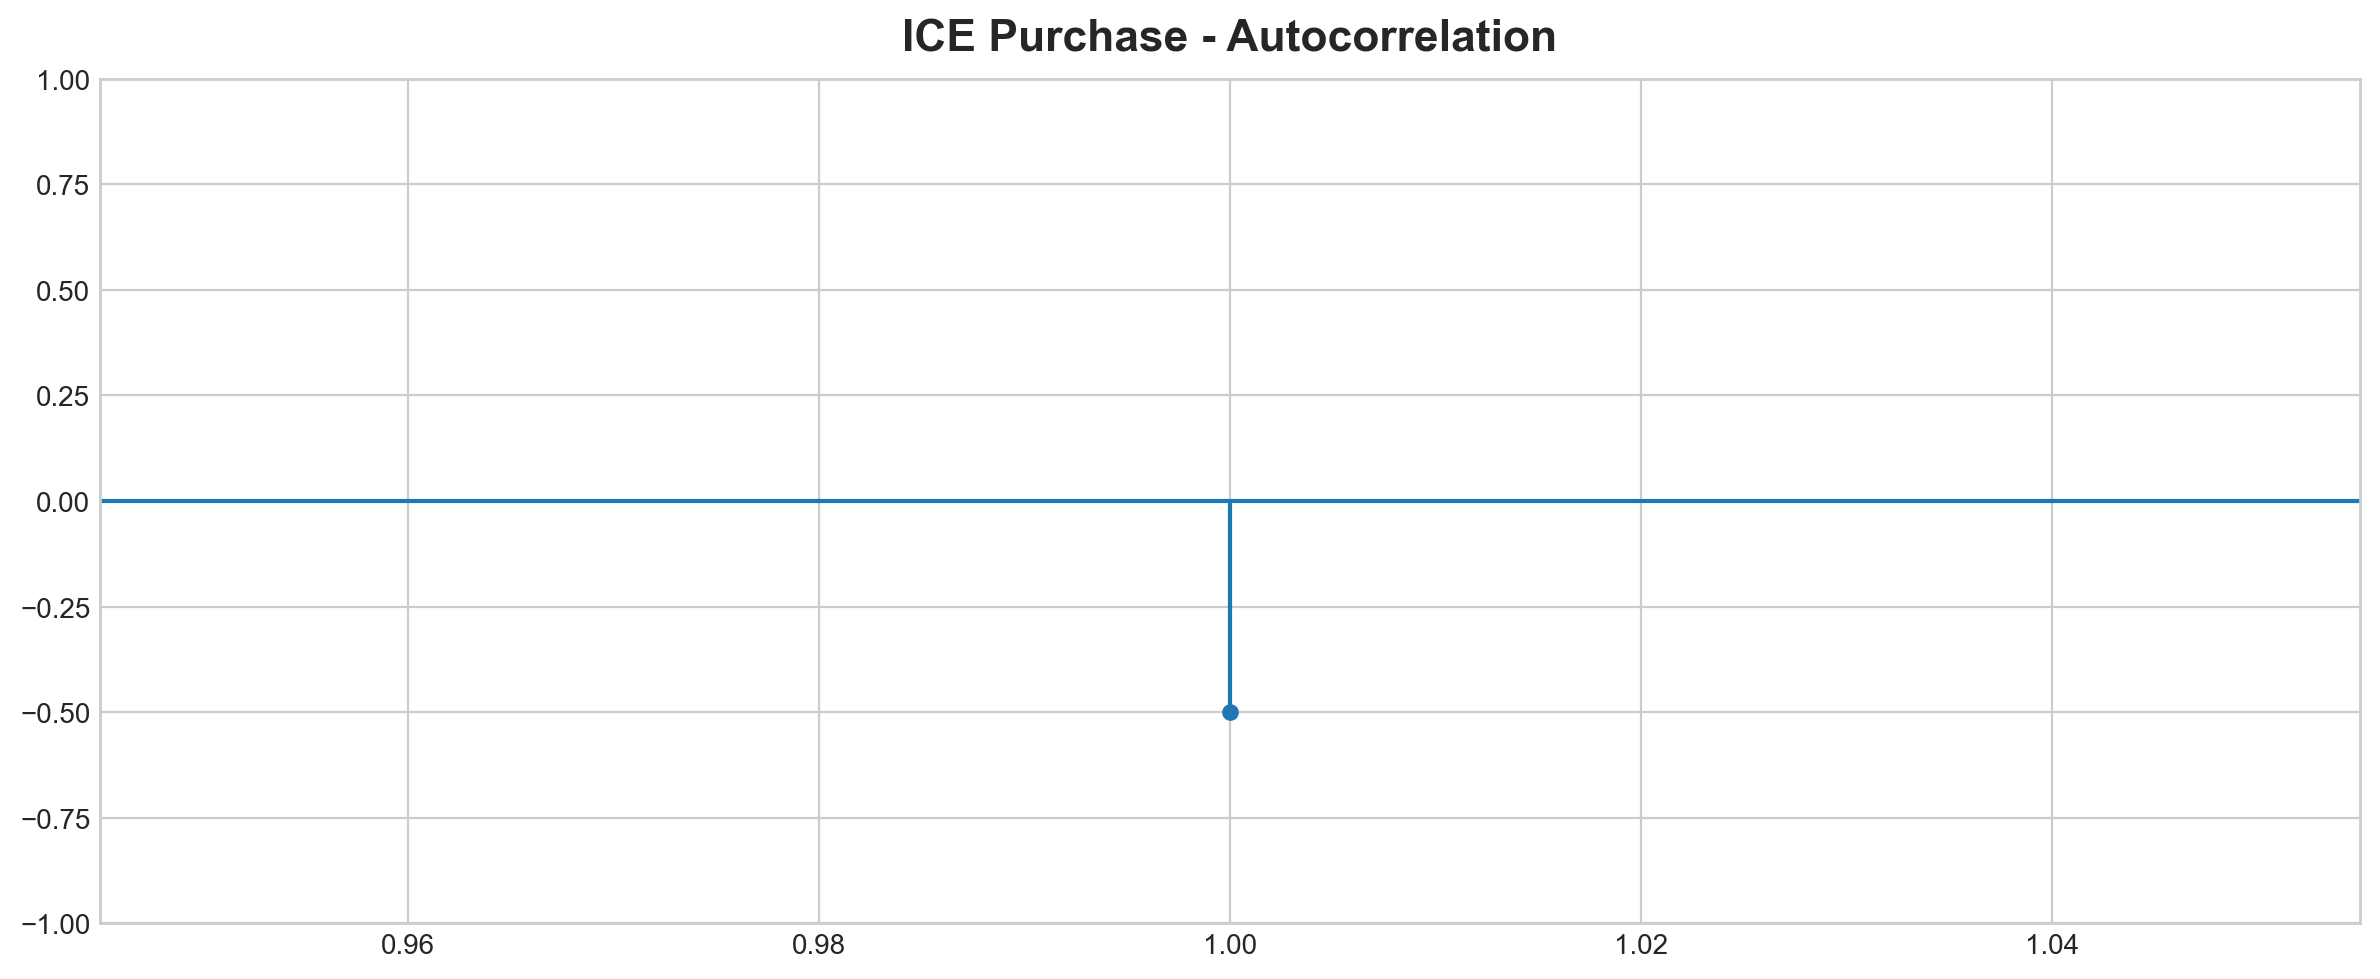

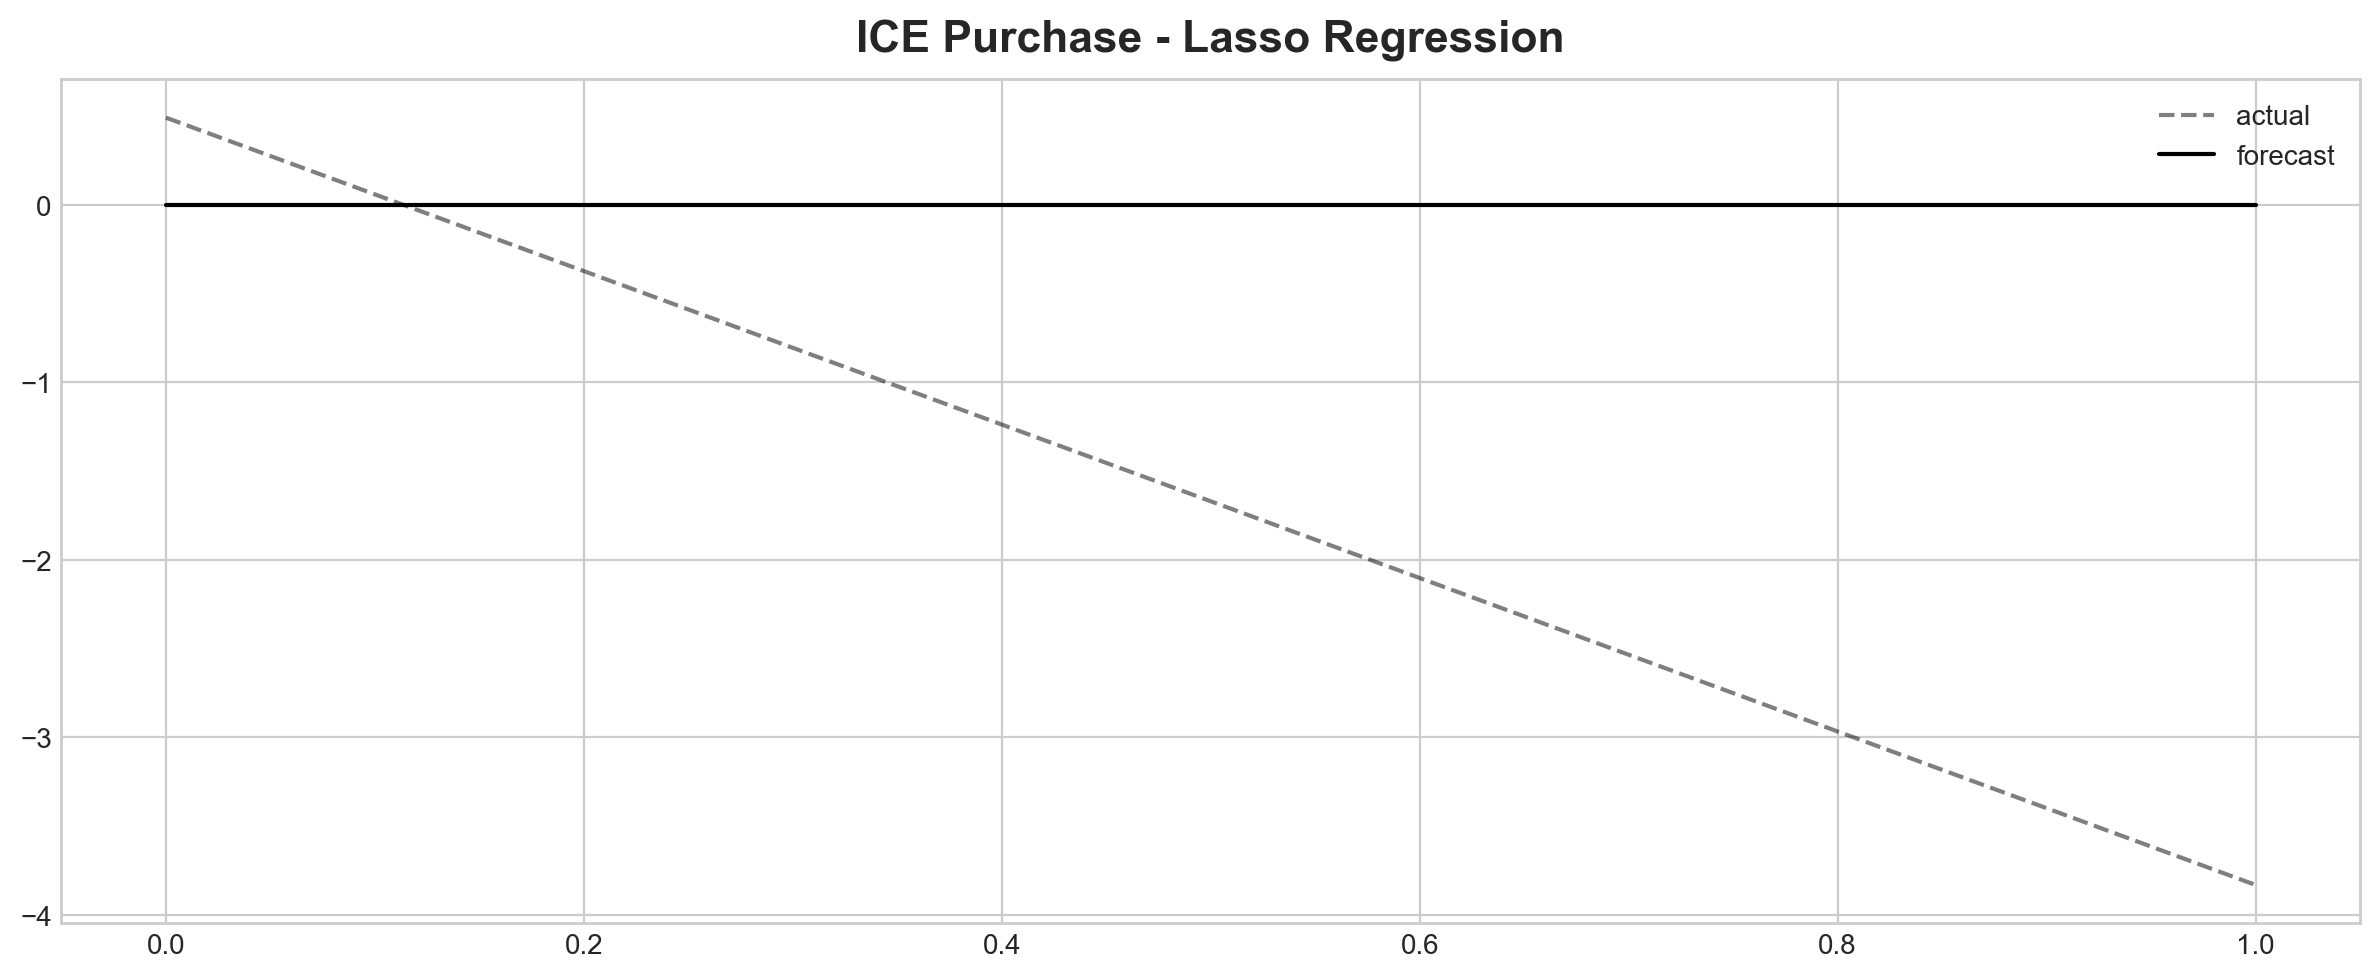

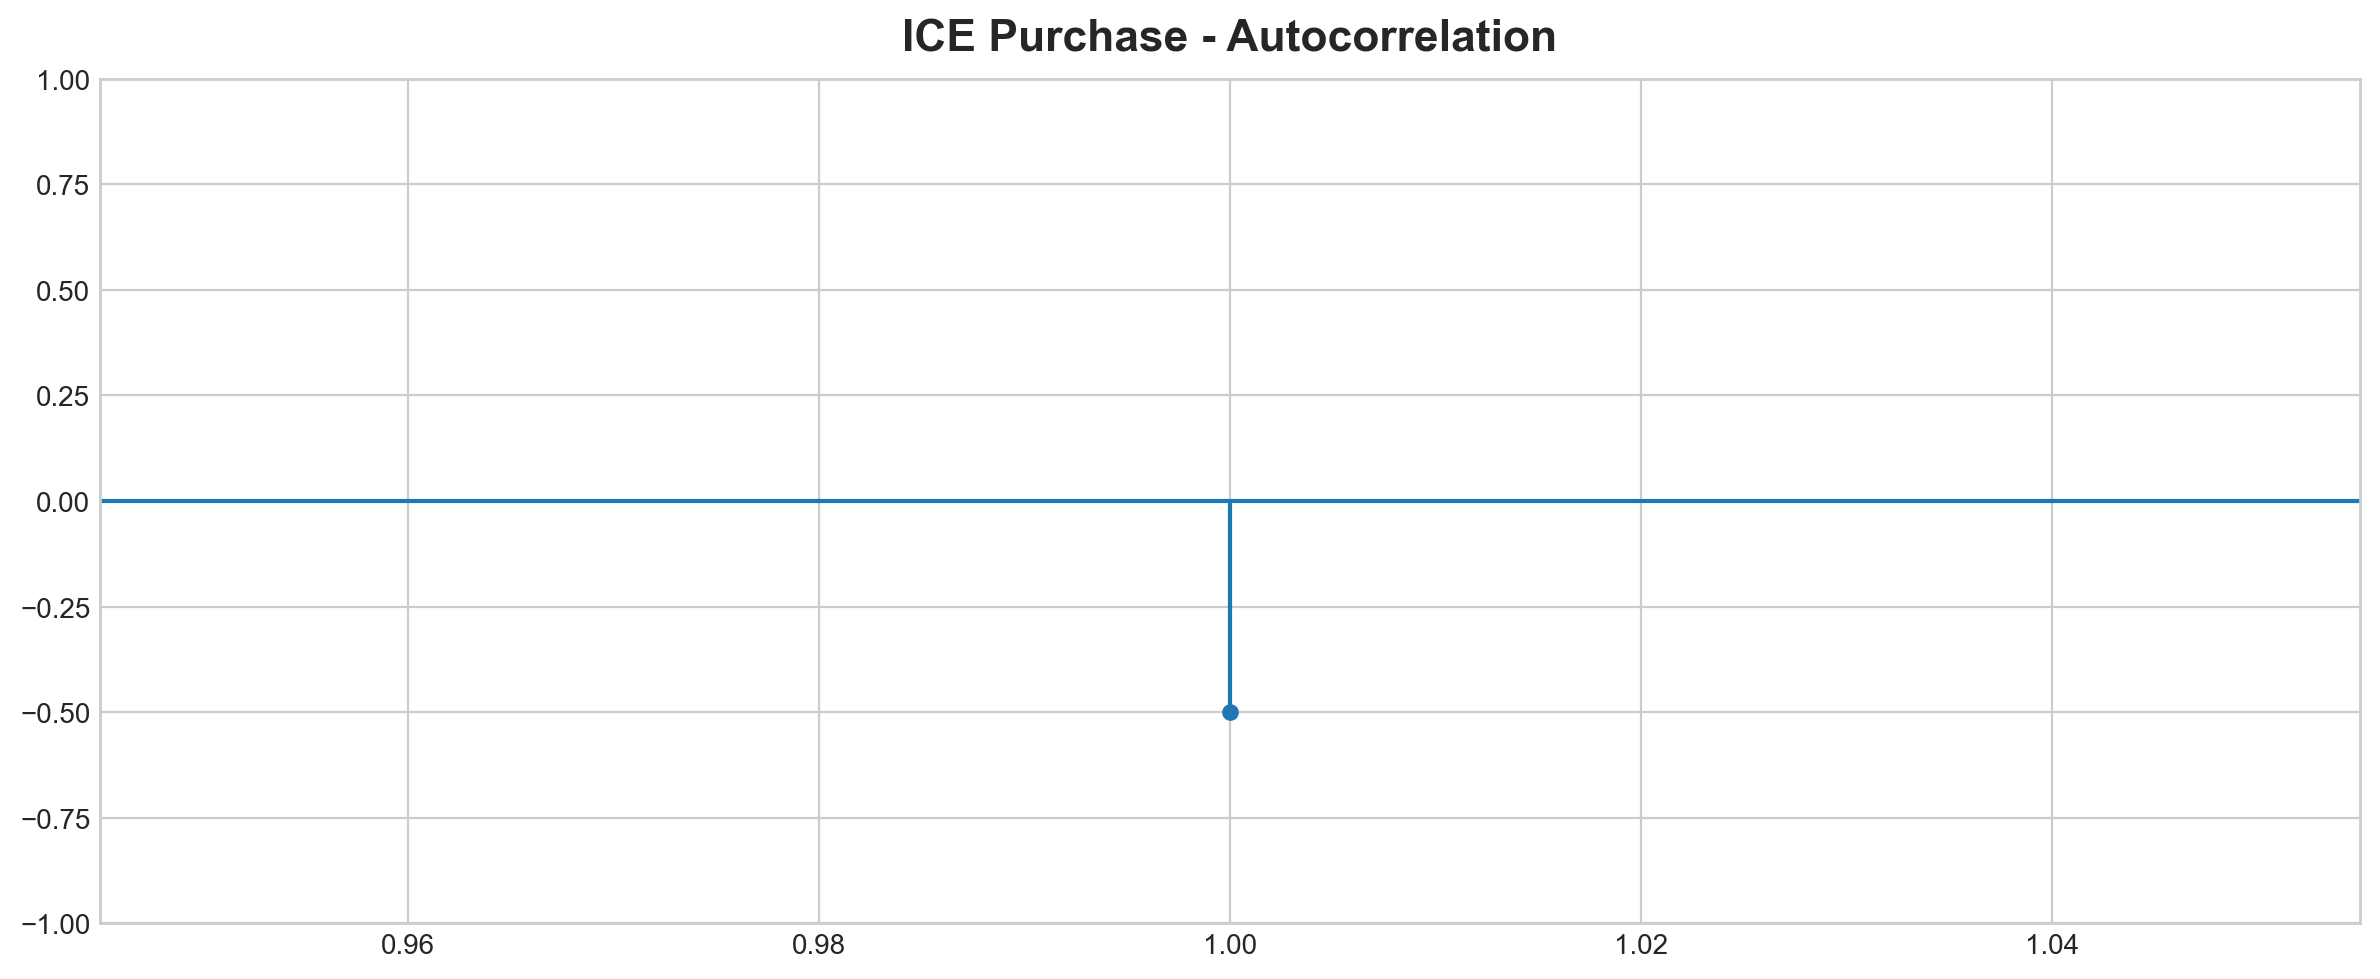

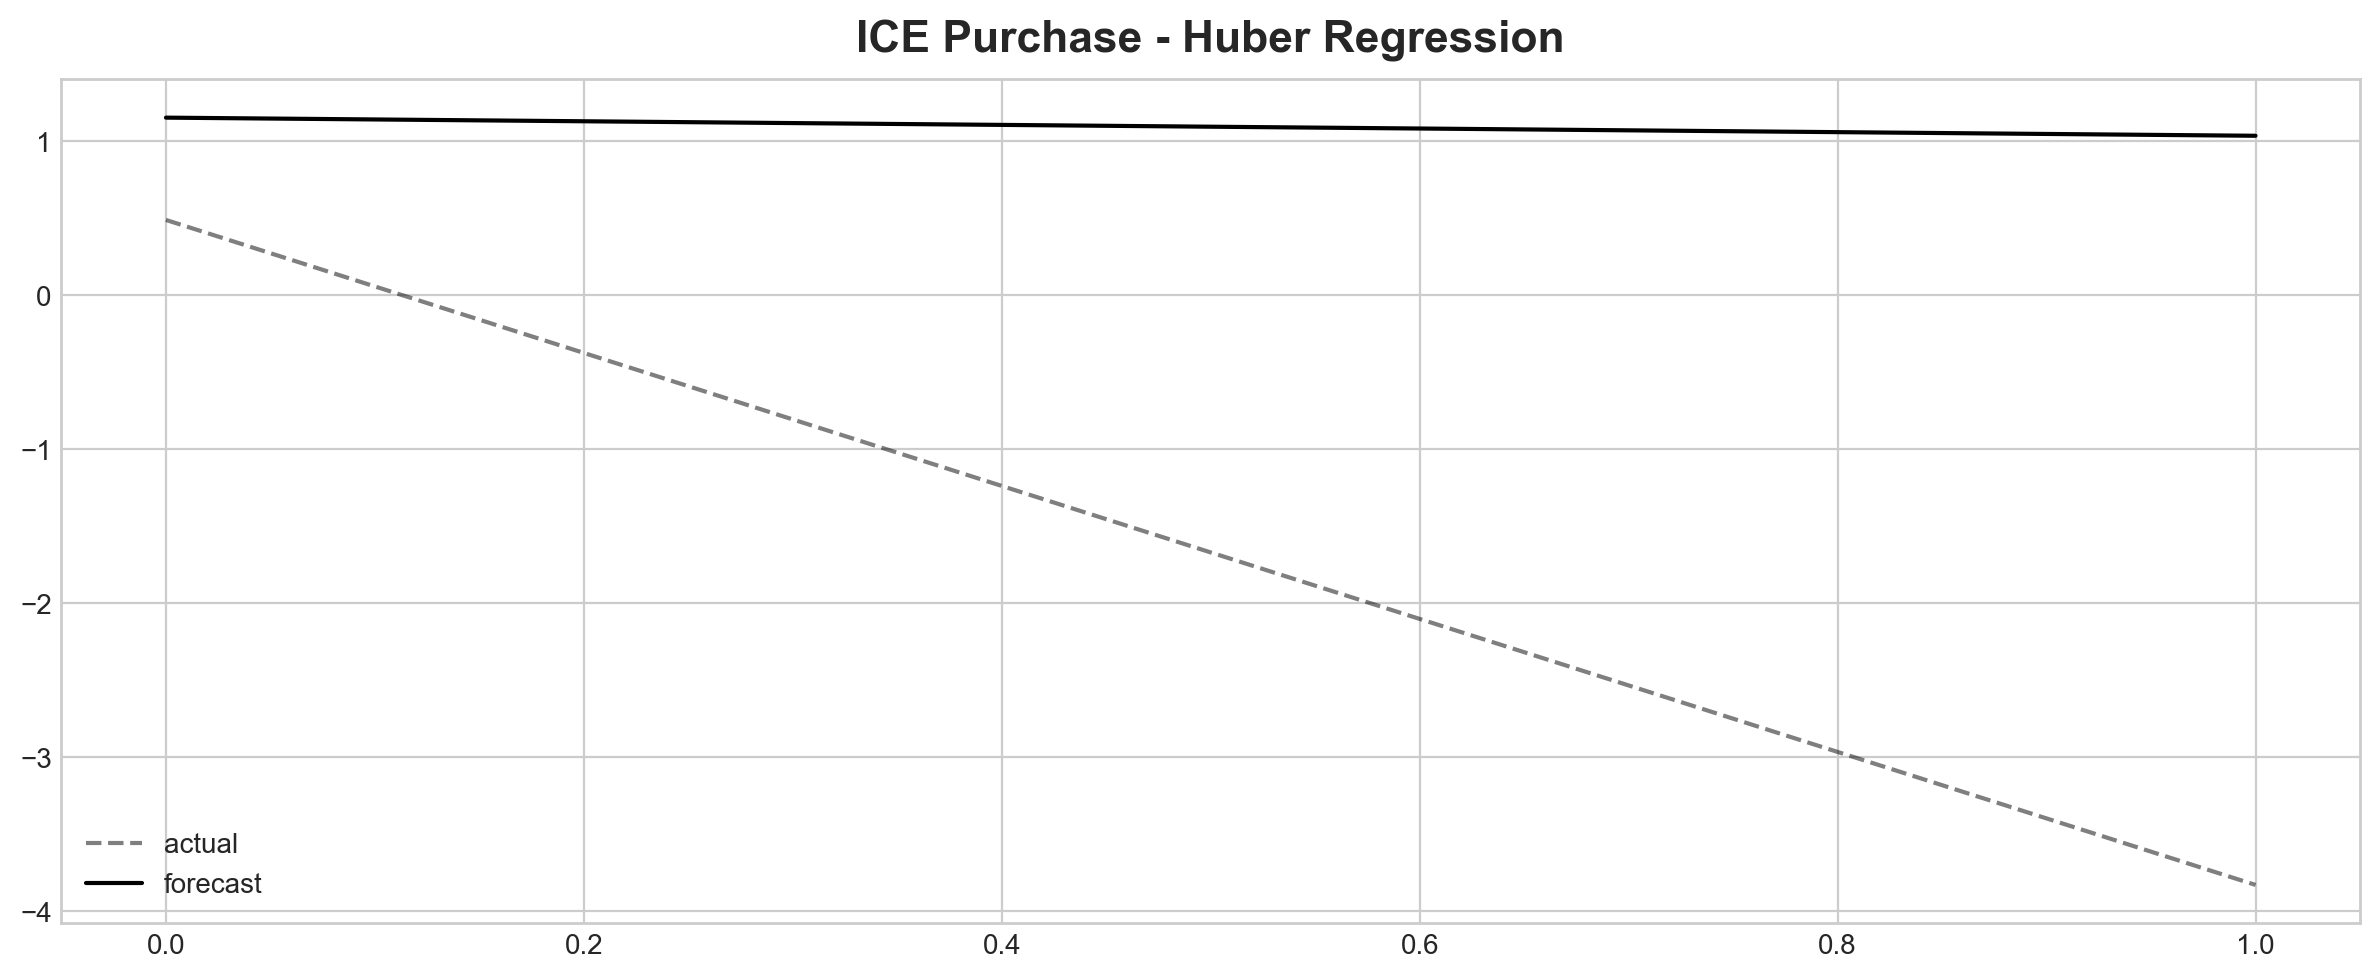

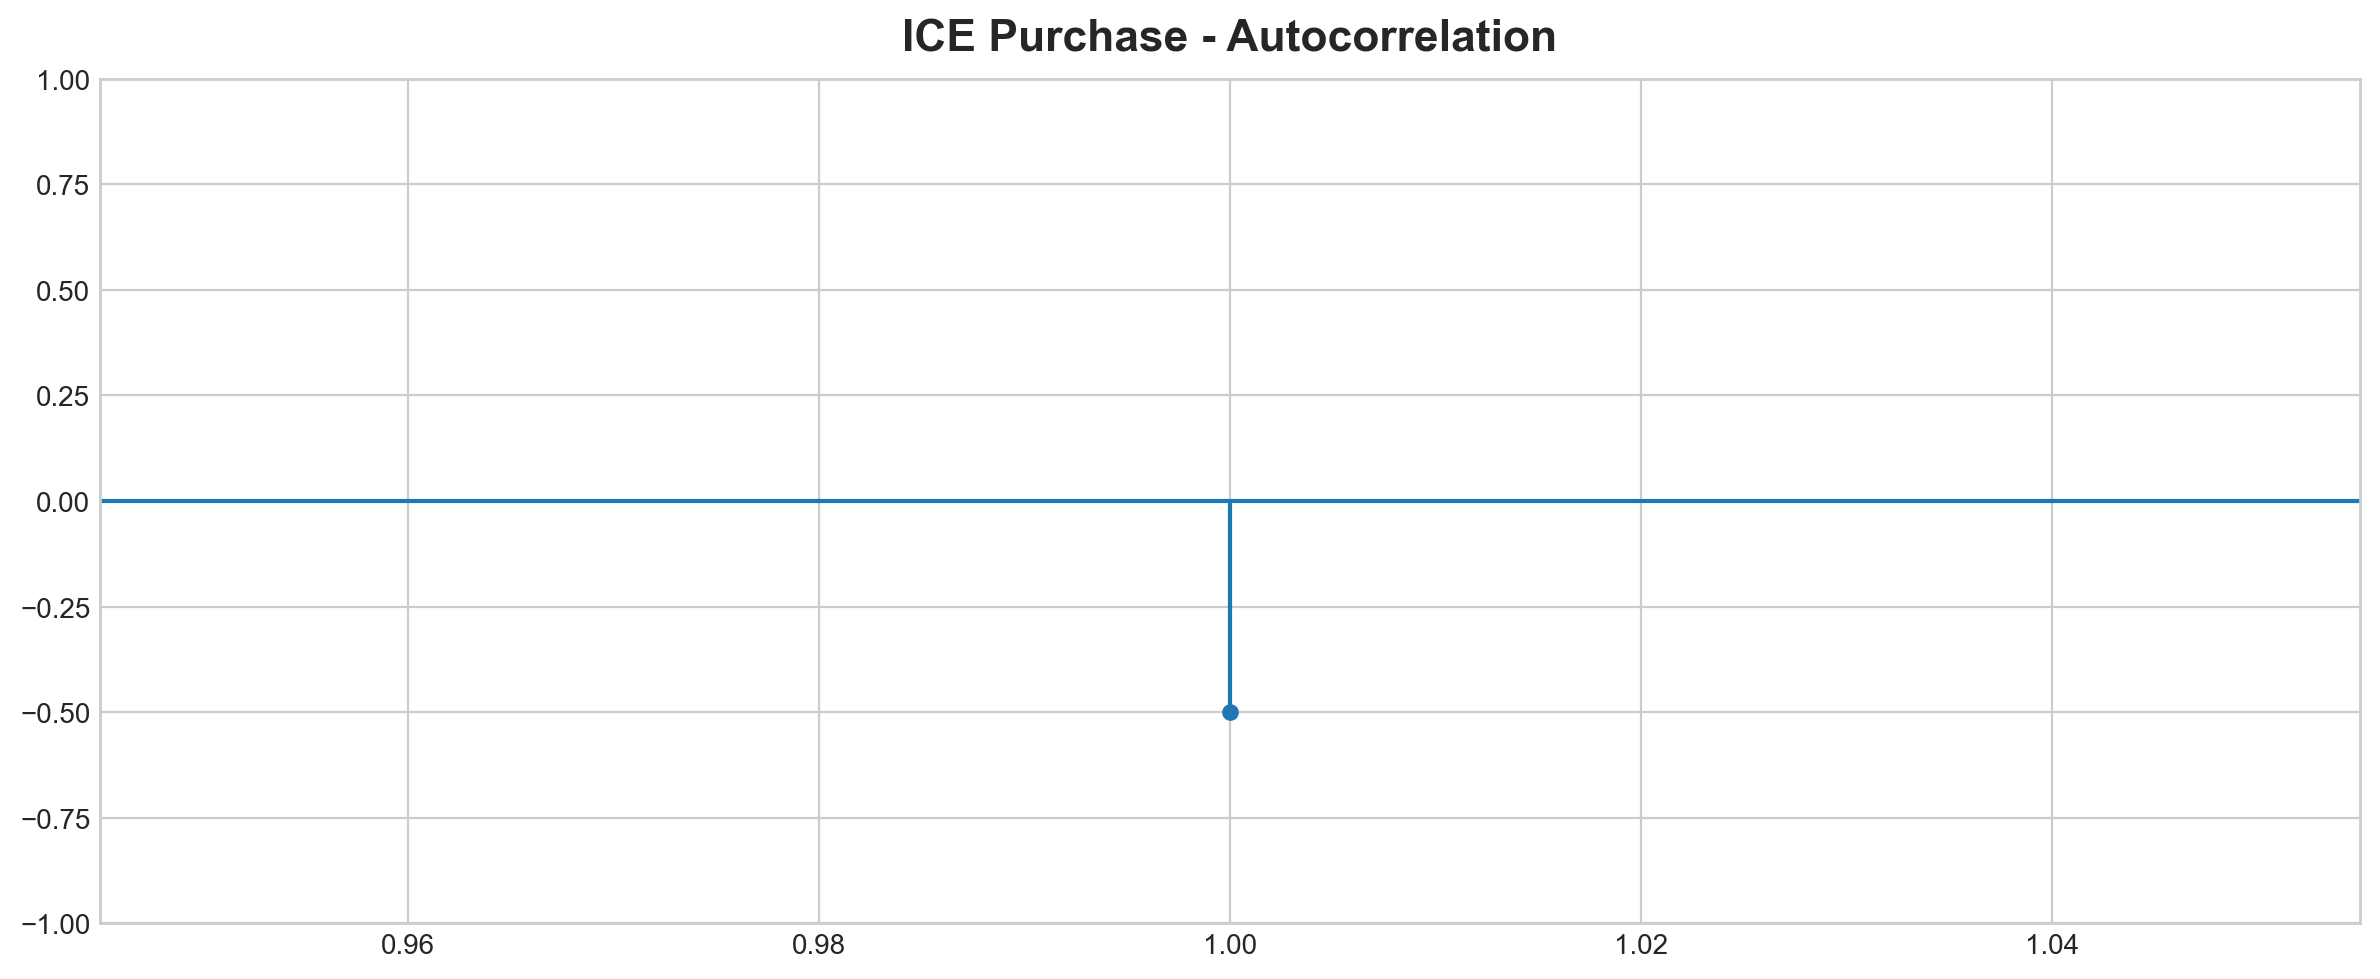

In [68]:
cols = ['yhat', 'resid', 'actual', 'Model Name']
plot_results(cols, ice_results, 'ICE Purchase')

In [69]:
cols = ['Model Name', 'Model']
en_models = ice_results.iloc[0:4][cols]

for row in en_models.iterrows():
    print(row[1][0])
    print(row[1][1].coef_)

Linear Regression
[-0.49028871 -0.65839996 -0.96141524]
Elastic Net
[ 0.         -0.08013464 -0.1603463 ]
Ridge Regression
[-0.2086868  -0.48981137 -0.66194408]
Lasso Regression
[ 0. -0. -0.]


Recursive multi-step forecasting

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [72]:
ice_copy4 = ice.copy()
ice_copy4

year  count
0   2011   4092
1   2012   4170
2   2013   4217
3   2014   4098
4   2015   4126
5   2016   4164
6   2017   4139
7   2018   4149
8   2019   4093
9   2020   4142
10  2021   4020

In [73]:
ice_copy4.rename(columns={"count": "y"}, inplace=True)

In [74]:
ice_copy4 = ice_copy4.set_index("year")
ice_copy4

y
year      
2011  4092
2012  4170
2013  4217
2014  4098
2015  4126
2016  4164
2017  4139
2018  4149
2019  4093
2020  4142
2021  4020

In [75]:
ice_copy4 = ice_copy4['y']

In [76]:
steps = 2
data_train = ice_copy4[:-steps]
data_test  = ice_copy4[-steps:]

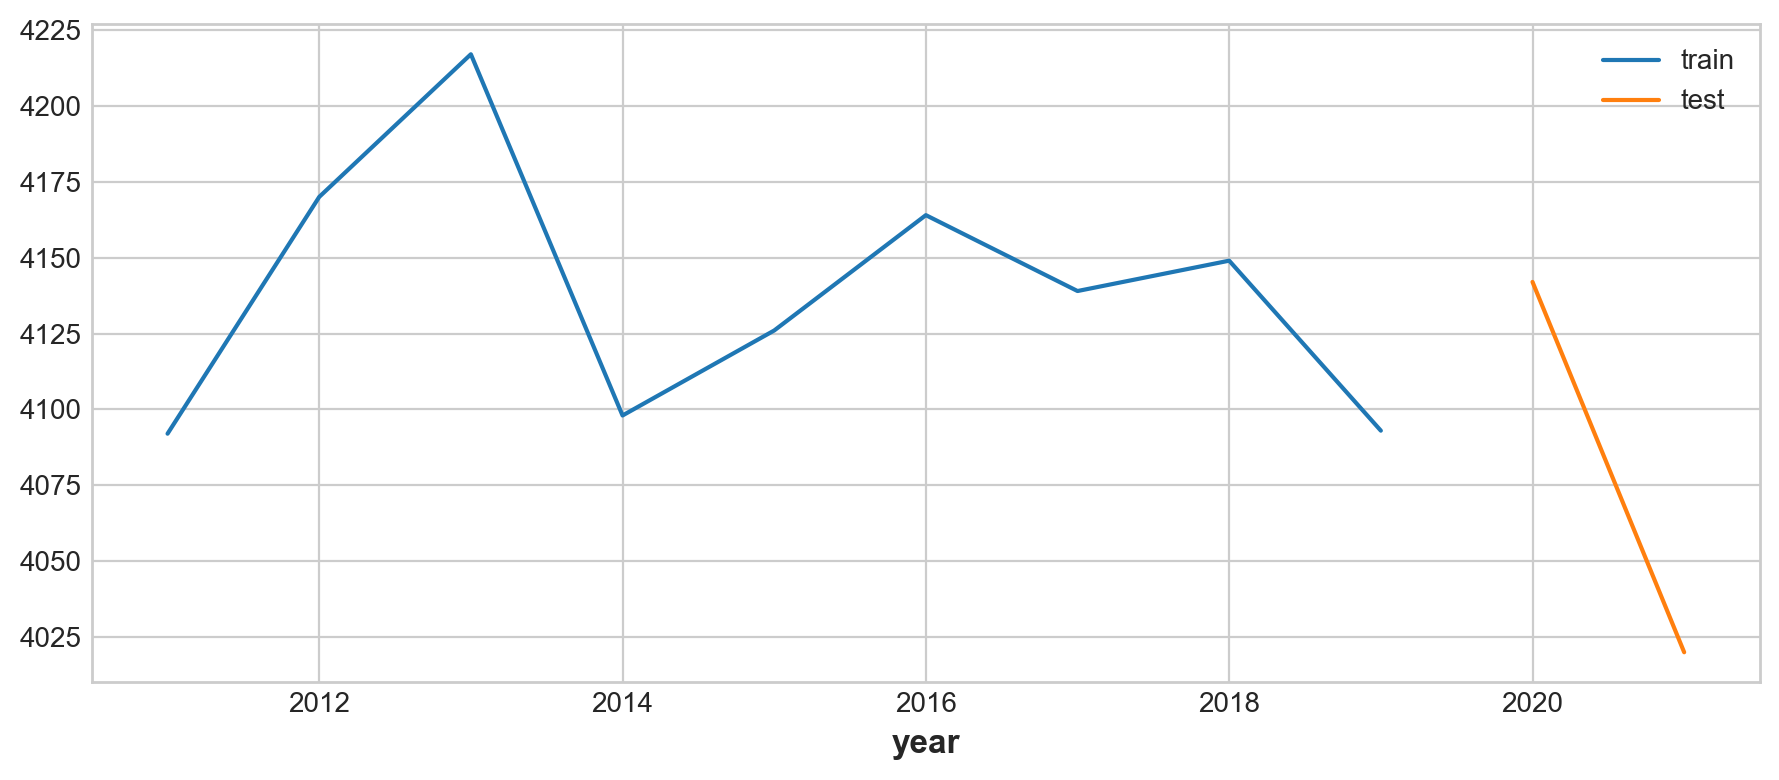

In [78]:
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();

In [79]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 8
             )

forecaster.fit(y=data_train)
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: None 
Transformer for exog: None 
Window size: 8 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 8] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-02-01 18:34:08 
Last fit date: 2023-02-01 18:34:09 
Skforecast version: 0.6.0 
Python version: 3.9.16 

In [80]:
predictions = forecaster.predict(steps=2)
predictions.head()

8    4093.0
9    4093.0
Name: pred, dtype: float64

In [81]:
predictions.index = [2020,2021]

In [82]:
data_train

year
2011    4092
2012    4170
2013    4217
2014    4098
2015    4126
2016    4164
2017    4139
2018    4149
2019    4093
Name: y, dtype: int64

In [83]:
ahead_predictions = forecaster.predict(steps=7)
ahead_predictions

8     4093.0
9     4093.0
10    4093.0
11    4093.0
12    4093.0
13    4093.0
14    4093.0
Name: pred, dtype: float64

In [84]:
ahead_predictions.index = [2020,2021,2022,2023,2024,2025,2026]

In [85]:
ahead_predictions

2020    4093.0
2021    4093.0
2022    4093.0
2023    4093.0
2024    4093.0
2025    4093.0
2026    4093.0
Name: pred, dtype: float64

In [86]:
ahead_predictions.drop([2020,2021],axis=0,inplace=True)

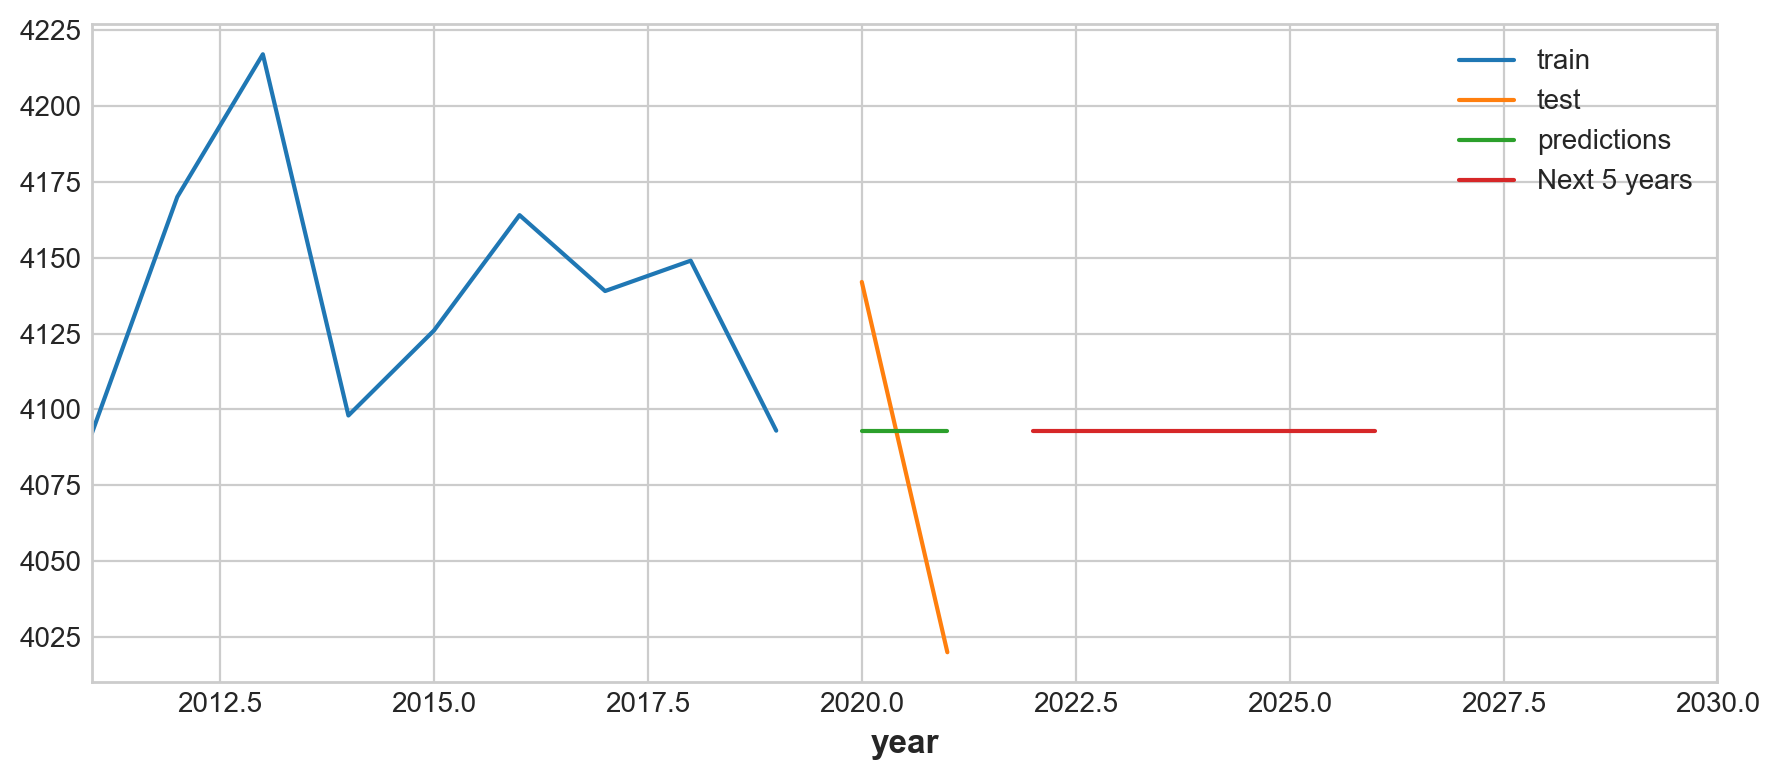

In [87]:
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train', xlim = (2011,2030))
data_test.plot(ax=ax, label='test', xlim = (2011,2030))
predictions.plot(ax=ax, label='predictions')
ahead_predictions.plot(ax=ax, label='Next 5 years')
ax.legend();

XGBOOST

In [88]:
from xgboost import XGBRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg

In [89]:
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(),
                 lags = 8
             )

forecaster.fit(y=data_train,)
forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: None 
Transformer for exog: None 
Window size: 8 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Trainin

In [90]:
predictions= forecaster.predict(steps=2,)
predictions

8    4092.999268
9    4092.999268
Name: pred, dtype: float64

In [91]:
predictions.index = [2020,2021]

In [92]:
ahead_predictions = forecaster.predict(steps=7,)

ahead_predictions.index = [2020,2021,2022,2023,2024,2025,2026]
ahead_predictions.drop([2020,2021],axis=0,inplace=True)


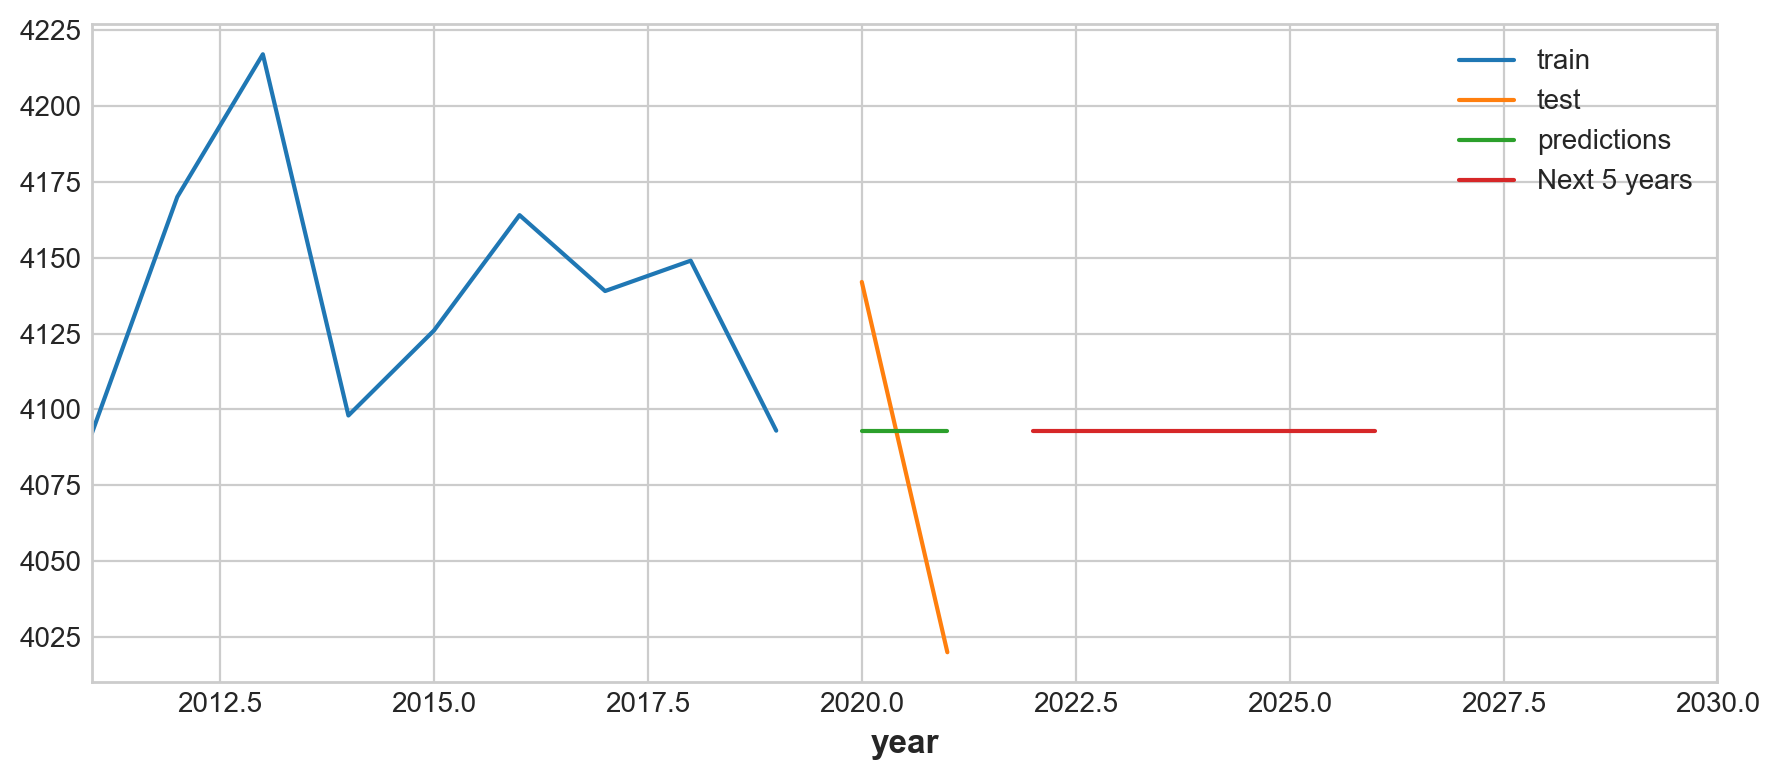

In [93]:
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train', xlim = (2011,2030))
data_test.plot(ax=ax, label='test', xlim = (2011,2030))
predictions.plot(ax=ax, label='predictions')
ahead_predictions.plot(ax=ax, label='Next 5 years')
ax.legend();

# **EV**

In [94]:
ev = data.query('carType == "EV"').groupby(["year"], as_index=False).count()
ev.rename(columns={"carType": "count"}, inplace=True)
ev

year  count
0   2011      3
1   2012     10
2   2013     21
3   2014     51
4   2015     53
5   2016     71
6   2017     59
7   2018     52
8   2019     98
9   2020    110
10  2021    133

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='count'>)

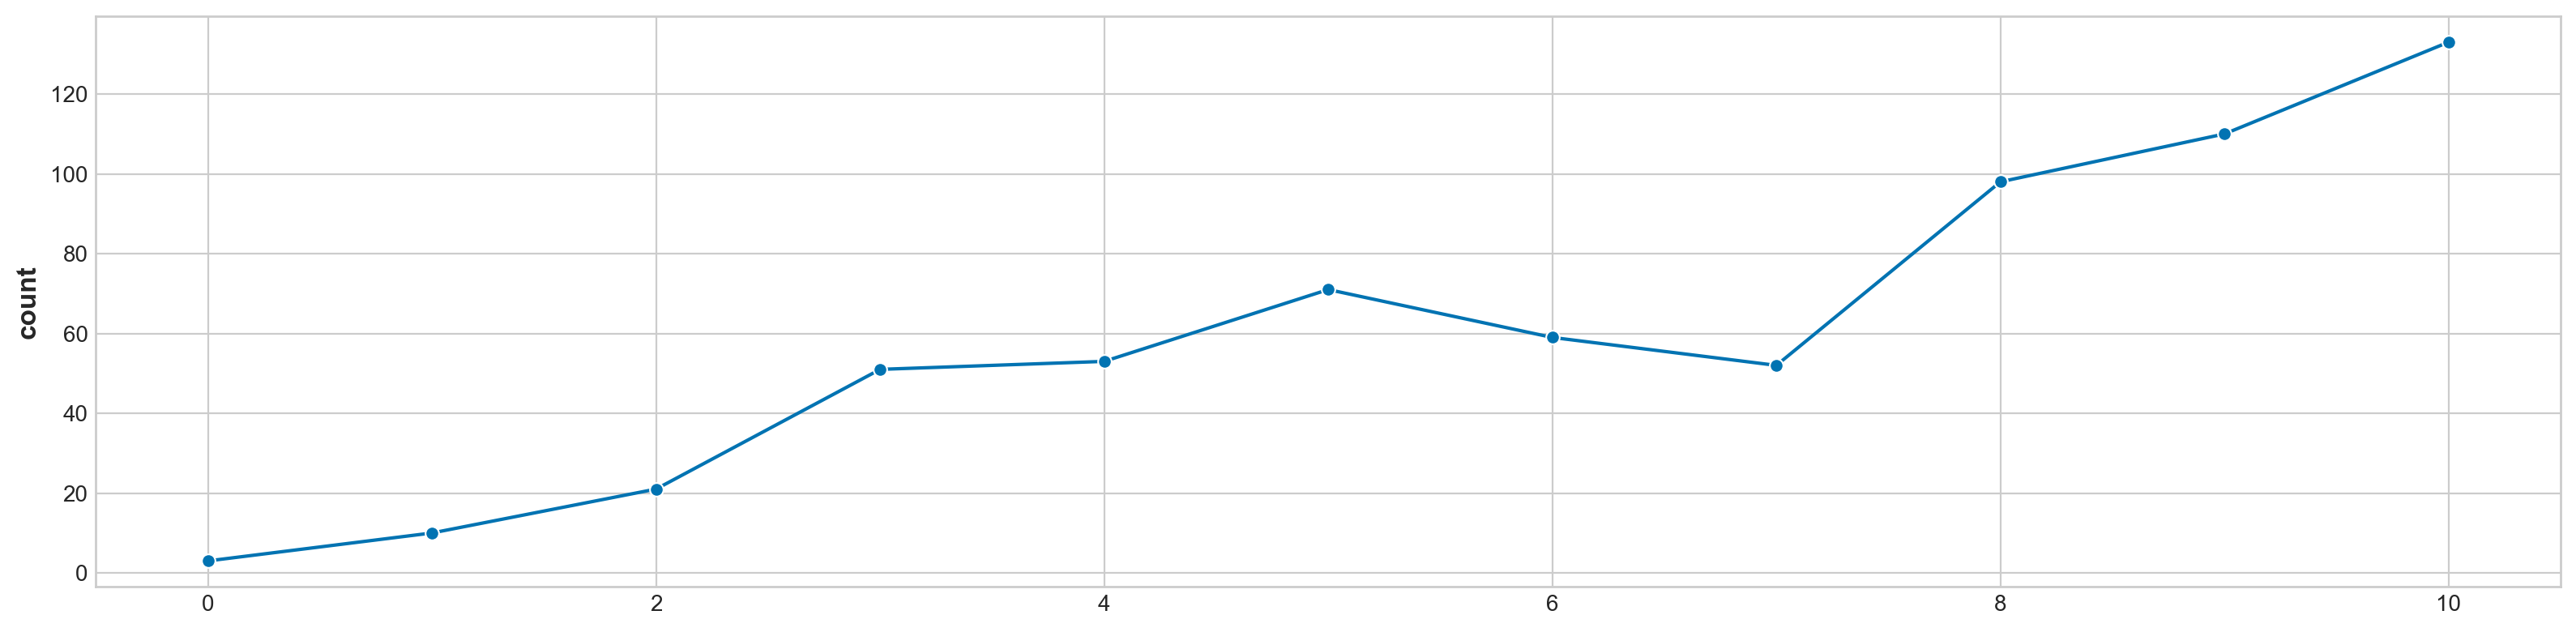

In [95]:
plot_series(ev["count"])

Text(0.5, 1.0, 'Time Plot of EV Car Sales')

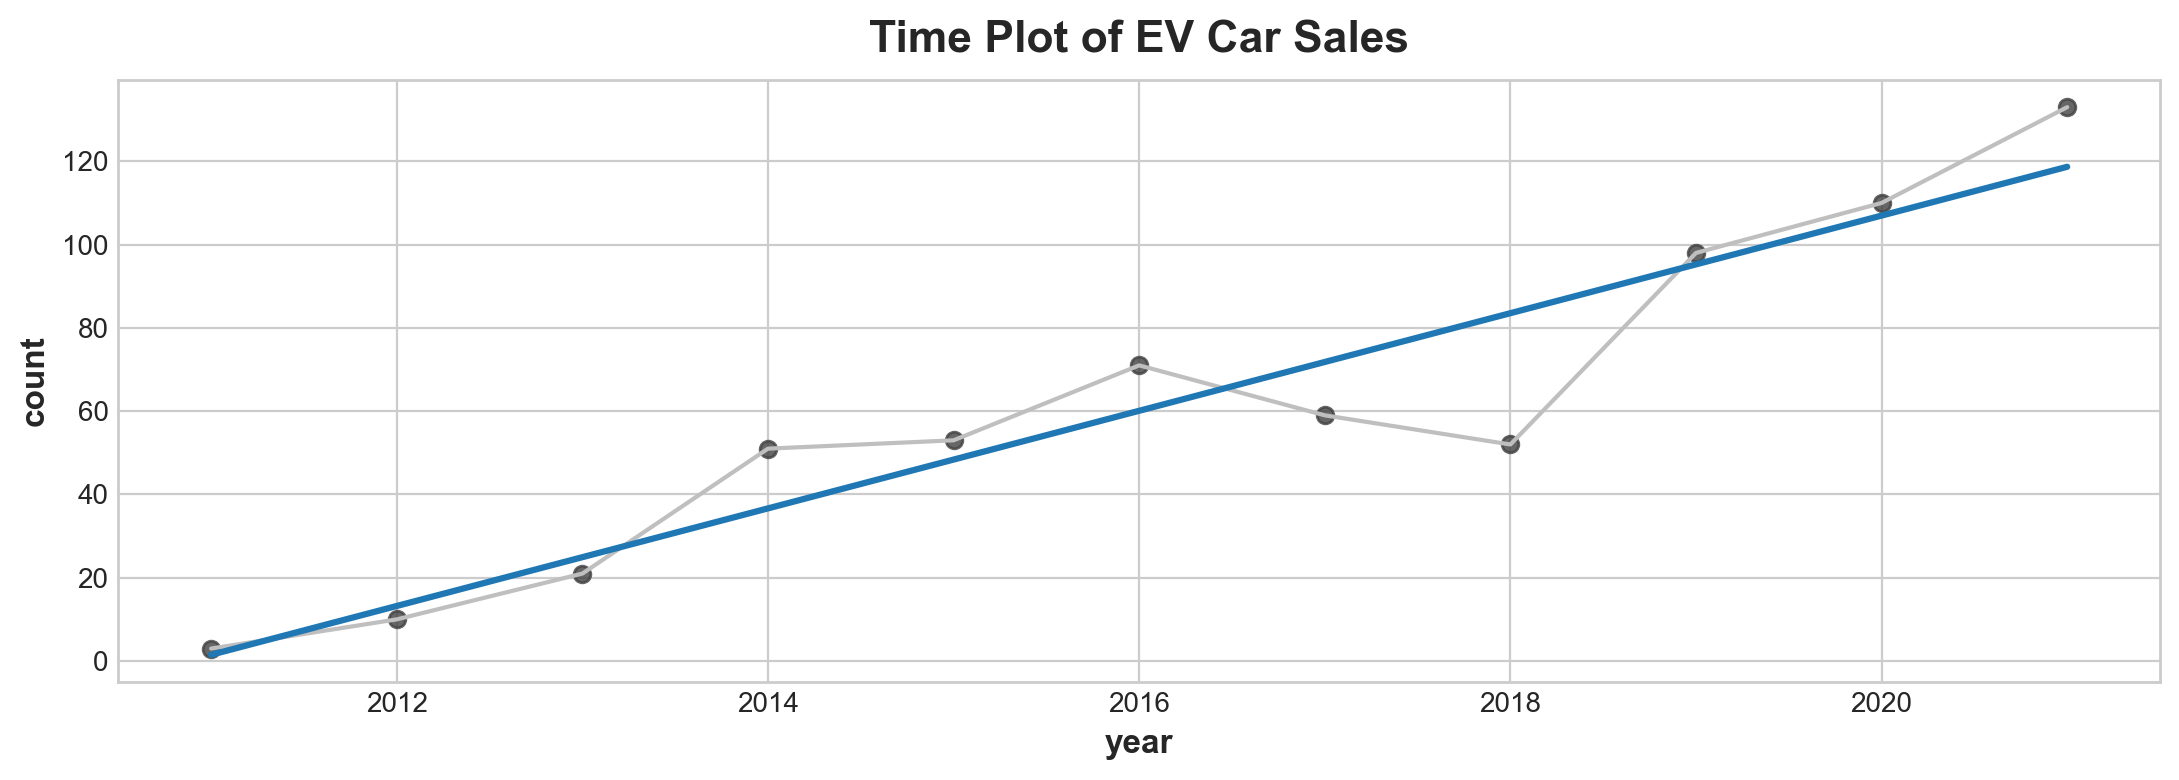

In [96]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('year', 'count', data=ev, color='0.75')
ax = sns.regplot(x='year', y='count', data=ev, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of EV Car Sales')

## LAG Feature

In [97]:
ev_copy1 = ev.copy()


ev_copy1['Lag_1'] = ev_copy1['count'].shift(1)
df = ev_copy1.reindex(columns=['count', 'Lag_1'])

df.head()

count  Lag_1
0      3    NaN
1     10    3.0
2     21   10.0
3     51   21.0
4     53   51.0

In [98]:
ev_copy1.head()

year  count  Lag_1
0  2011      3    NaN
1  2012     10    3.0
2  2013     21   10.0
3  2014     51   21.0
4  2015     53   51.0

Text(0.5, 1.0, 'Lag Plot of EV Car Sales')

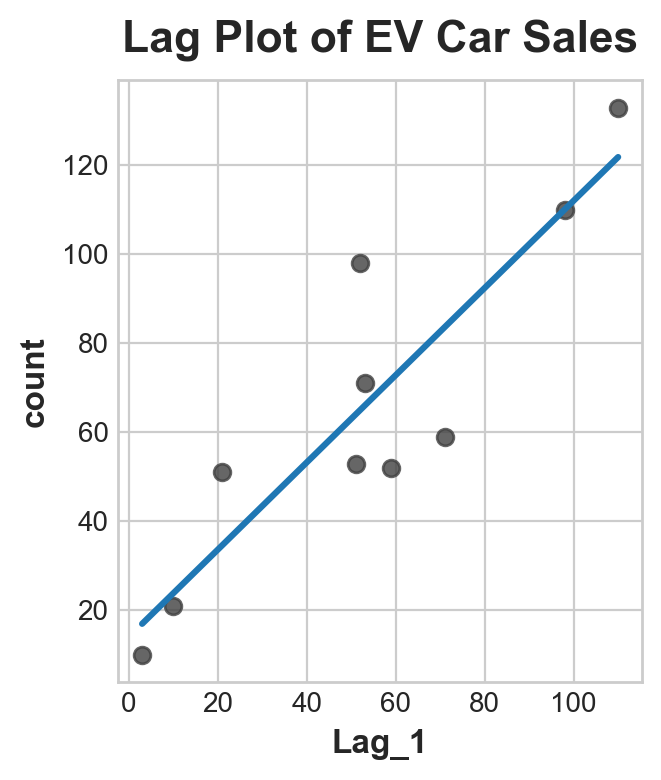

In [99]:
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='count', data=ev_copy1, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of EV Car Sales')

## ARIMA

In [100]:
ev_copy2 = ev.copy()

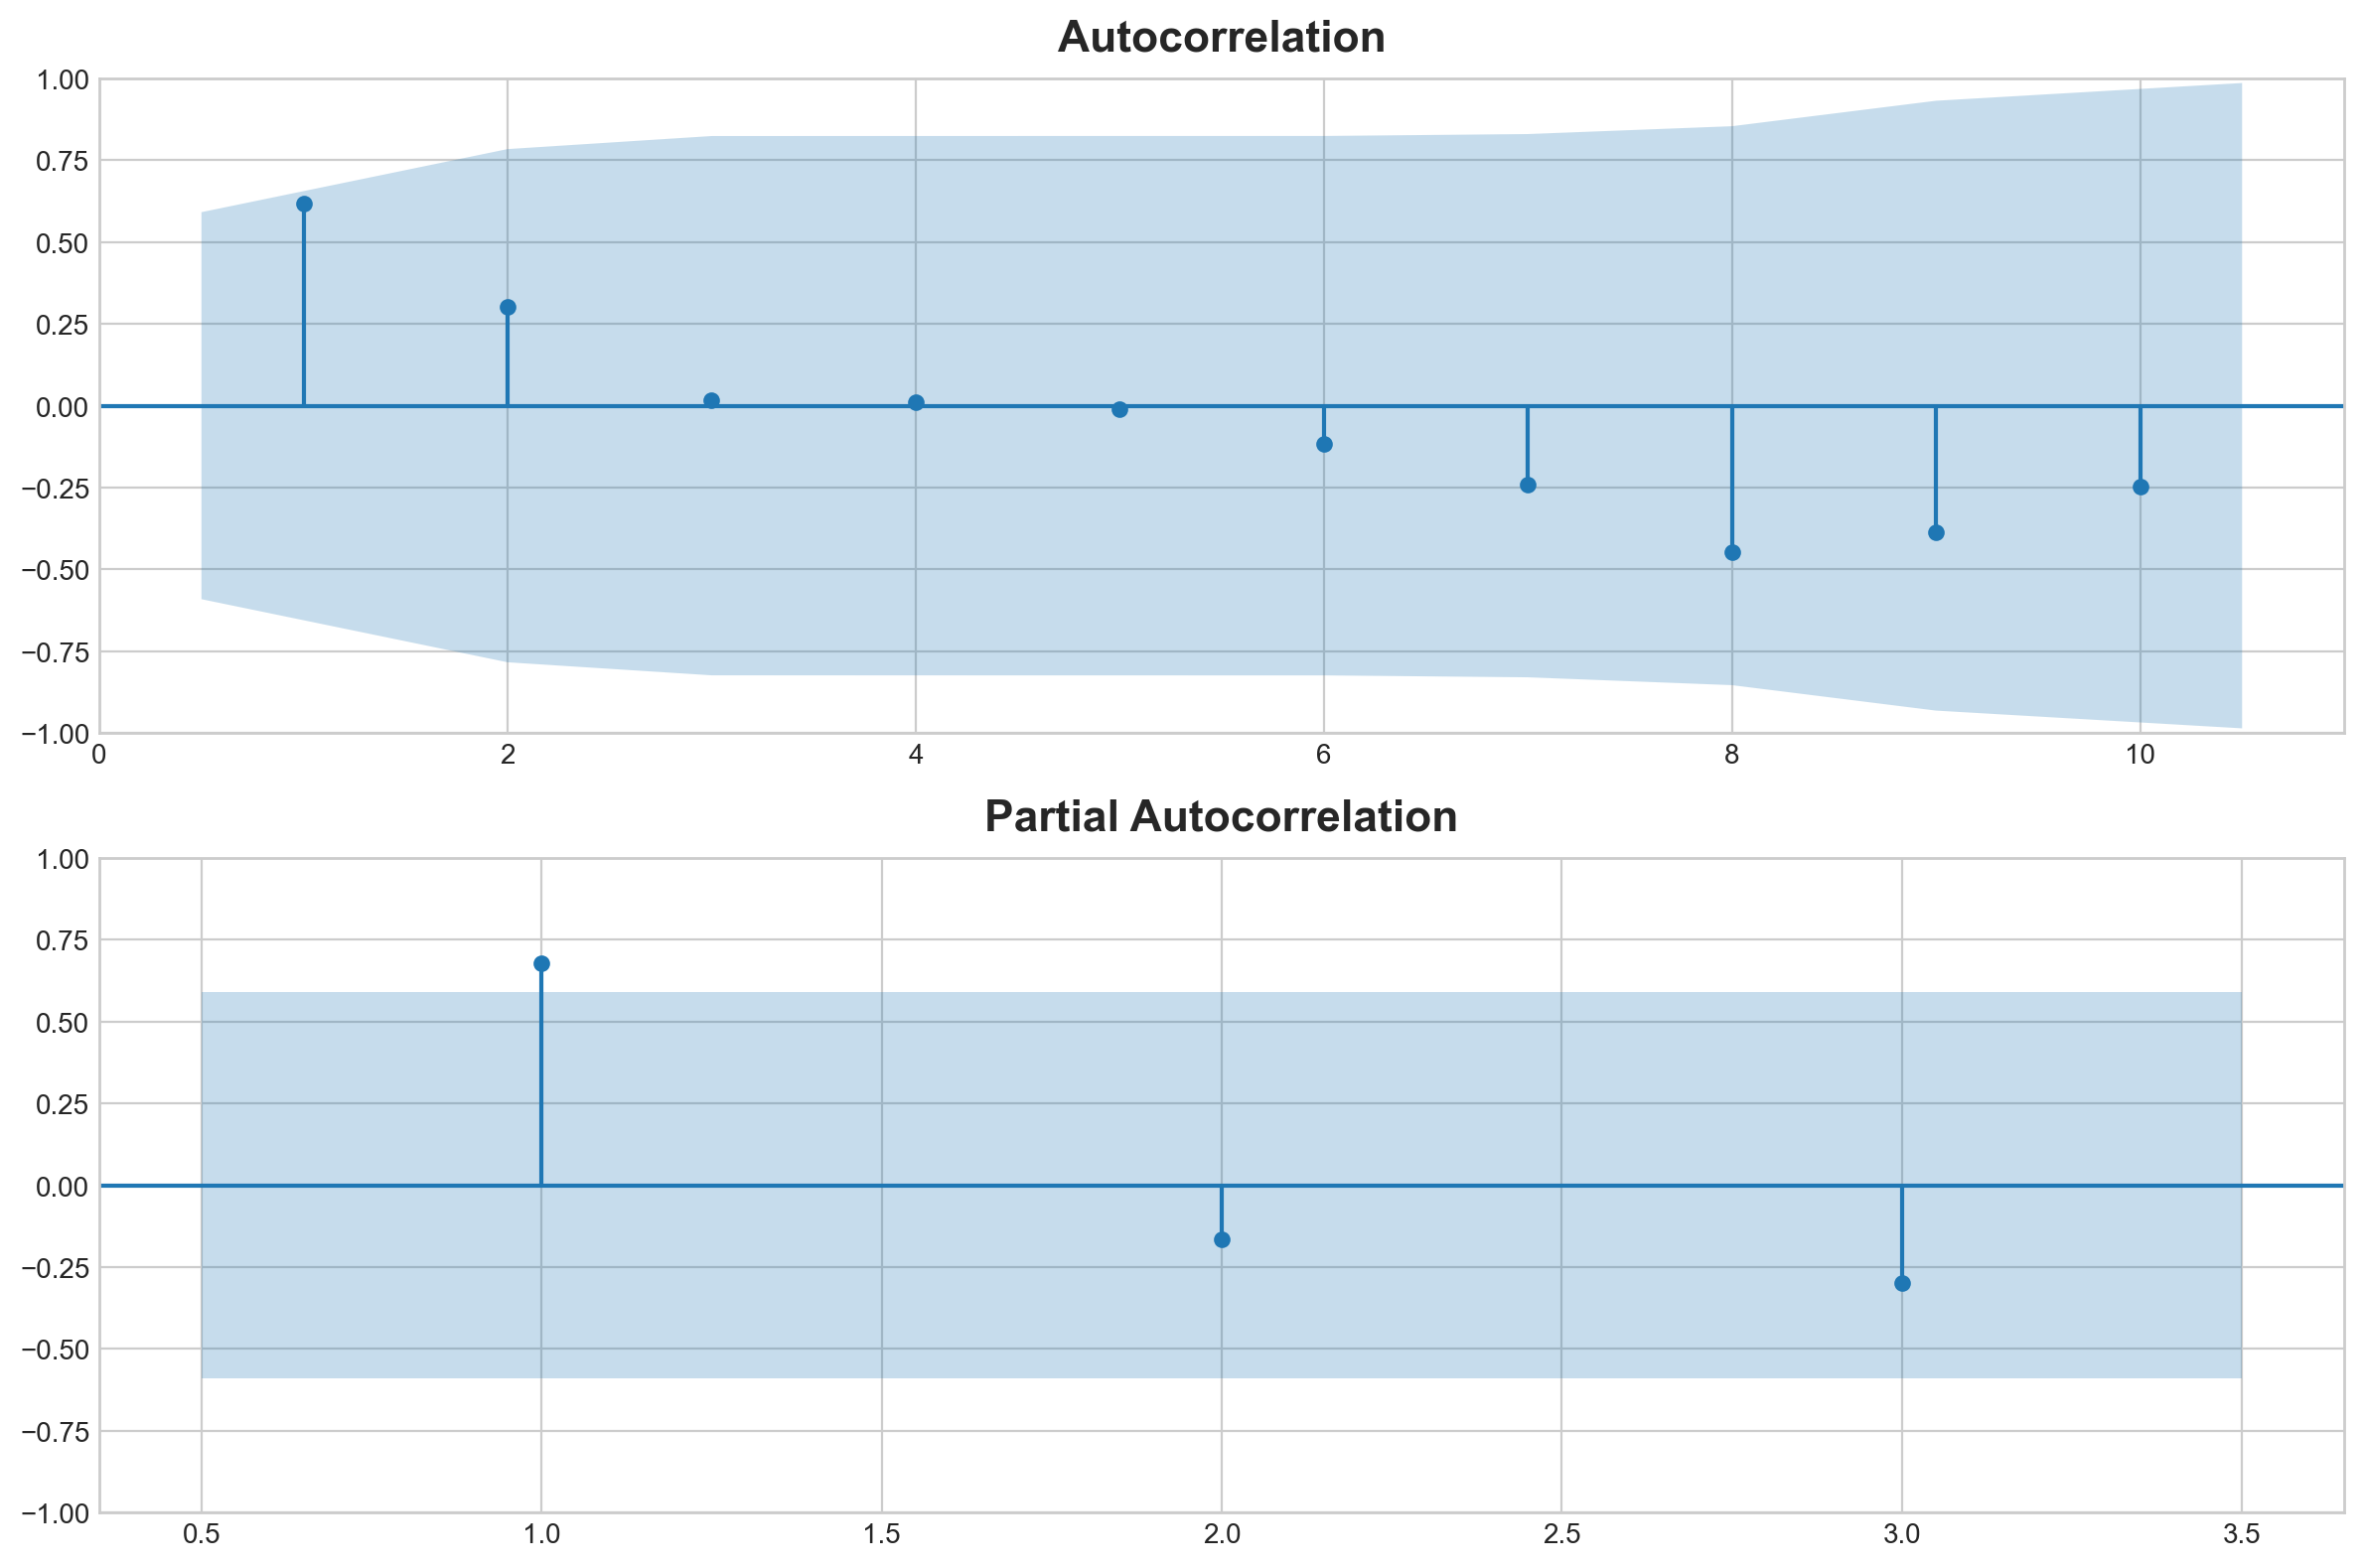

'Non-Stationary	 p-value:0.9483013595647575 	lags:0


('Non-Stationary', 0.9483013595647575)

In [101]:

fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(ev_copy2["count"], zero=False, ax=ax[0])
plot_pacf(ev_copy2["count"], zero=False, lags=3,ax=ax[1])
plt.show()

check_stationarity(ev_copy2["count"])

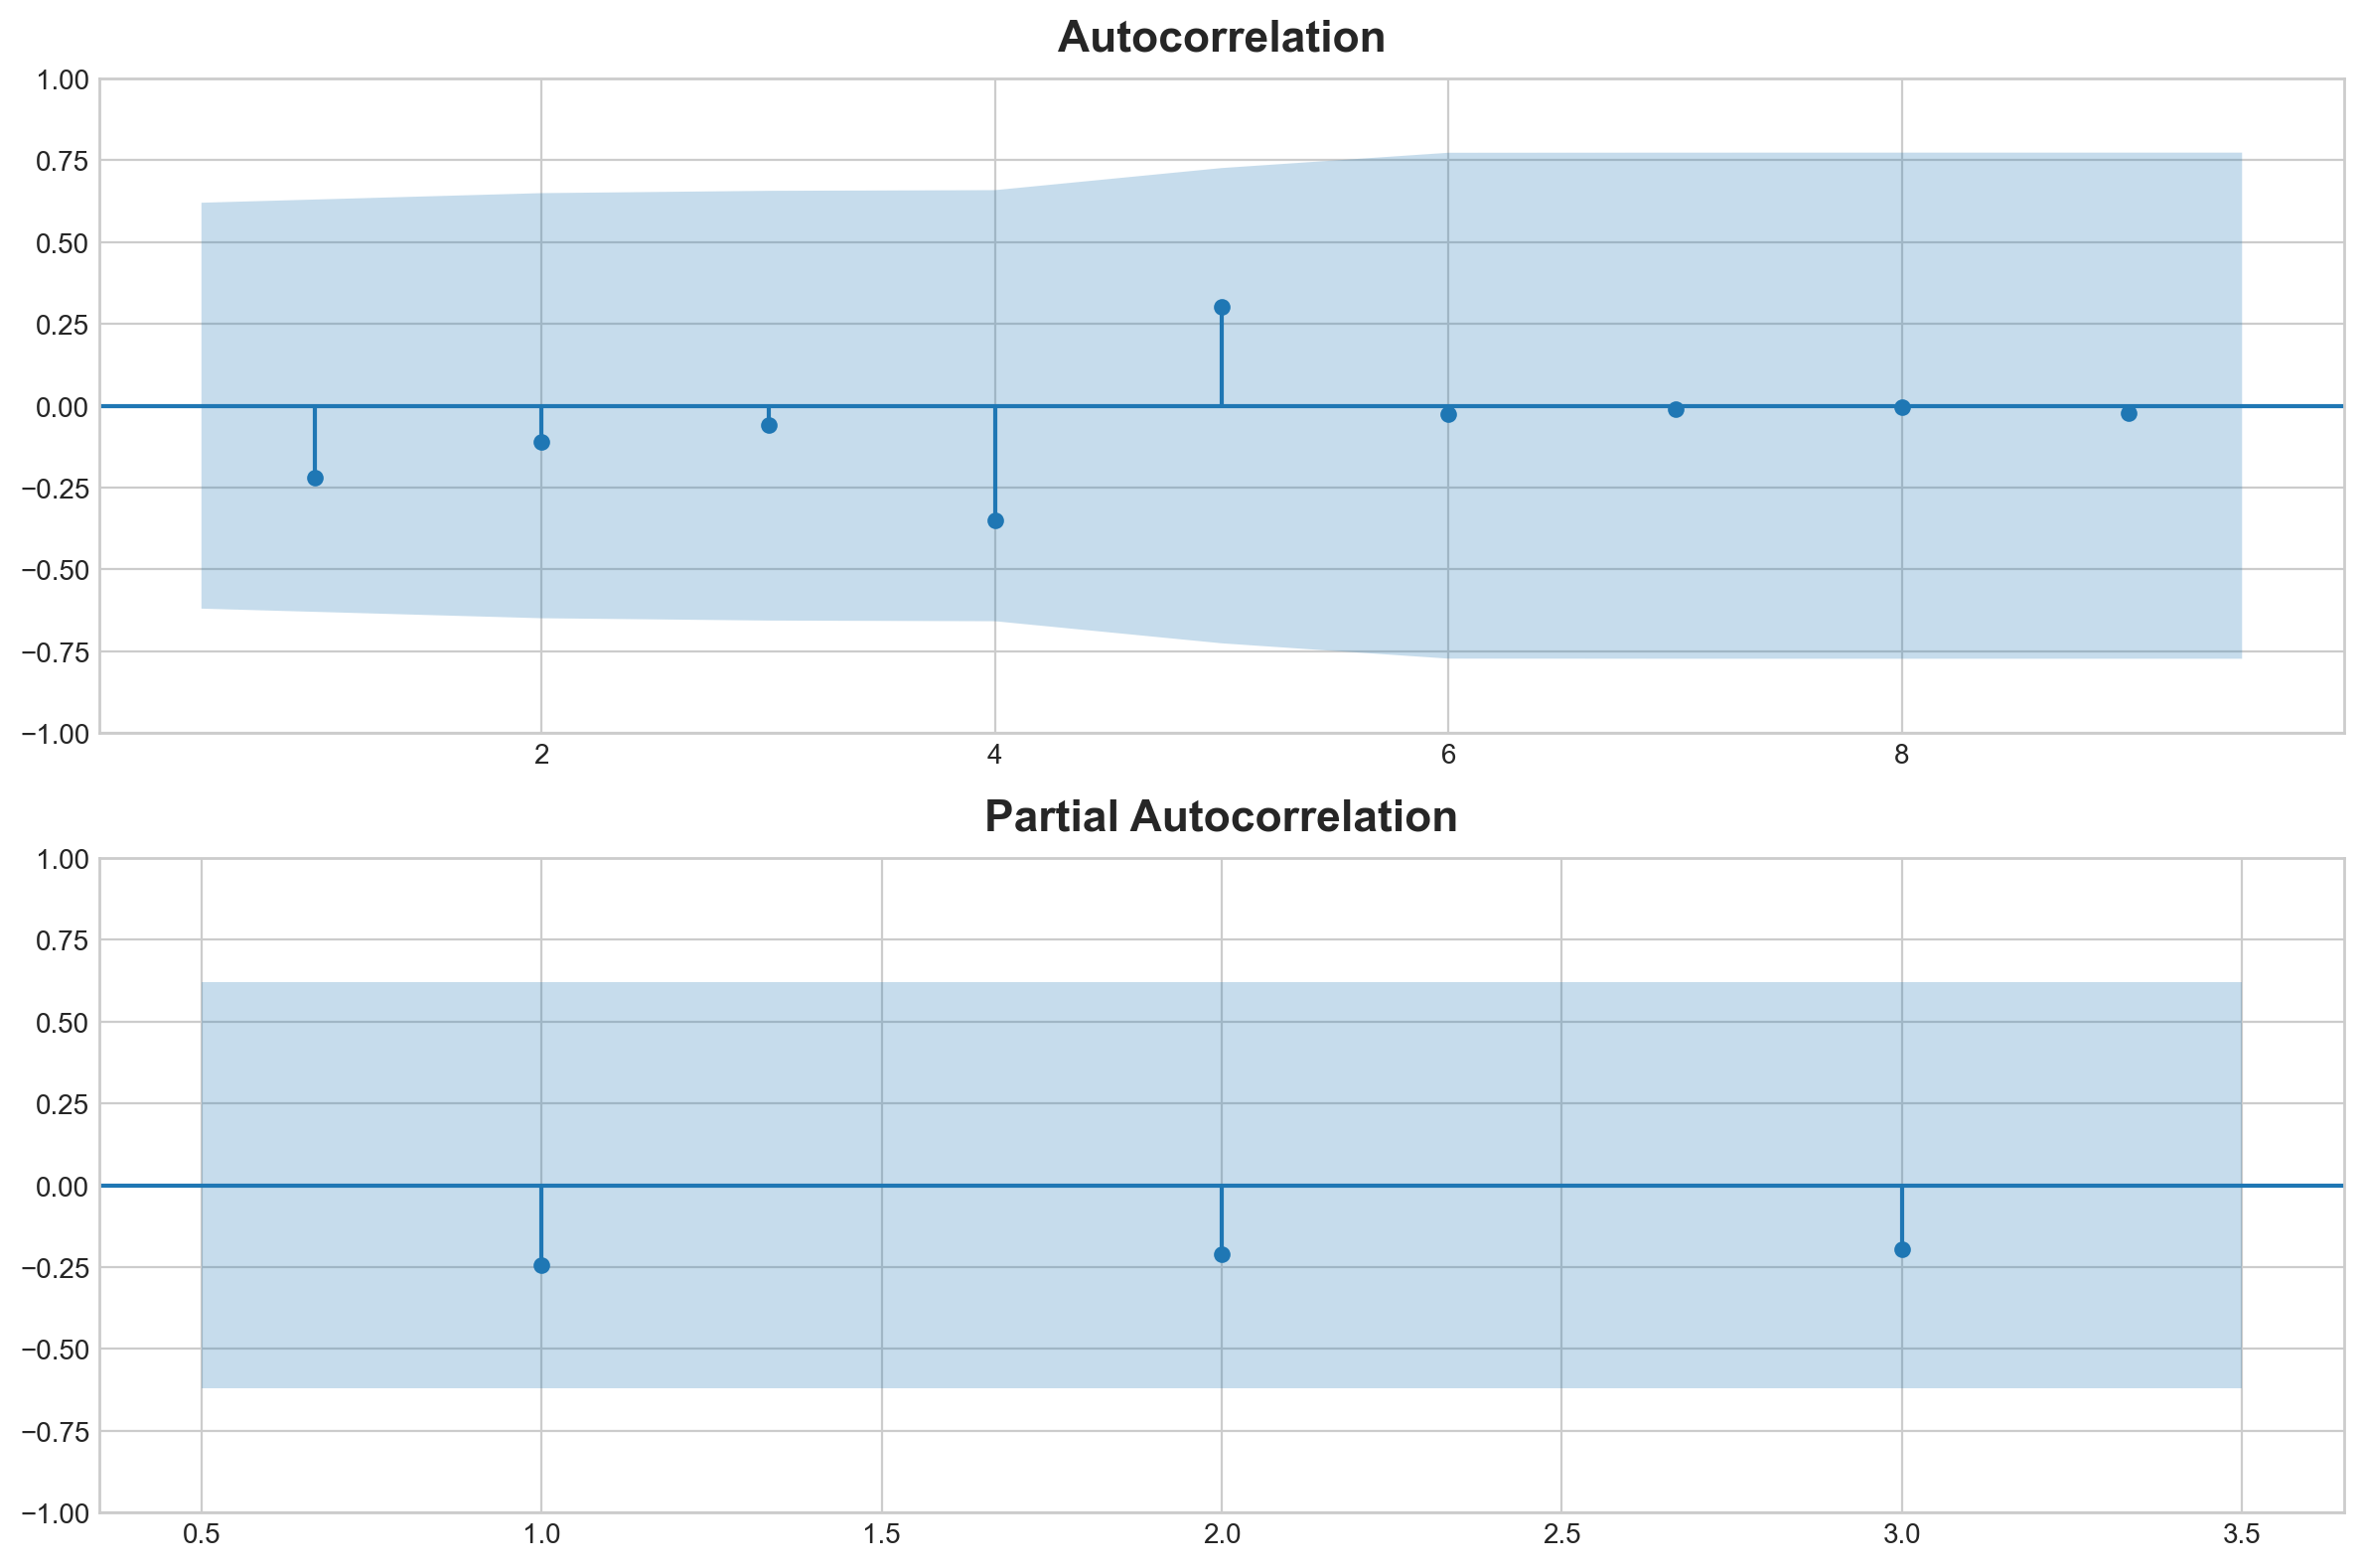

'Stationary	 p-value:0.02669725492442869 	lags:3


('Stationary', 0.02669725492442869)

In [102]:
#1st order
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(ev_copy2["count"].diff().dropna(), zero=False, ax=ax[0])
plot_pacf(ev_copy2["count"].diff().dropna(), zero=False, lags=3,ax=ax[1])
plt.show()

check_stationarity(ev_copy2["count"].diff().dropna())

In [103]:
ev_copy2 = ev_copy2.set_index("year")
ev_copy2

count
year       
2011      3
2012     10
2013     21
2014     51
2015     53
2016     71
2017     59
2018     52
2019     98
2020    110
2021    133

In [104]:
y_train, y_test = temporal_train_test_split(ev_copy2, test_size=2)
fh = ForecastingHorizon(y_test.index, is_relative=False)

0.14506684722908902

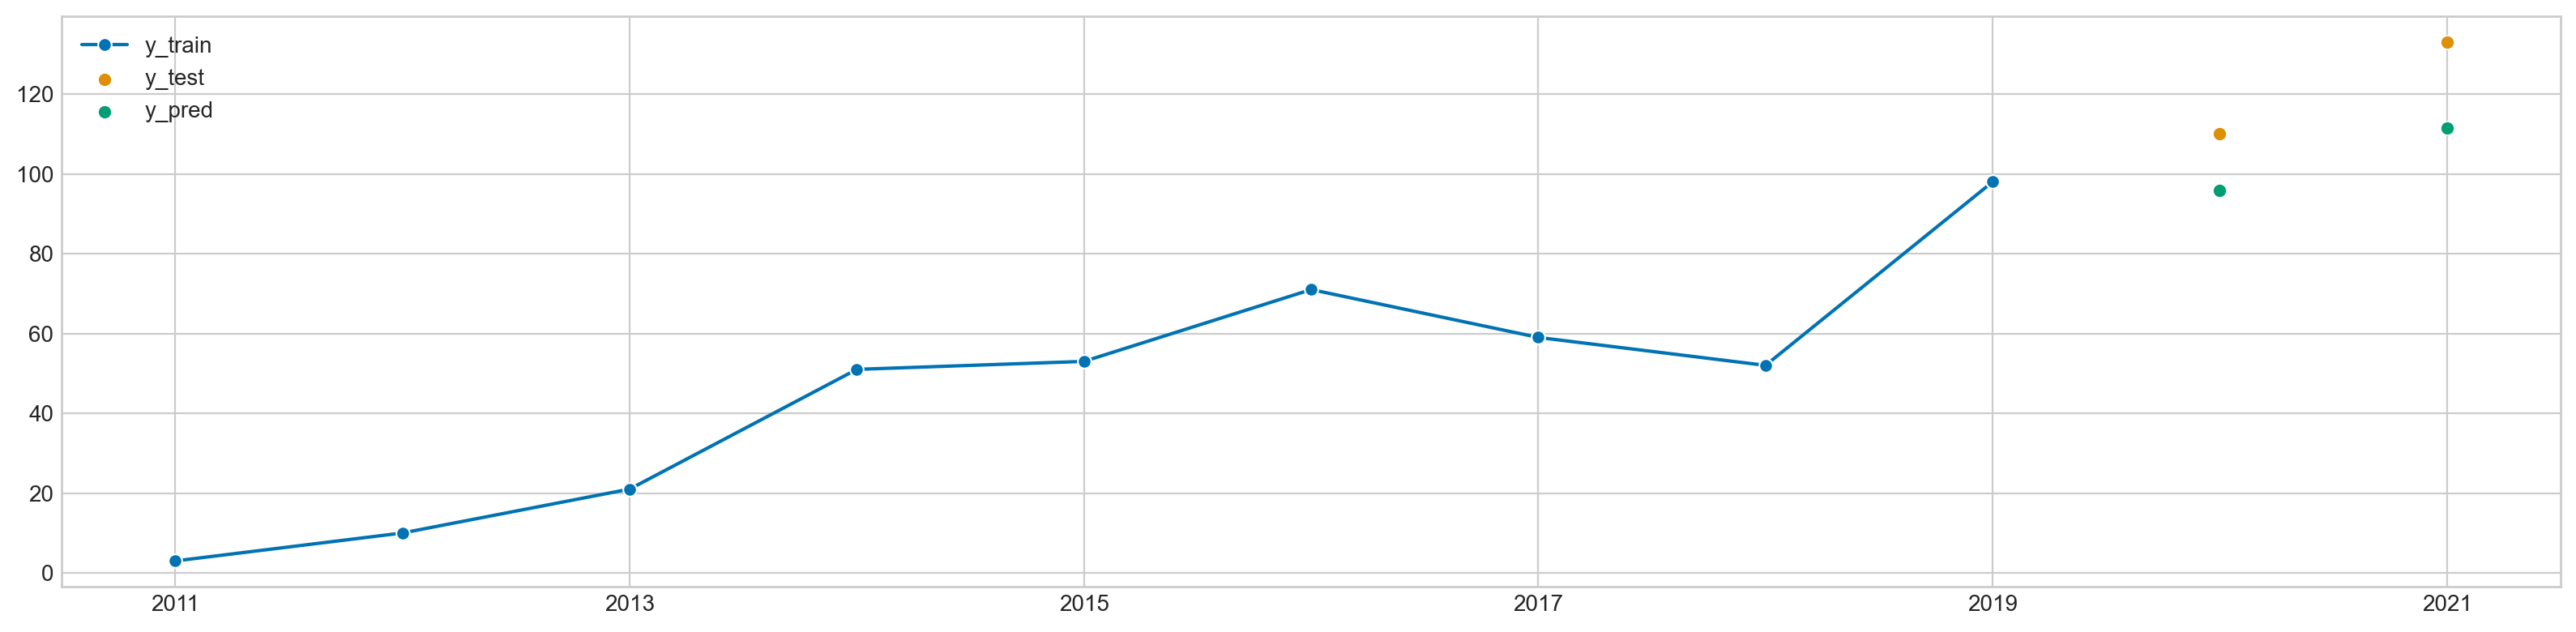

In [105]:
forecaster = ARIMA(order=(1, 1, 0),  suppress_warnings=True)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In [106]:
y_pred

count
2020   95.894959
2021  111.466496

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: >)

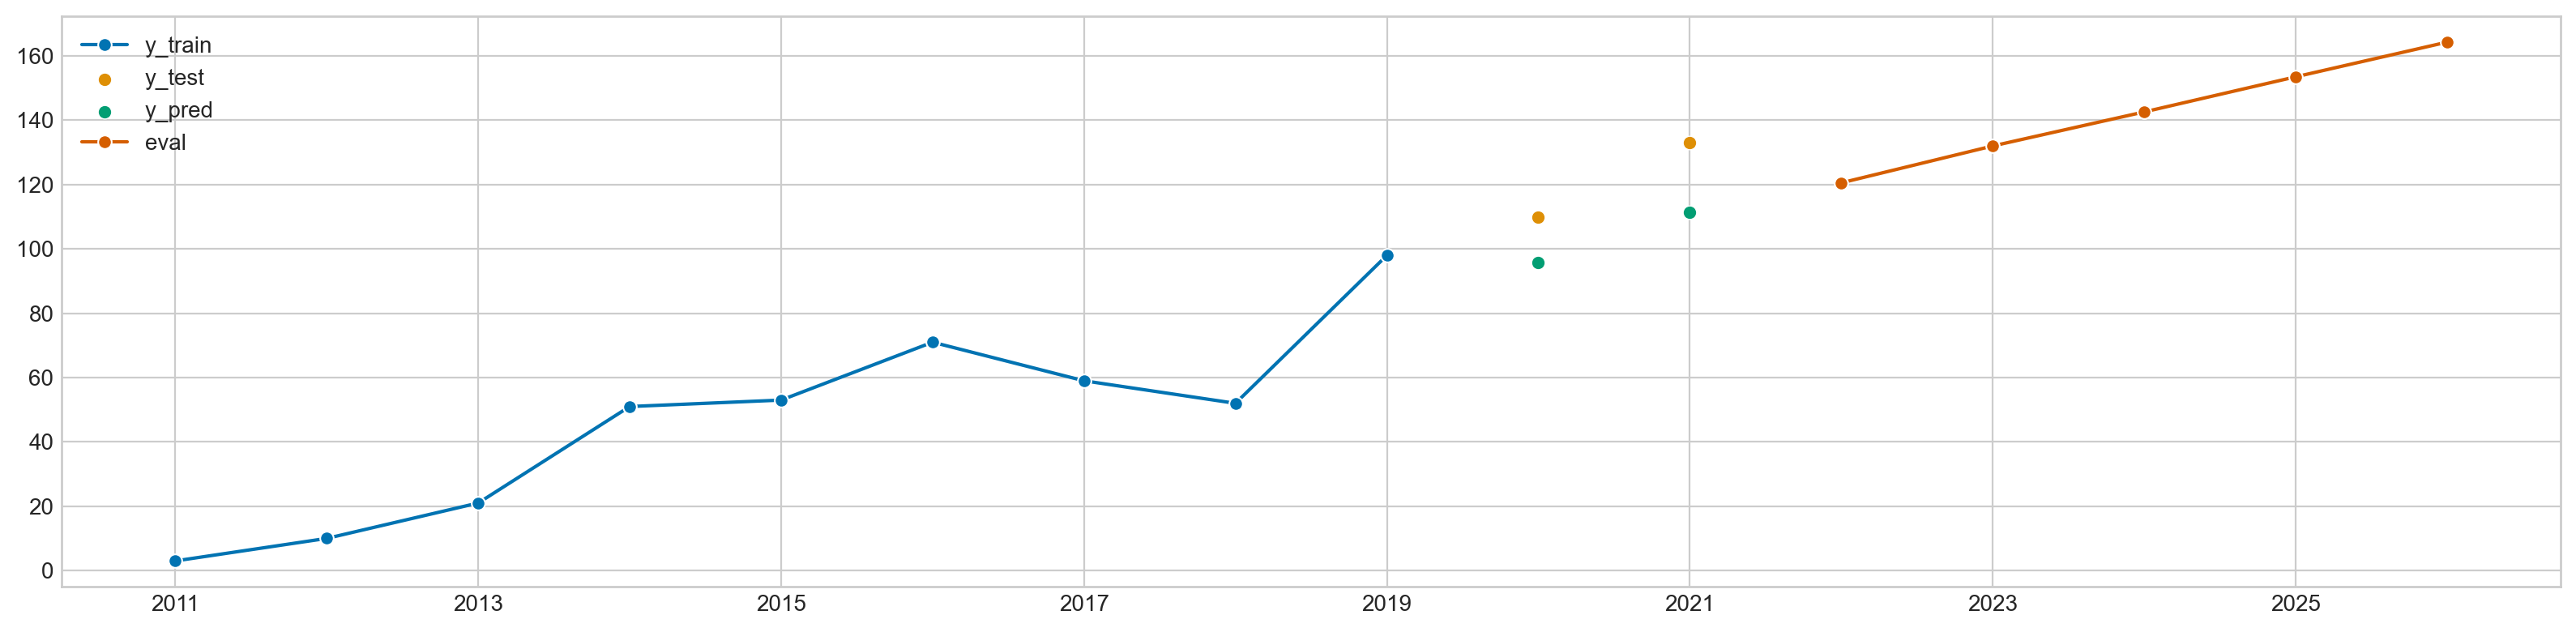

In [107]:
y_pred_eval = forecaster.predict(new_fh)
plot_series(y_train, y_test, y_pred,y_pred_eval,  labels=["y_train", "y_test","y_pred", "eval"])

## **Exponential Smoothing**

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

0.1599396342643268

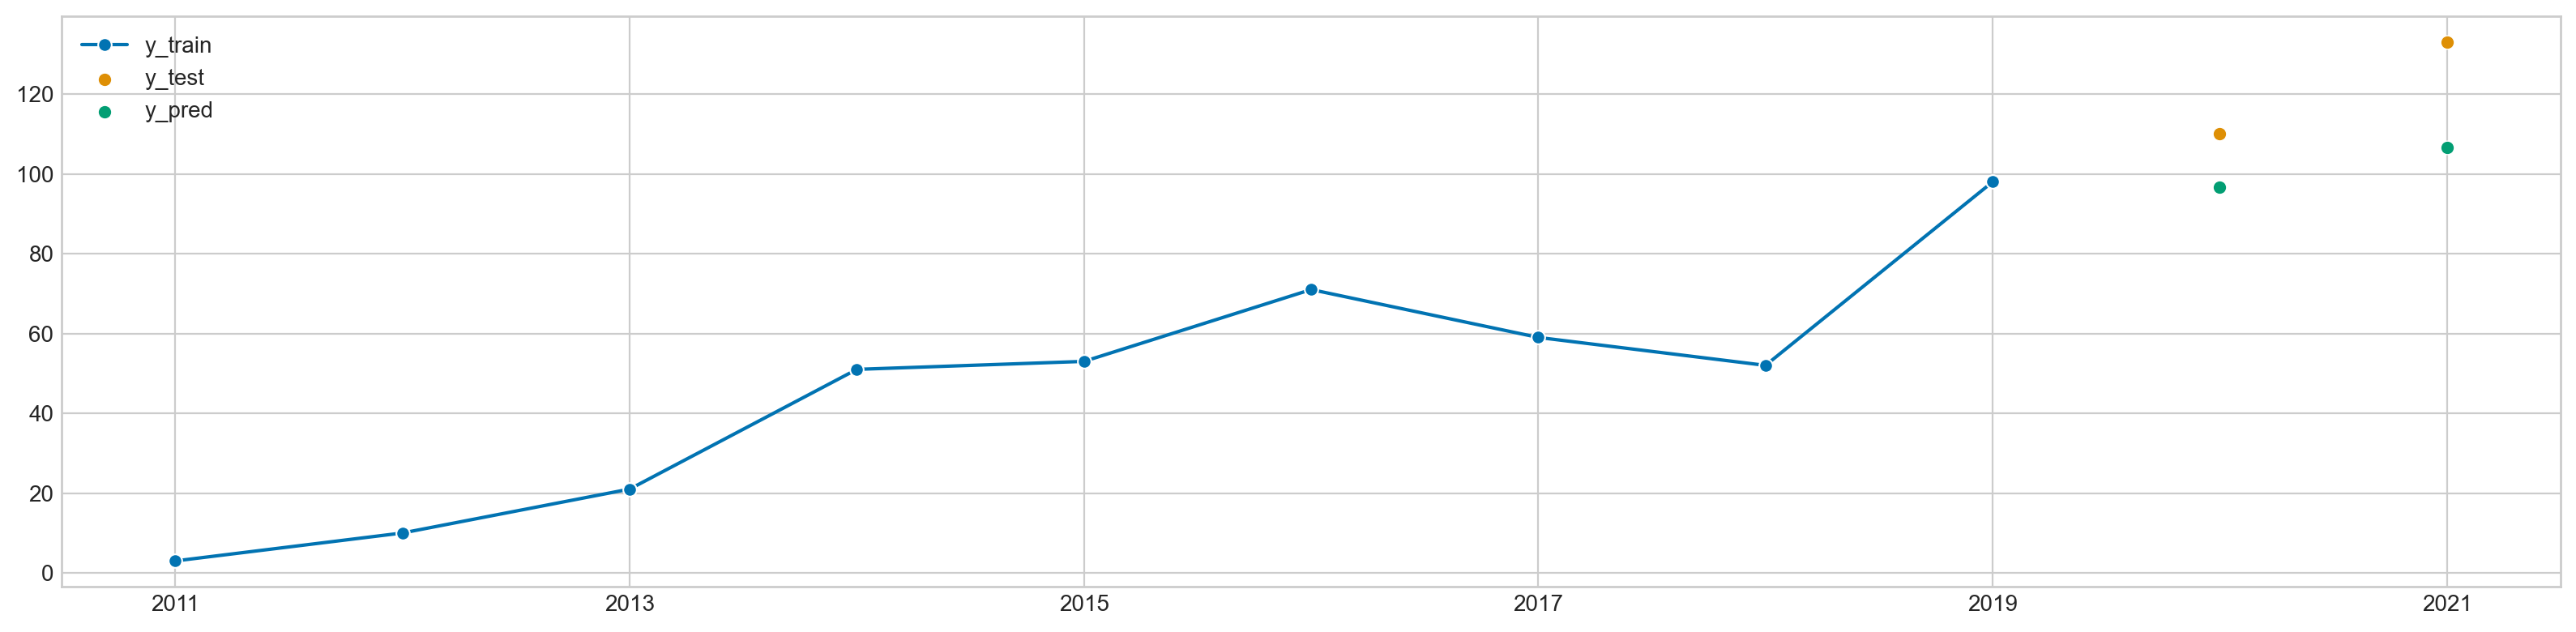

In [143]:
forecaster = ExponentialSmoothing(trend="add")

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: >)

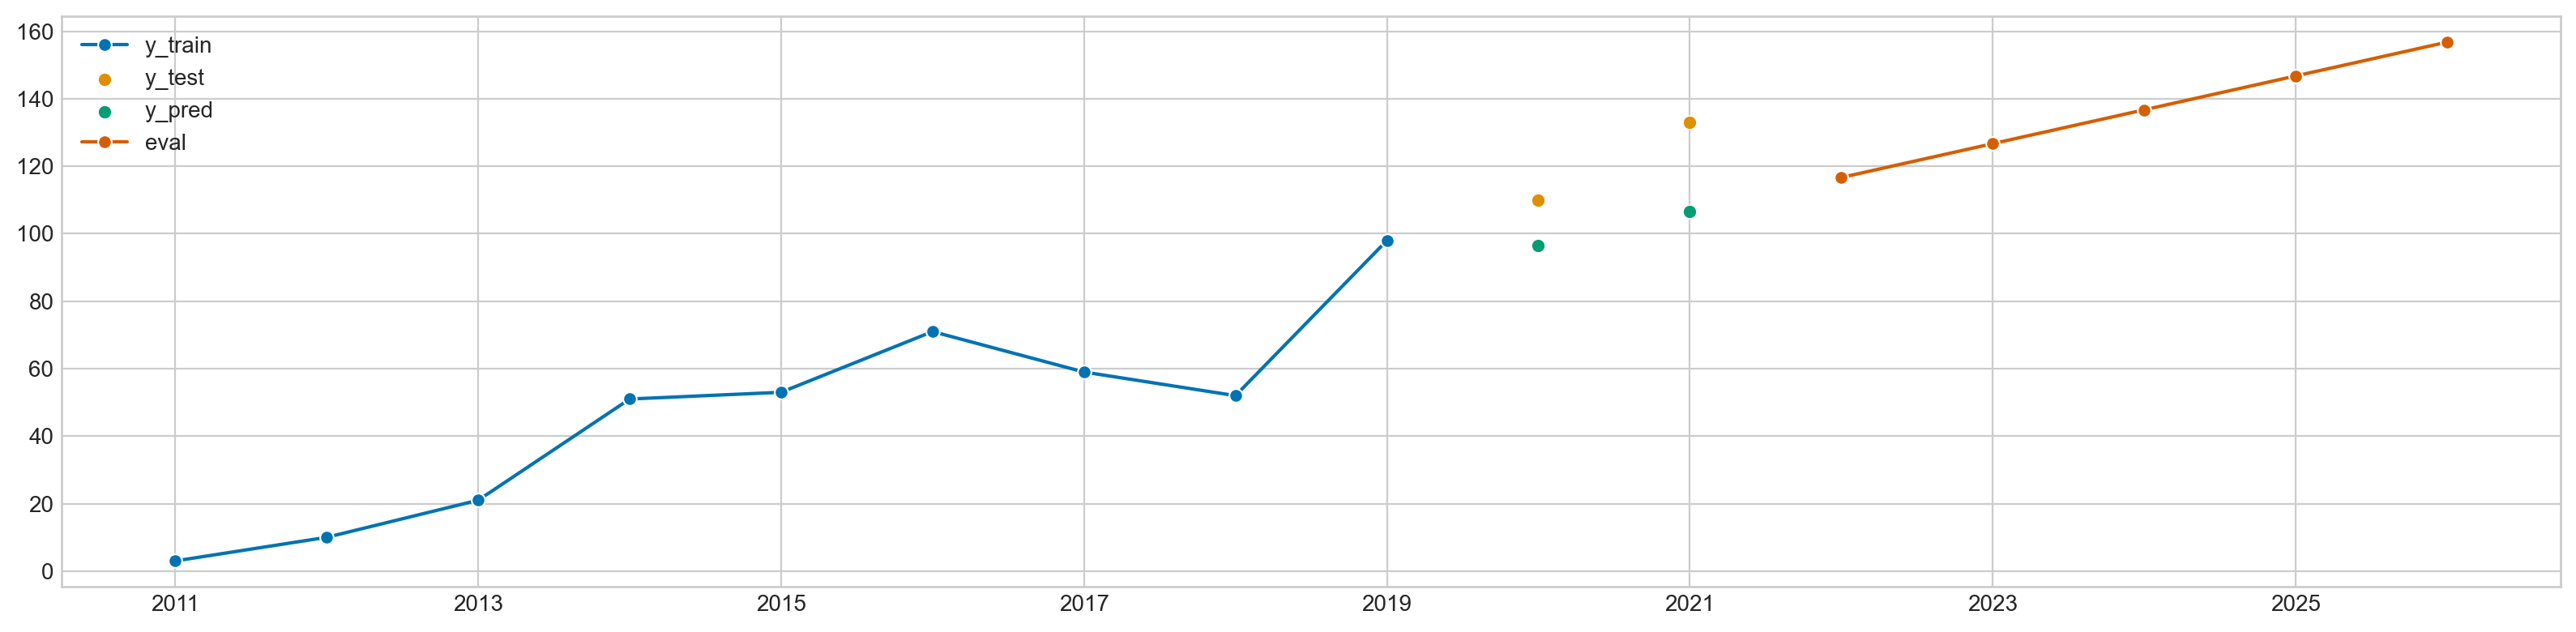

In [144]:
y_pred_eval = forecaster.predict(new_fh)
plot_series(y_train, y_test, y_pred,y_pred_eval,  labels=["y_train", "y_test", "y_pred", "eval"])

## **MACHINE LEARNING**

In [108]:
ev_copy3 = ev.copy()
ev_copy3

year  count
0   2011      3
1   2012     10
2   2013     21
3   2014     51
4   2015     53
5   2016     71
6   2017     59
7   2018     52
8   2019     98
9   2020    110
10  2021    133

In [109]:
ev_copy3 = ev_copy3.set_index("year")

In [110]:
ev_os = one_step_forecast(ev_copy3, 3)
print(ev_os.shape)

(8, 4)


In [111]:
ev_os

x_1  x_2  x_3    y
year                    
2011    3   10   21   51
2012   10   21   51   53
2013   21   51   53   71
2014   51   53   71   59
2015   53   71   59   52
2016   71   59   52   98
2017   59   52   98  110
2018   52   98  110  133

In [112]:
train, test = split_data(ev_os)
print(f'Train: {len(train)} Test: {len(test)}')

Train: 6 Test: 2


In [113]:
scaler = Standardize()
train_s, test_s = scaler.fit_transform(train, test)
train_s.head()

x_1       x_2       x_3         y
year                                        
2011 -1.166936 -1.451908 -1.823211 -0.712610
2012 -0.910332 -0.984465 -0.010073 -0.602977
2013 -0.507098  0.290382  0.110803  0.383713
2014  0.592632  0.375371  1.198686 -0.274081
2015  0.665948  1.140279  0.473431 -0.657794

In [114]:
y_train_original = scaler.inverse_y(train_s['y'])

In [115]:
train_original = scaler.inverse(train_s)
train_original.head()

x_1   x_2   x_3     y
year                        
2011   3.0  10.0  21.0  51.0
2012  10.0  21.0  51.0  53.0
2013  21.0  51.0  53.0  71.0
2014  51.0  53.0  71.0  59.0
2015  53.0  71.0  59.0  52.0

In [116]:
ev_results = train_different_models(train_s, test_s, regressors)

training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...


In [118]:
cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
ev_results = pd.DataFrame(ev_results)
ev_results[cols].sort_values('MASE')

Model Name      RMSE      MAPE      MASE
1        Elastic Net  3.043208  0.938021  3.187696
3   Lasso Regression  3.206261  0.997083  3.373191
2   Ridge Regression  3.548213  1.088914  3.708438
0  Linear Regression  3.822980  1.149755  3.952869
4   Huber Regression  3.869271  1.161477  3.996568

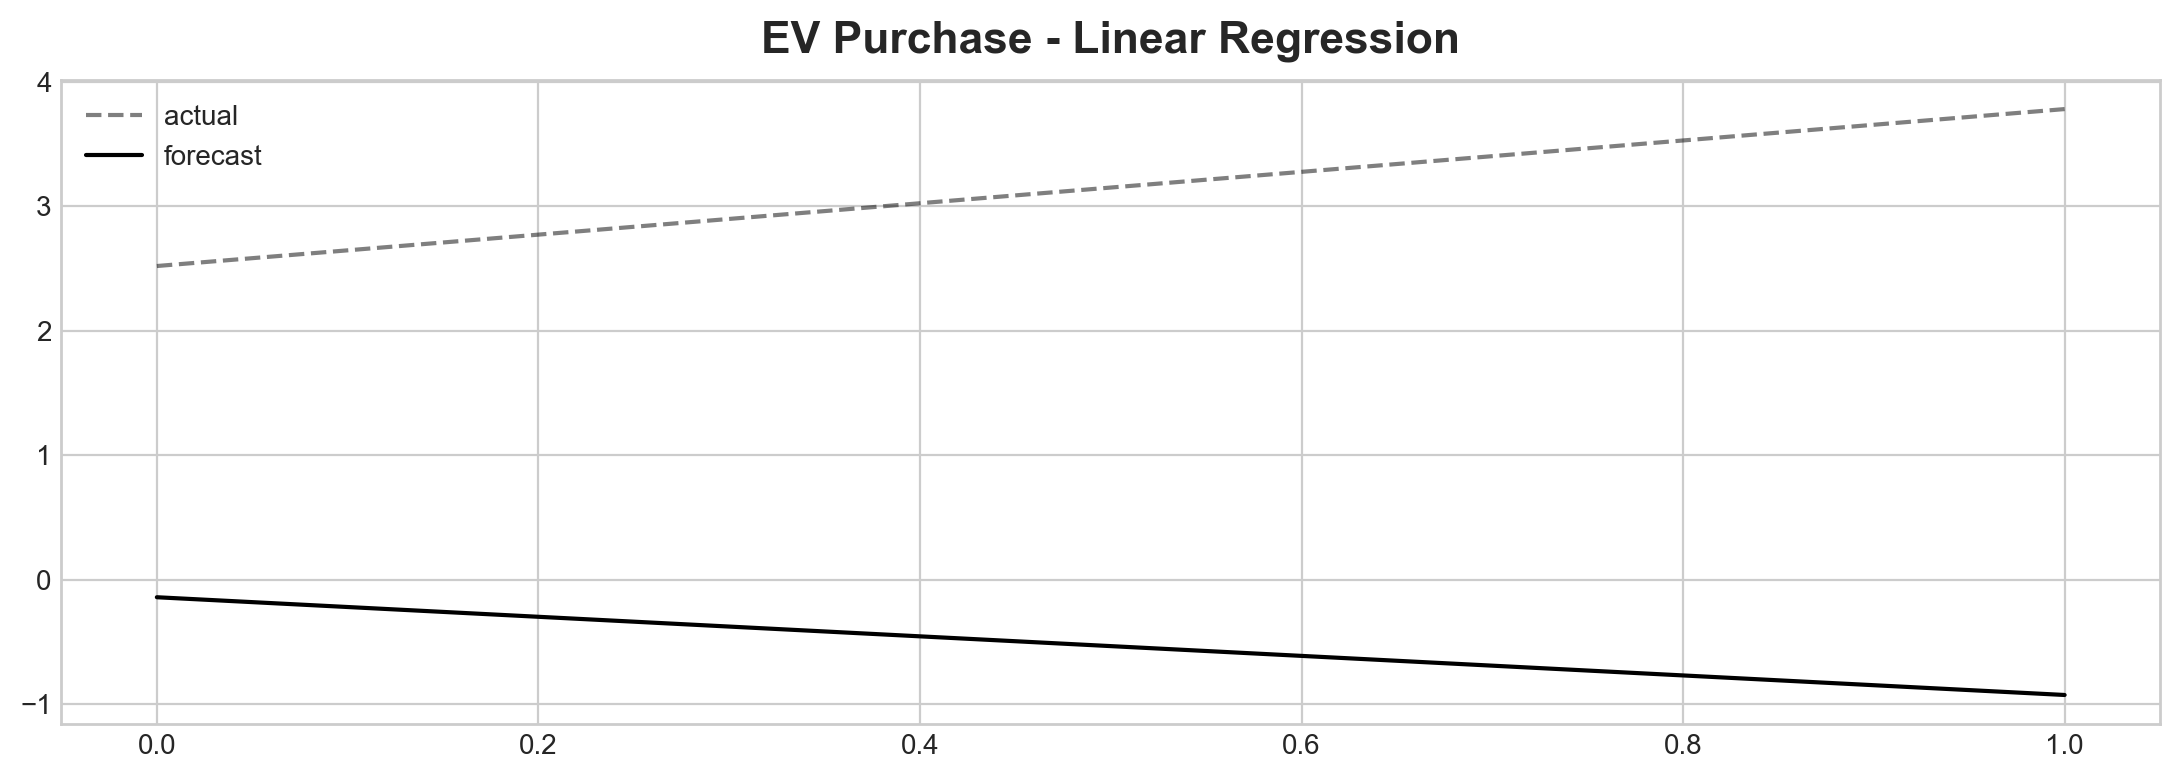

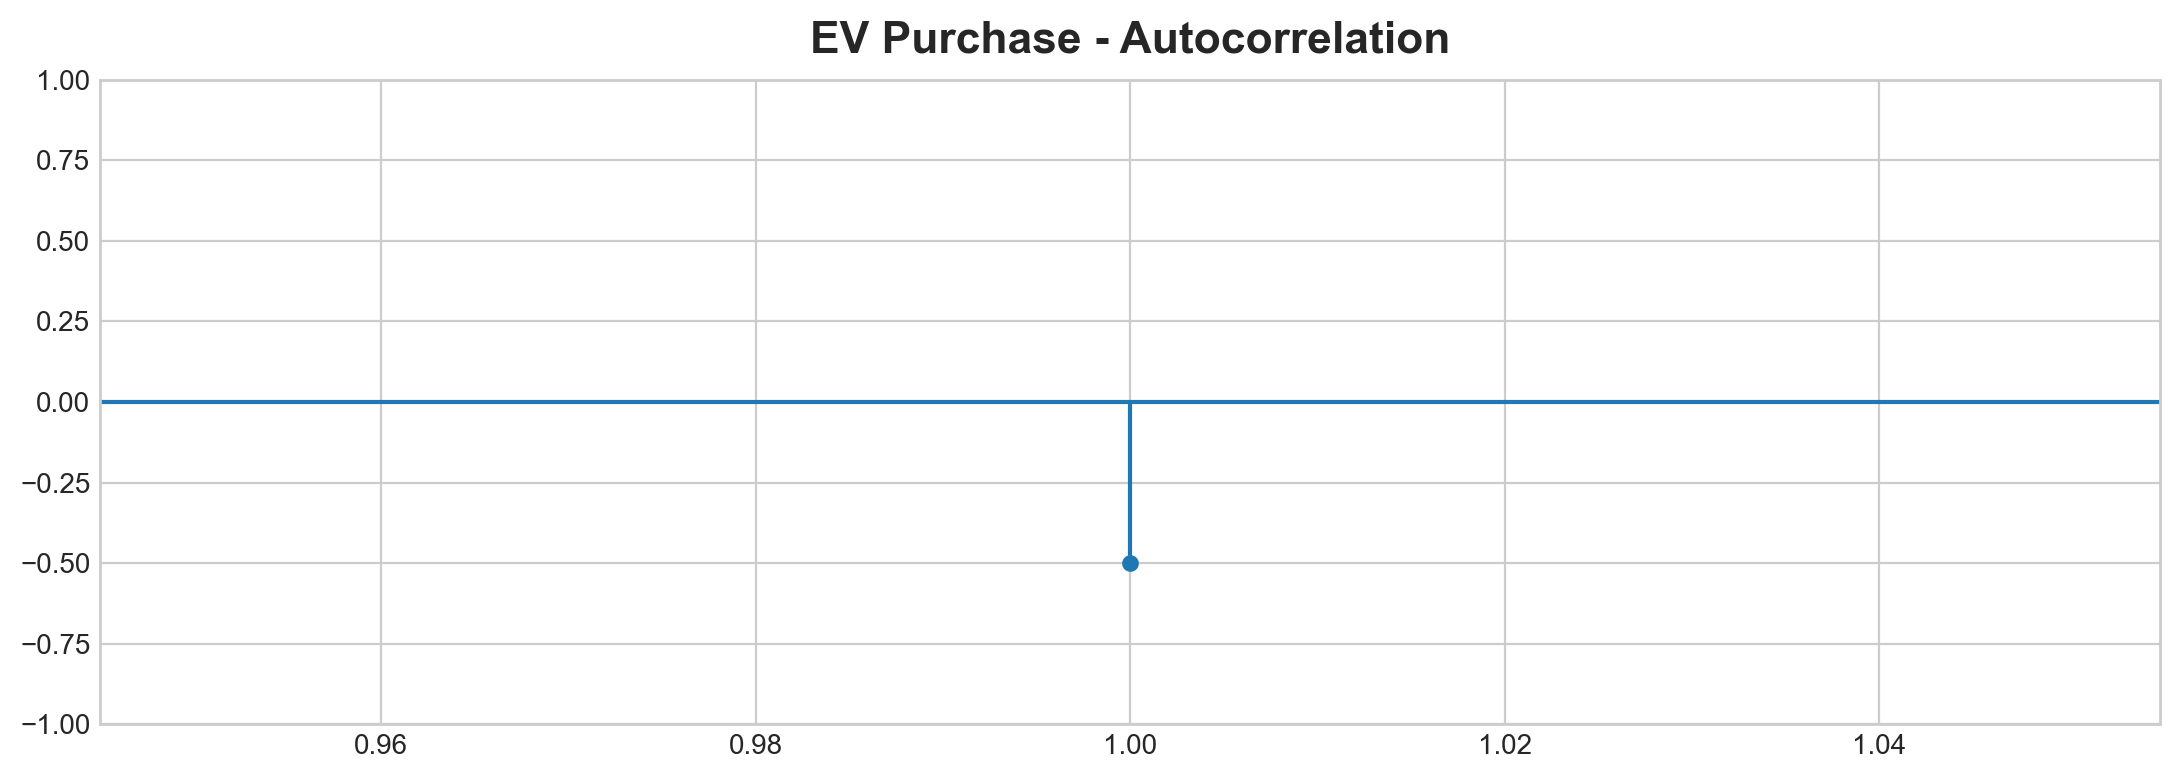

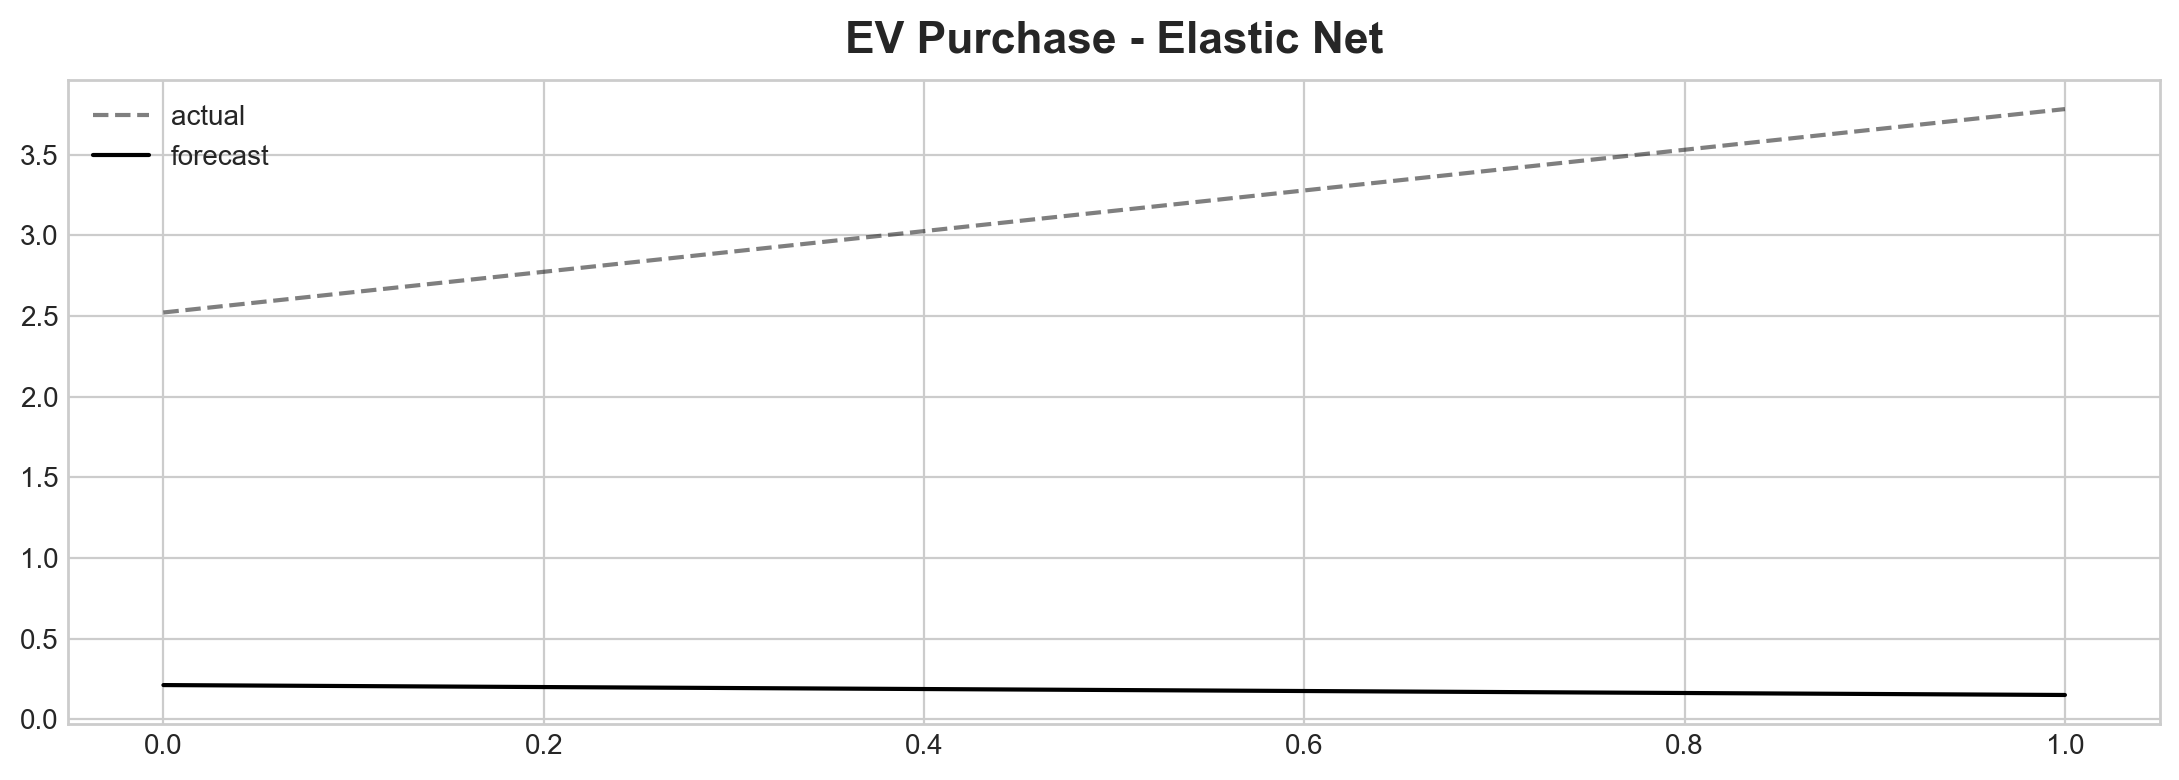

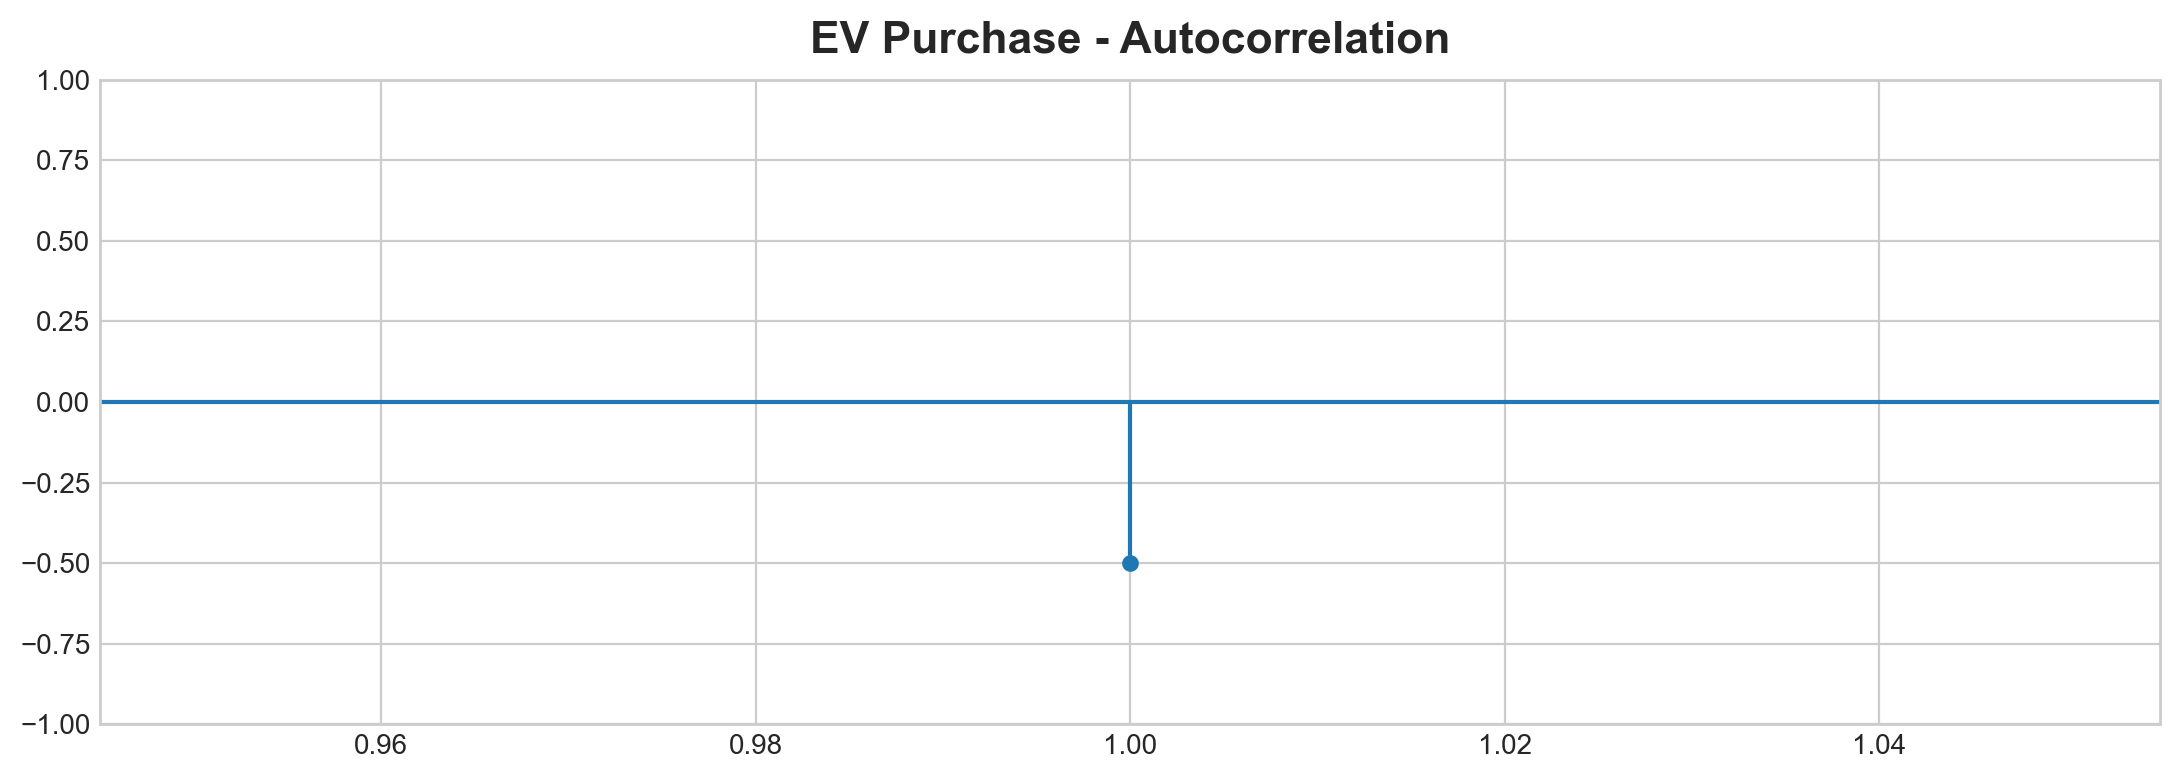

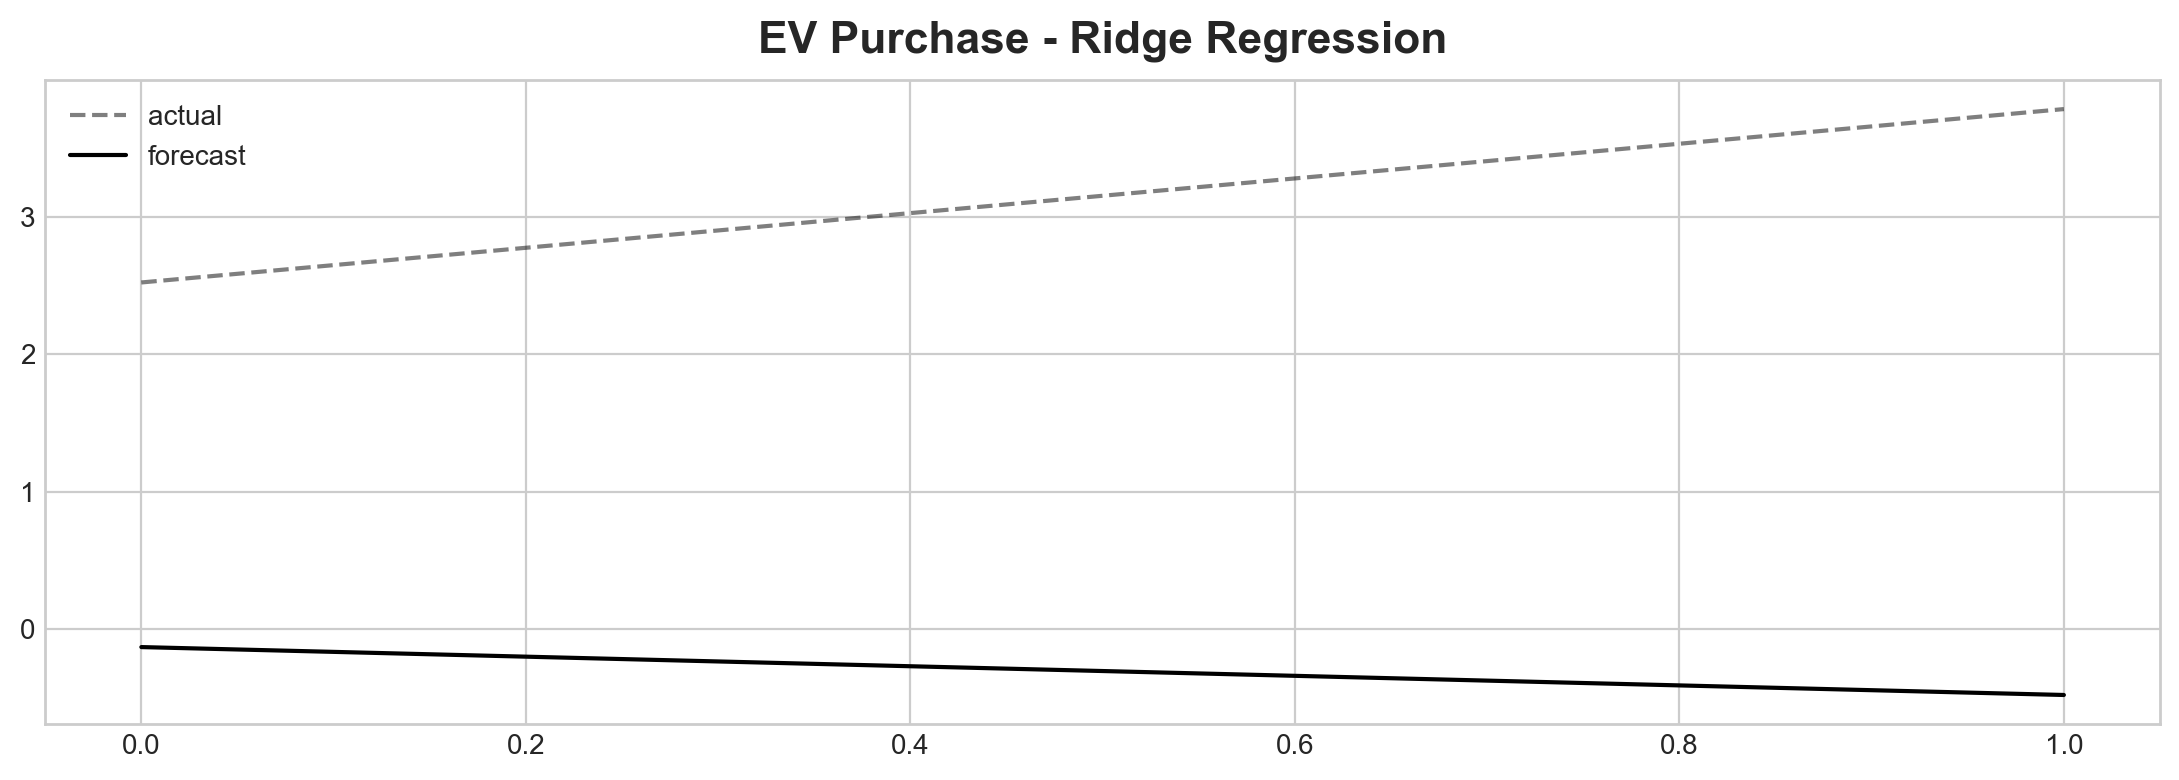

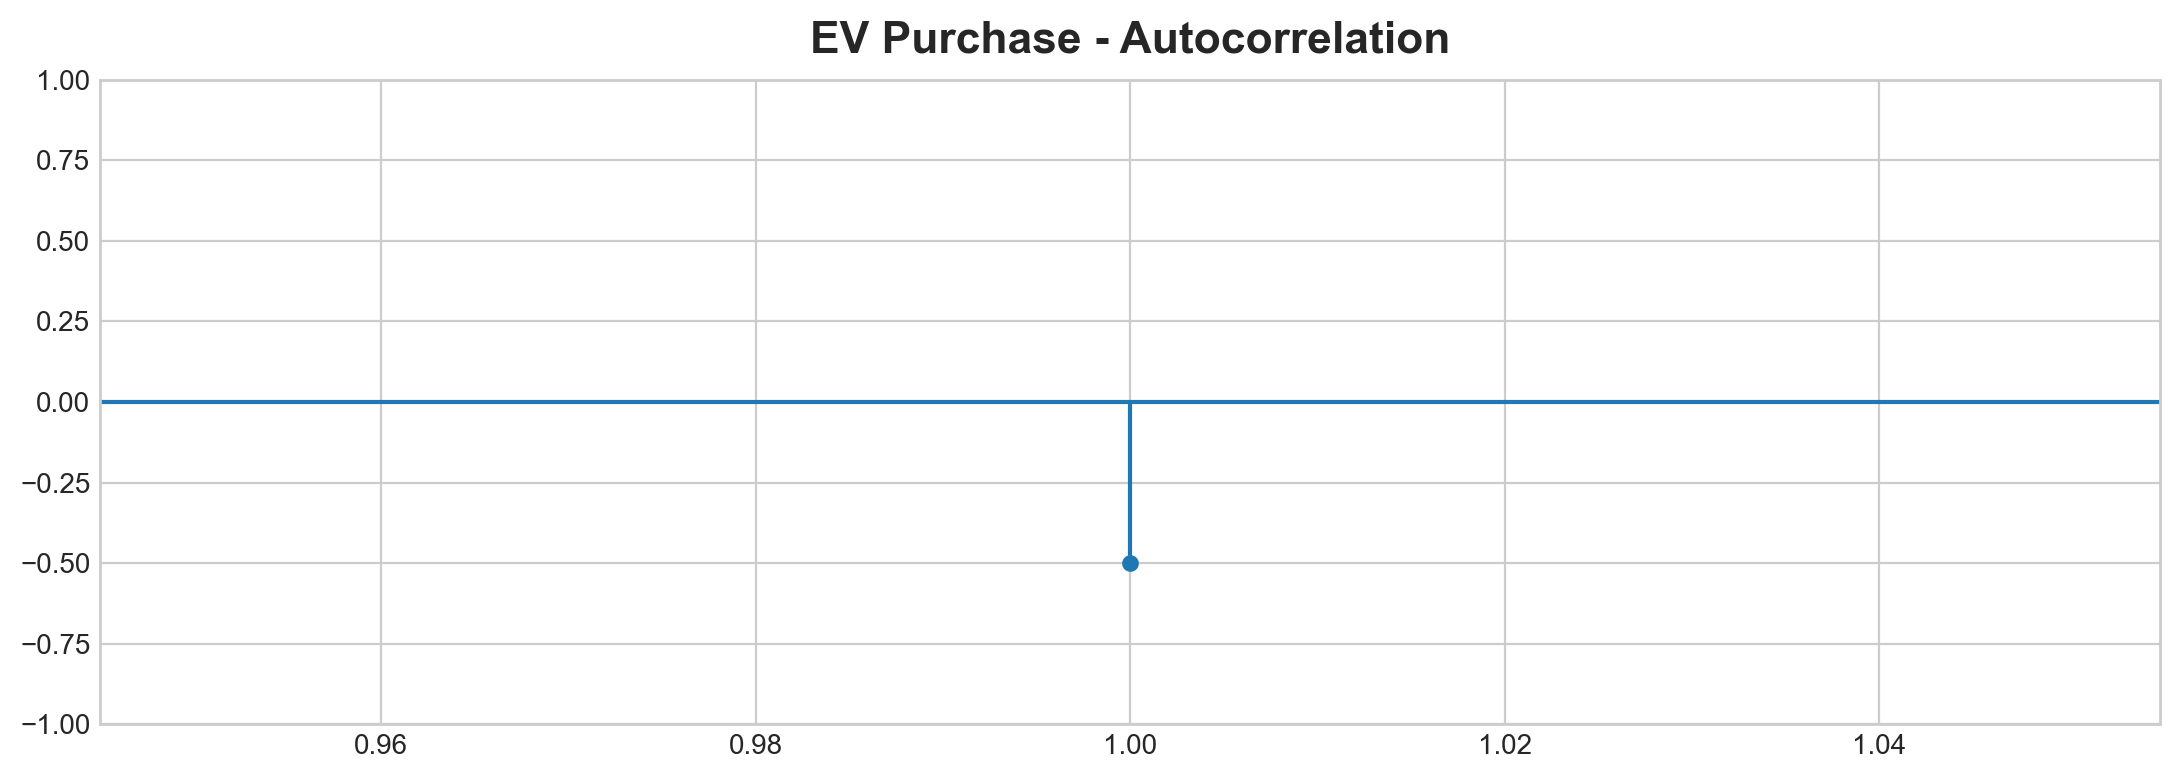

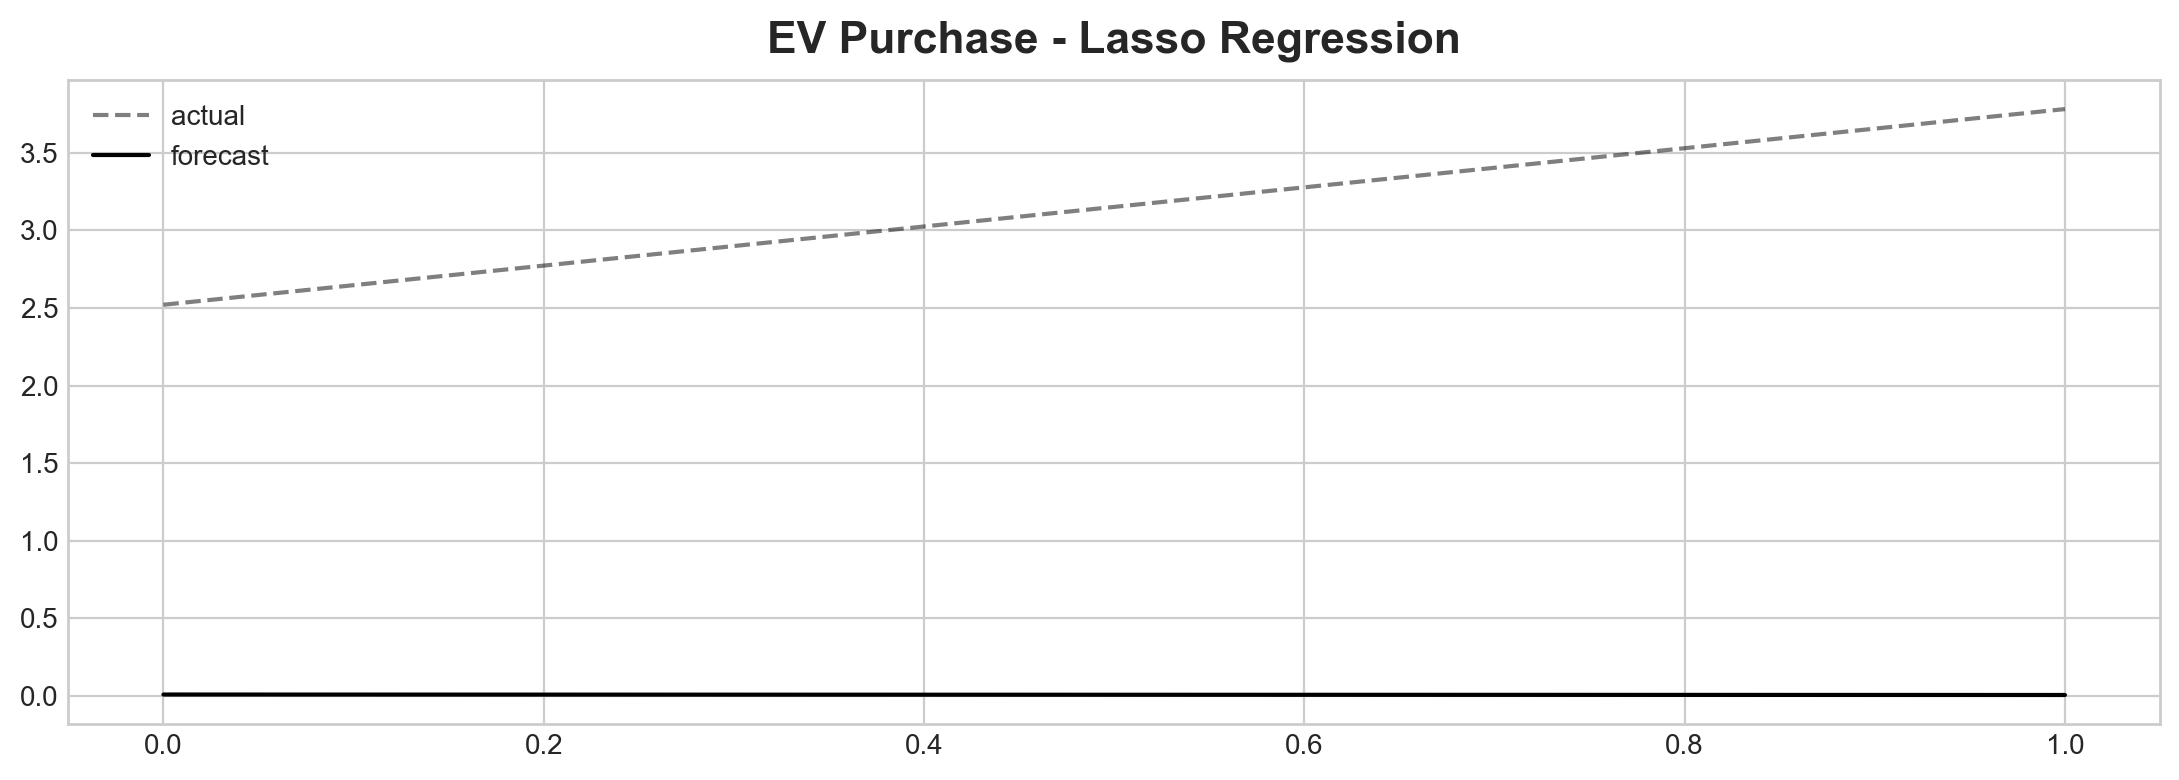

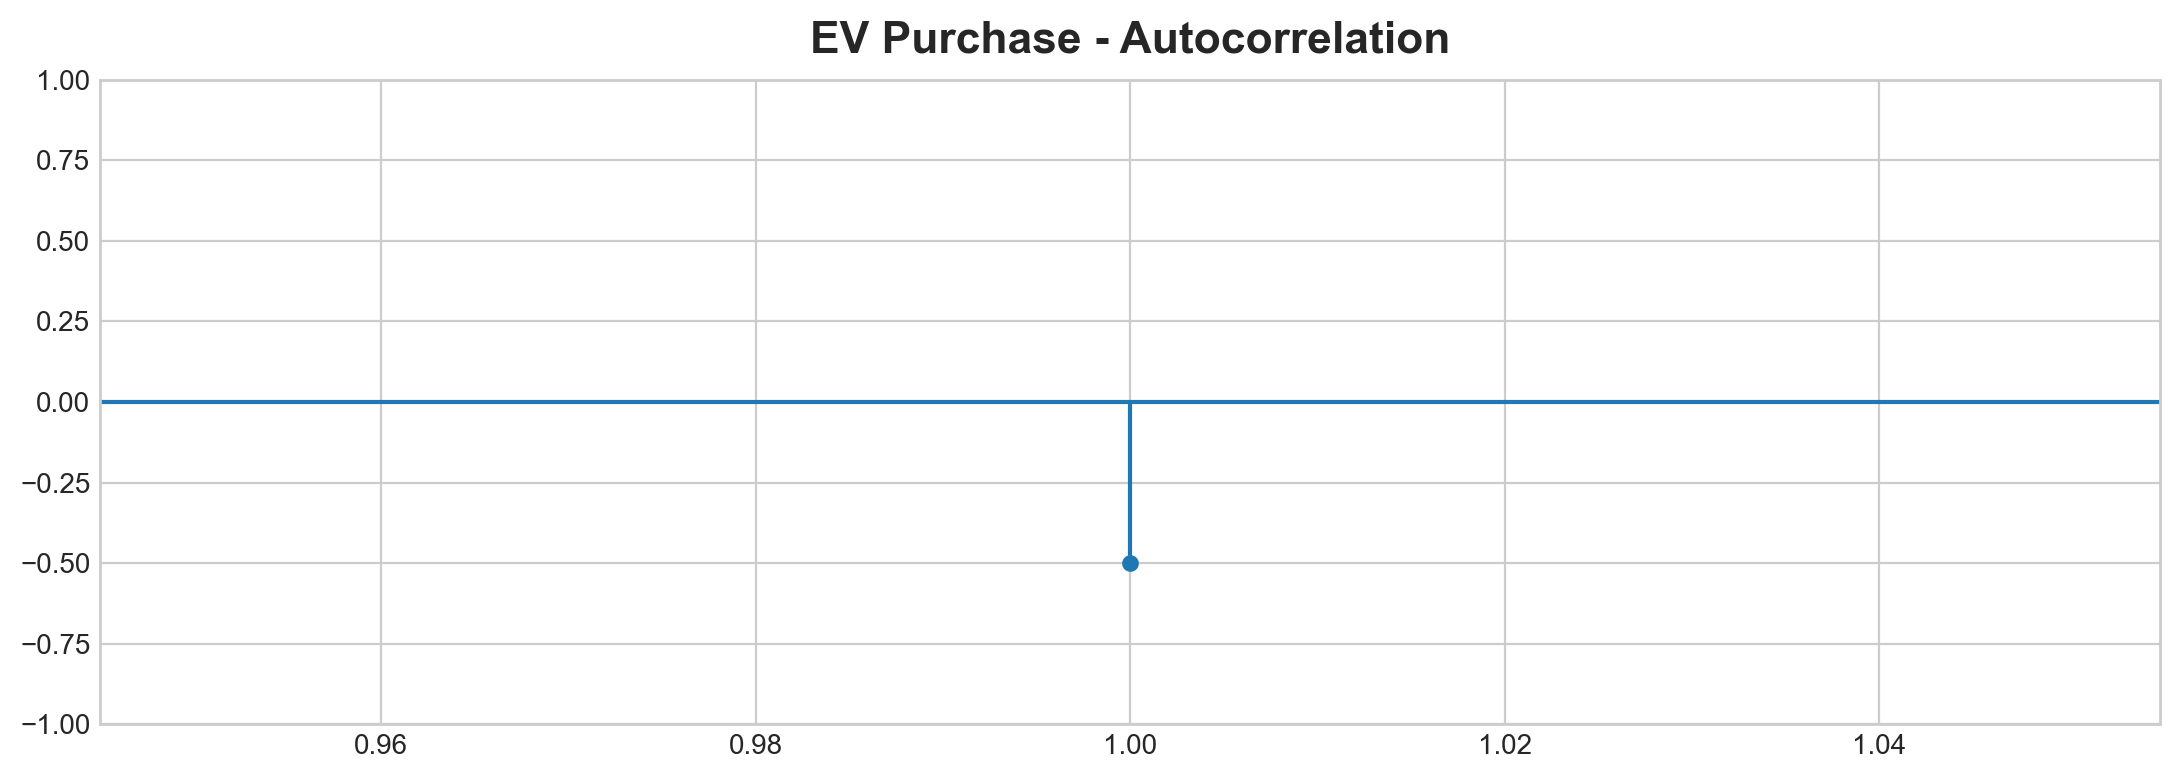

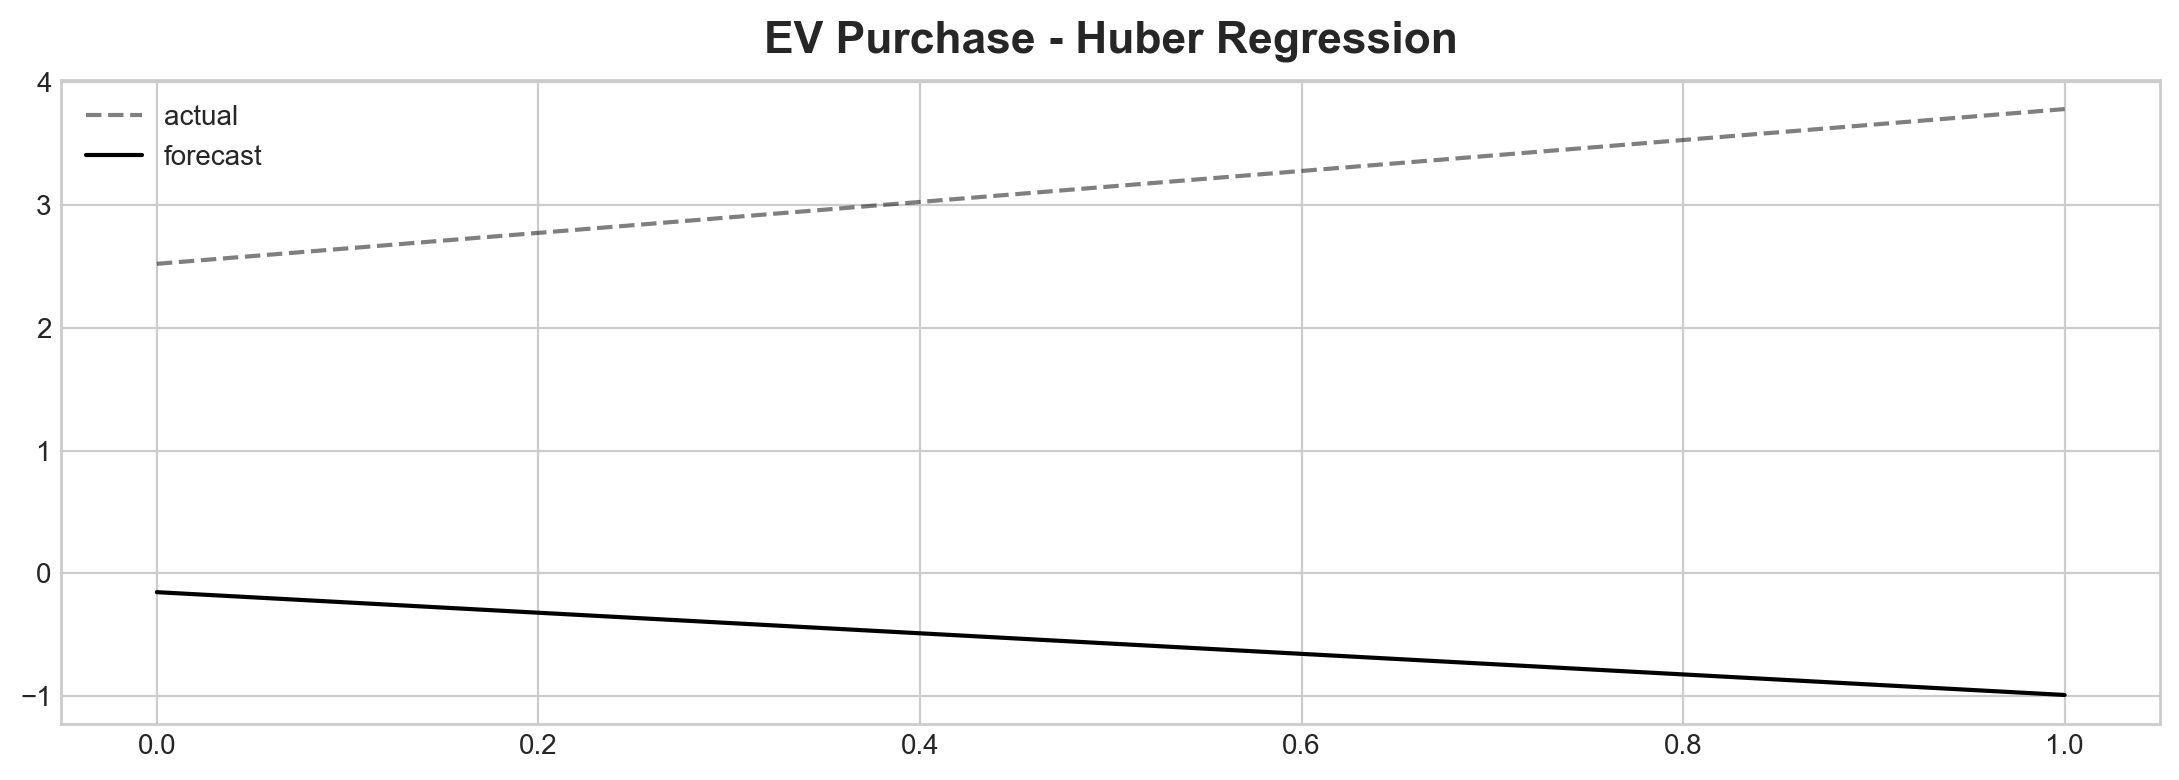

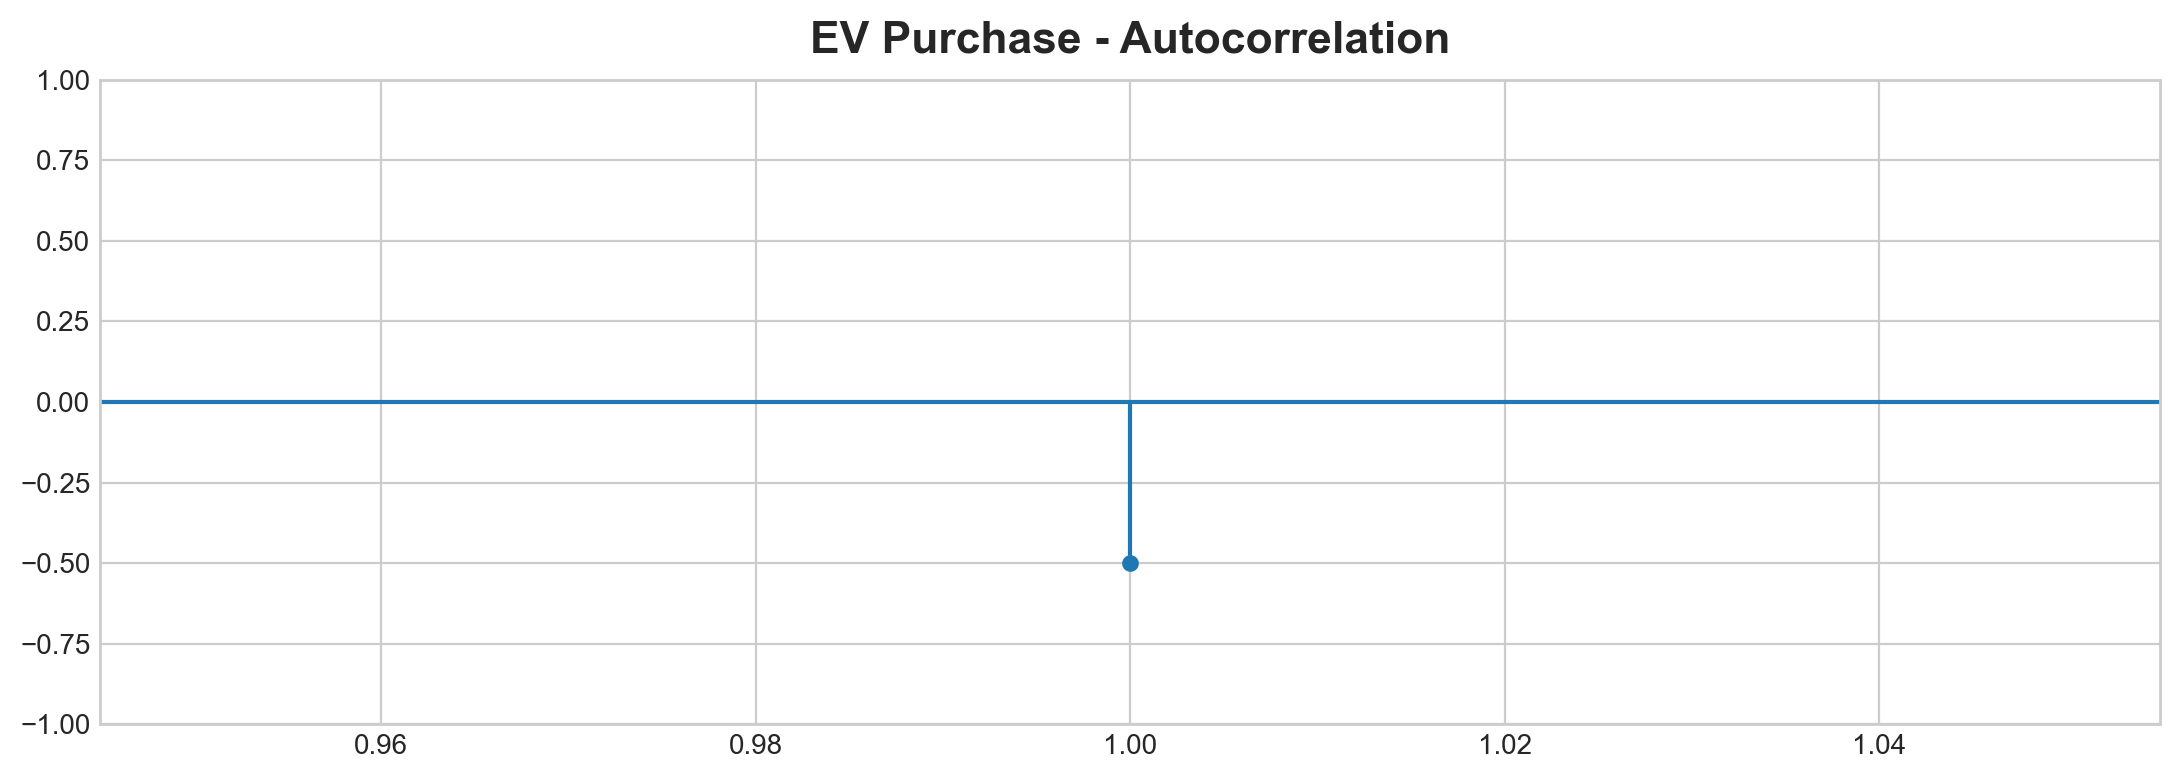

In [119]:
cols = ['yhat', 'resid', 'actual', 'Model Name']
plot_results(cols, ev_results, 'EV Purchase')

In [120]:
cols = ['Model Name', 'Model']
en_models = ev_results.iloc[0:4][cols]

for row in en_models.iterrows():
    print(row[1][0])
    print(row[1][1].coef_)

Linear Regression
[ 0.95178089 -0.15471187 -0.32882951]
Elastic Net
[0.23943777 0.         0.        ]
Ridge Regression
[ 0.69966362  0.01245886 -0.26627549]
Lasso Regression
[0.0112691 0.        0.       ]


## Recursive multi-step forecasting

In [121]:
ev_copy4 = ev.copy()
ev_copy4

year  count
0   2011      3
1   2012     10
2   2013     21
3   2014     51
4   2015     53
5   2016     71
6   2017     59
7   2018     52
8   2019     98
9   2020    110
10  2021    133

In [122]:
ev_copy4.rename(columns={"count": "y"}, inplace=True)

In [124]:
ev_copy4 = ev_copy4.set_index("year")
ev_copy4

y
year     
2011    3
2012   10
2013   21
2014   51
2015   53
2016   71
2017   59
2018   52
2019   98
2020  110
2021  133

In [125]:
ev_copy4 = ev_copy4['y']

In [128]:
steps = 2
data_train = ev_copy4[:-steps]
data_test  = ev_copy4[-steps:]

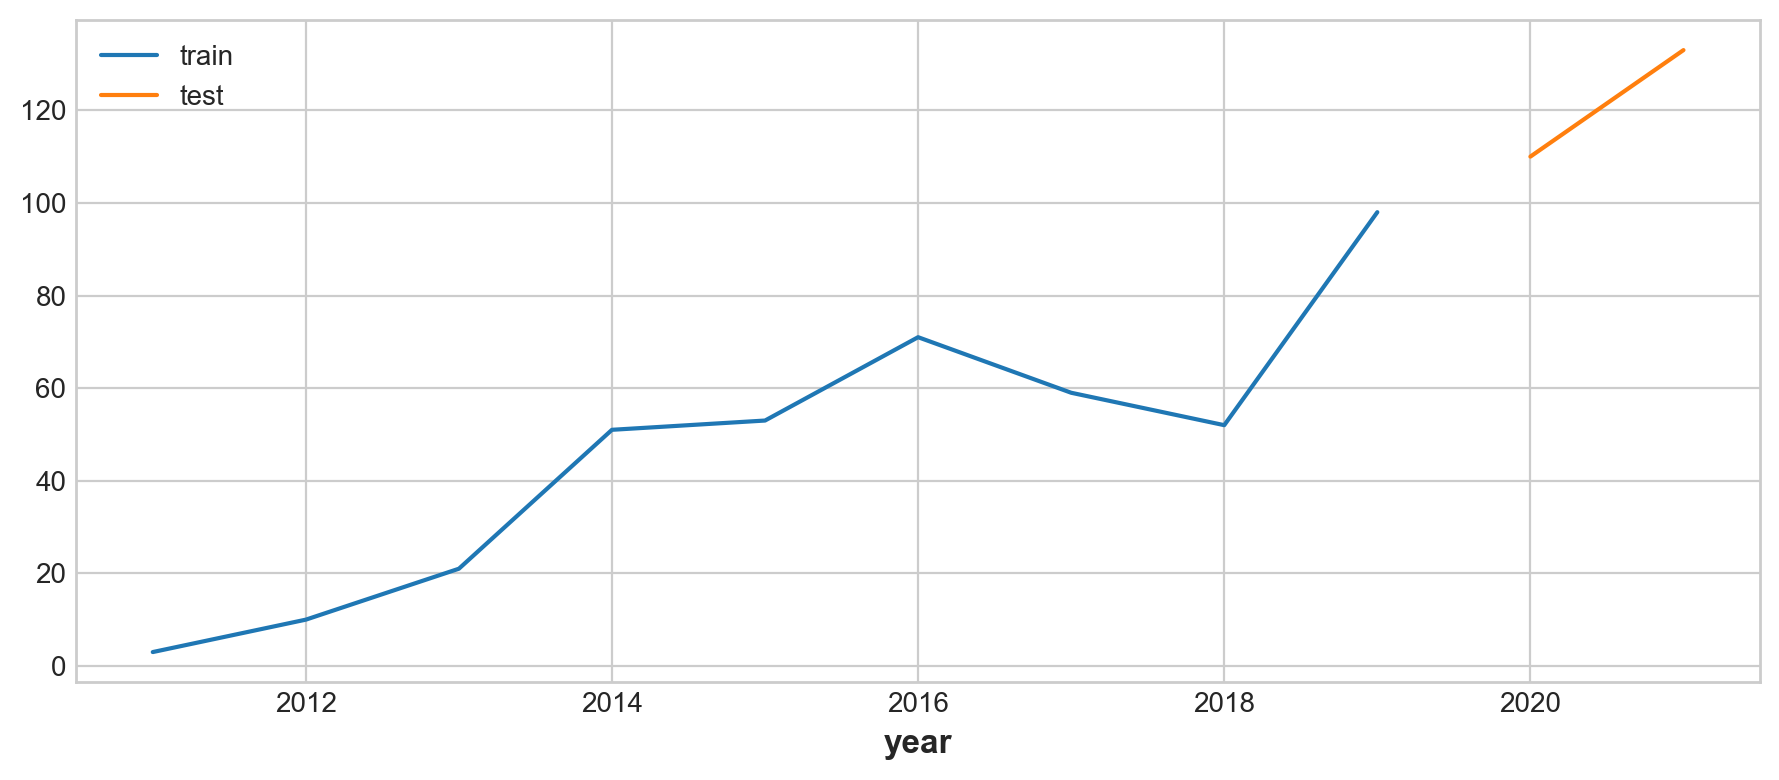

In [129]:
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();

In [130]:
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 8
             )

forecaster.fit(y=data_train)
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: None 
Transformer for exog: None 
Window size: 8 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 8] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-02-01 19:05:11 
Last fit date: 2023-02-01 19:05:11 
Skforecast version: 0.6.0 
Python version: 3.9.16 

In [131]:
predictions = forecaster.predict(steps=2)
predictions.head()

8    98.0
9    98.0
Name: pred, dtype: float64

In [132]:
predictions.index = [2020,2021]

In [133]:
ahead_predictions = forecaster.predict(steps=7)
ahead_predictions

8     98.0
9     98.0
10    98.0
11    98.0
12    98.0
13    98.0
14    98.0
Name: pred, dtype: float64

In [134]:
ahead_predictions.index = [2020,2021,2022,2023,2024,2025,2026]

In [135]:
ahead_predictions

2020    98.0
2021    98.0
2022    98.0
2023    98.0
2024    98.0
2025    98.0
2026    98.0
Name: pred, dtype: float64

In [136]:
ahead_predictions.drop([2020,2021],axis=0,inplace=True)

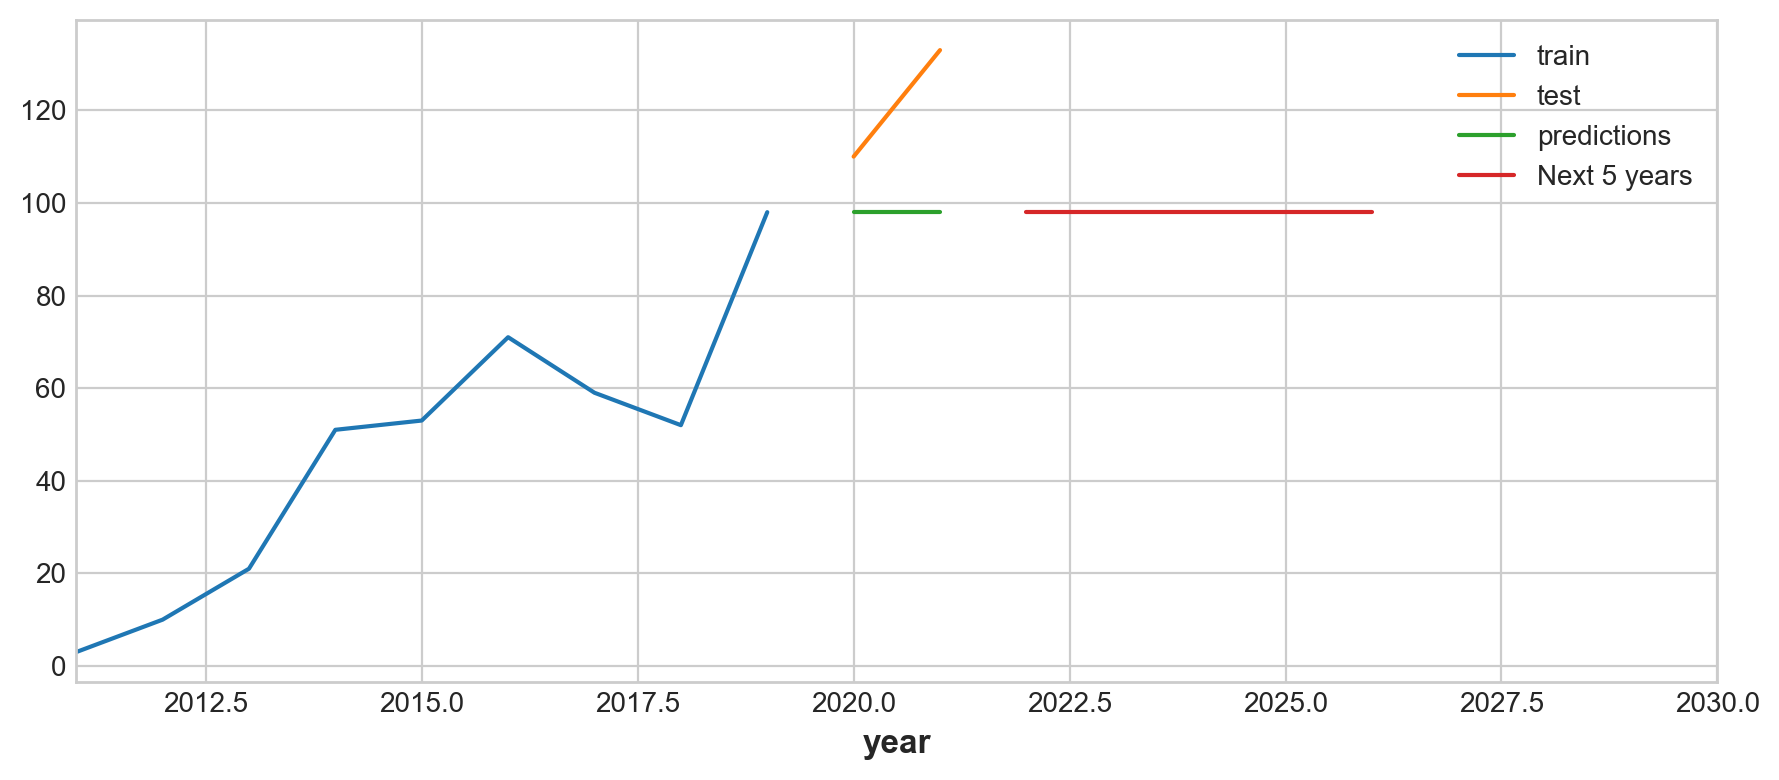

In [137]:
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train', xlim = (2011,2030))
data_test.plot(ax=ax, label='test', xlim = (2011,2030))
predictions.plot(ax=ax, label='predictions')
ahead_predictions.plot(ax=ax, label='Next 5 years')
ax.legend();

## **XGBOOST**

In [138]:
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(),
                 lags = 8
             )

forecaster.fit(y=data_train,)
forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: None 
Transformer for exog: None 
Window size: 8 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Trainin

In [139]:
predictions= forecaster.predict(steps=2,)
predictions

8    97.999977
9    97.999977
Name: pred, dtype: float64

In [140]:
predictions.index = [2020,2021]

In [141]:
ahead_predictions = forecaster.predict(steps=7,)

ahead_predictions.index = [2020,2021,2022,2023,2024,2025,2026]
ahead_predictions.drop([2020,2021],axis=0,inplace=True)

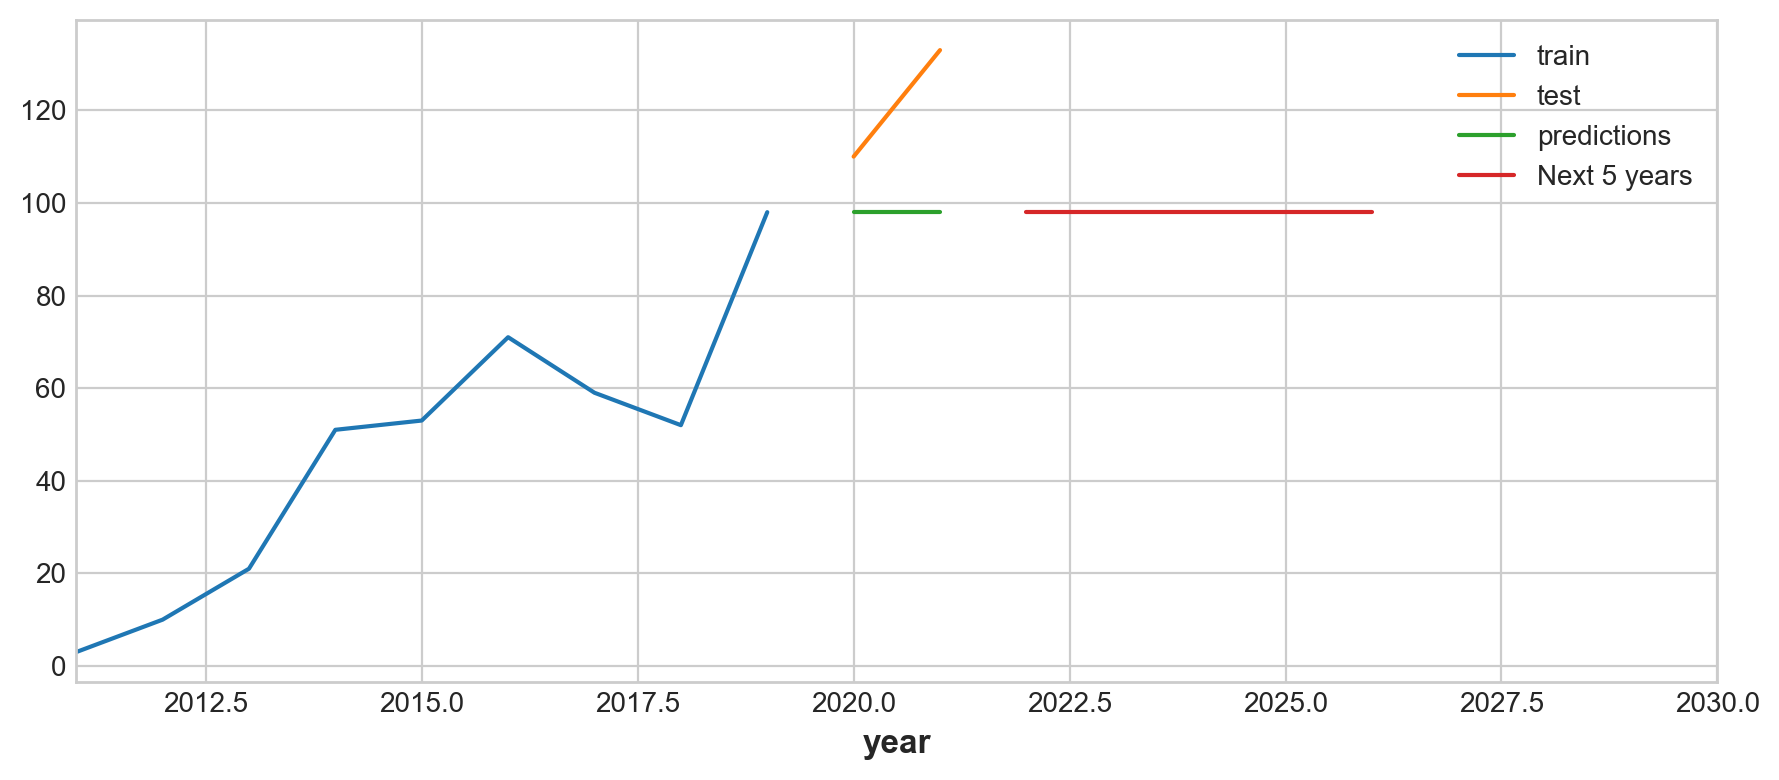

In [142]:
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train', xlim = (2011,2030))
data_test.plot(ax=ax, label='test', xlim = (2011,2030))
predictions.plot(ax=ax, label='predictions')
ahead_predictions.plot(ax=ax, label='Next 5 years')
ax.legend();

In [184]:
scaler = Standardize()
train_s, test_s = scaler.fit_transform(train, test)
train_s.head()

x_1       x_2       x_3         y
year                                        
2011 -1.166936 -1.451908 -1.823211 -0.712610
2012 -0.910332 -0.984465 -0.010073 -0.602977
2013 -0.507098  0.290382  0.110803  0.383713
2014  0.592632  0.375371  1.198686 -0.274081
2015  0.665948  1.140279  0.473431 -0.657794

In [185]:
y_train_original = scaler.inverse_y(train_s['y'])

In [186]:
train_original = scaler.inverse(train_s)
train_original.head()

x_1   x_2   x_3     y
year                        
2011   3.0  10.0  21.0  51.0
2012  10.0  21.0  51.0  53.0
2013  21.0  51.0  53.0  71.0
2014  51.0  53.0  71.0  59.0
2015  53.0  71.0  59.0  52.0

In [187]:
train_s.head()

x_1       x_2       x_3         y
year                                        
2011 -1.166936 -1.451908 -1.823211 -0.712610
2012 -0.910332 -0.984465 -0.010073 -0.602977
2013 -0.507098  0.290382  0.110803  0.383713
2014  0.592632  0.375371  1.198686 -0.274081
2015  0.665948  1.140279  0.473431 -0.657794

In [191]:
test_s.head()

x_1       x_2       x_3         y
year                                        
2017  0.885894  0.332877  2.830511  2.521542
2018  0.629290  2.287641  3.555766  3.782313

In [192]:
ev_results = train_different_models(train_s, test_s, regressors)

training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...


In [193]:
cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
ev_results = pd.DataFrame(ev_results)
ev_results[cols].sort_values('MASE')

Model Name      RMSE      MAPE      MASE
1        Elastic Net  3.043208  0.938021  3.187696
3   Lasso Regression  3.206261  0.997083  3.373191
2   Ridge Regression  3.548213  1.088914  3.708438
0  Linear Regression  3.822980  1.149755  3.952869
4   Huber Regression  3.869271  1.161477  3.996568

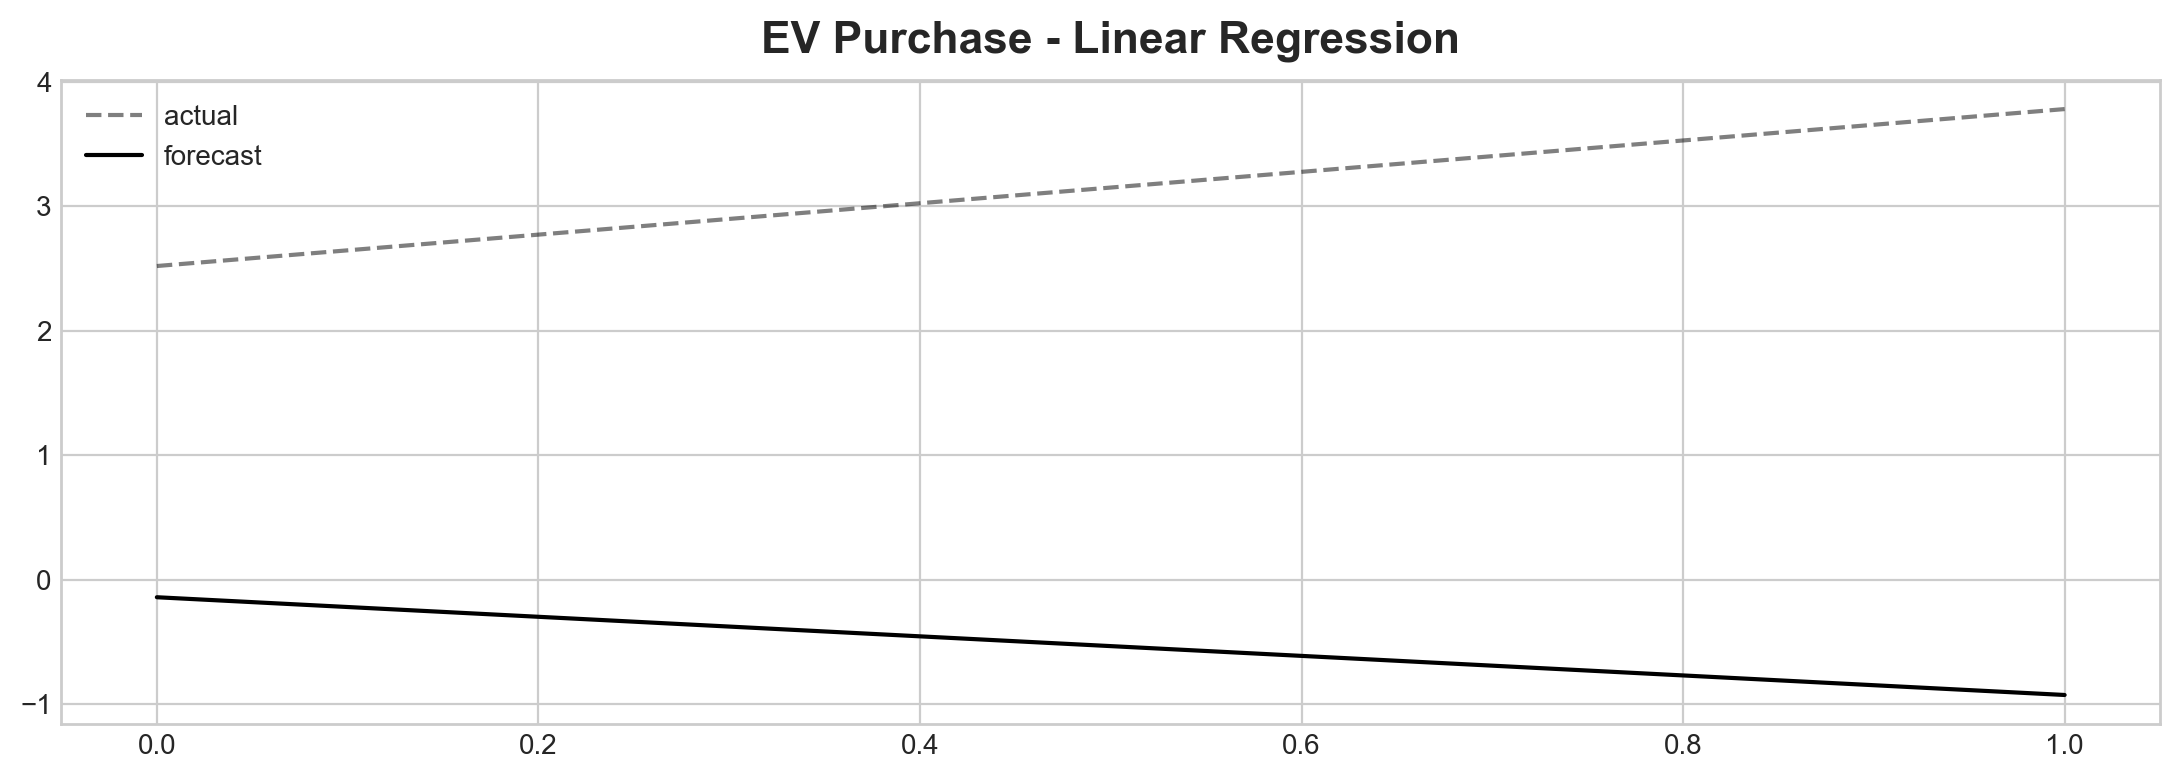

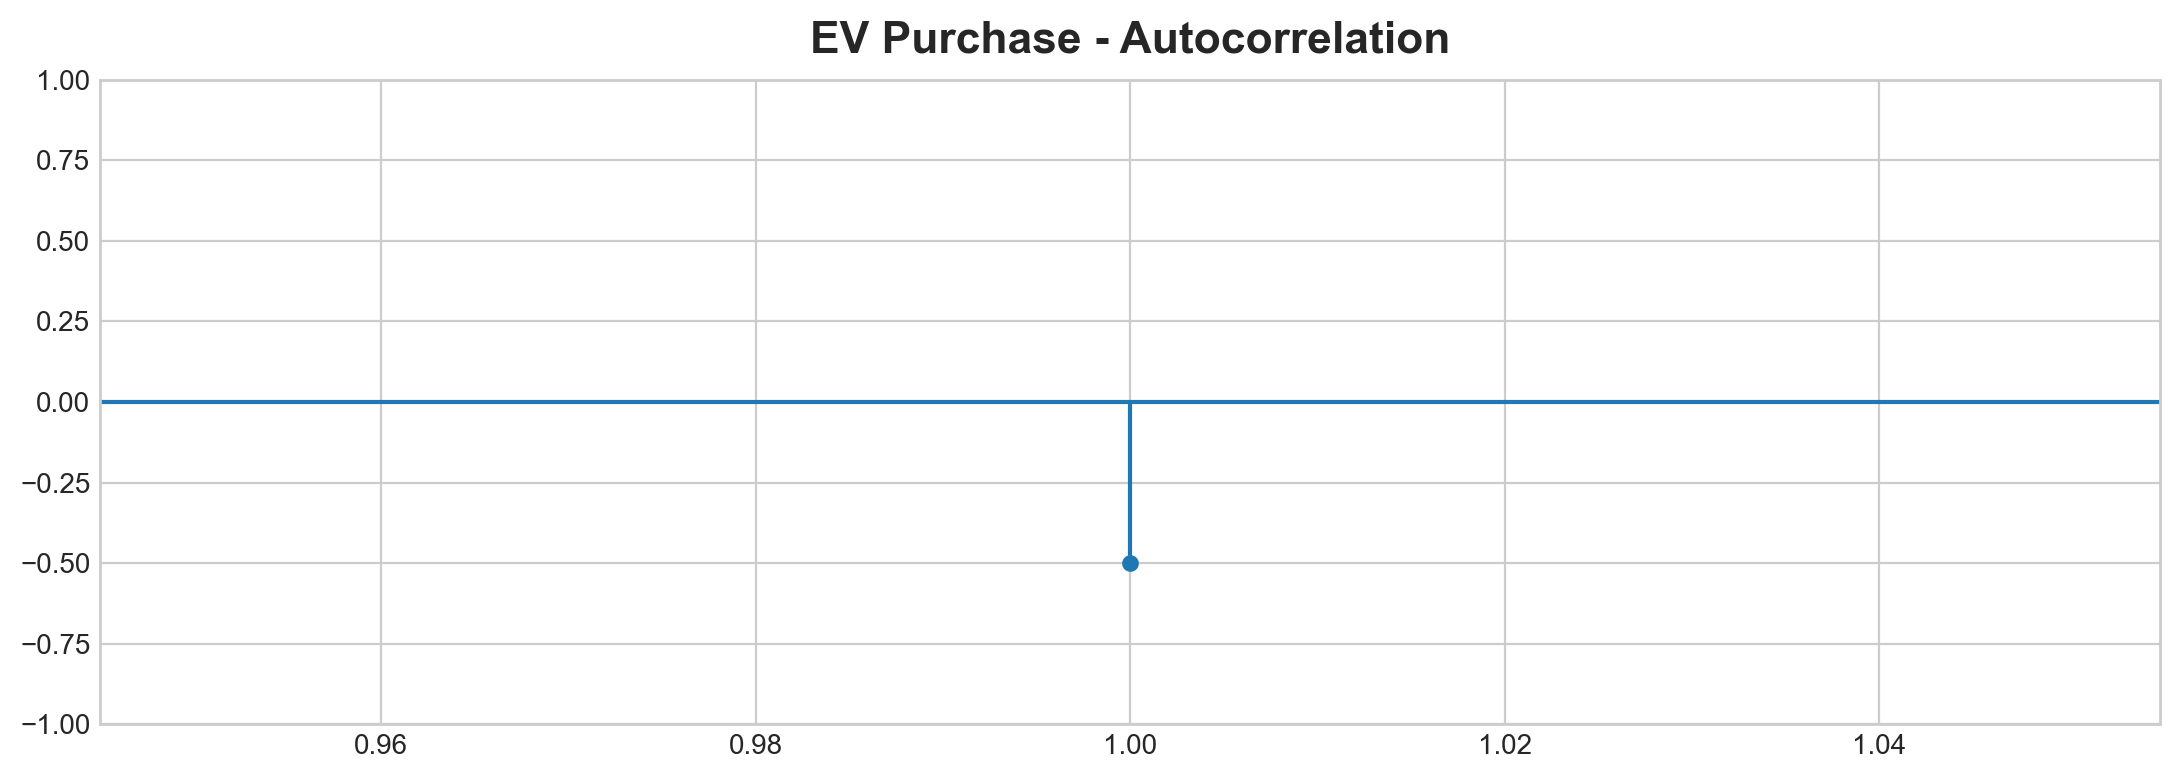

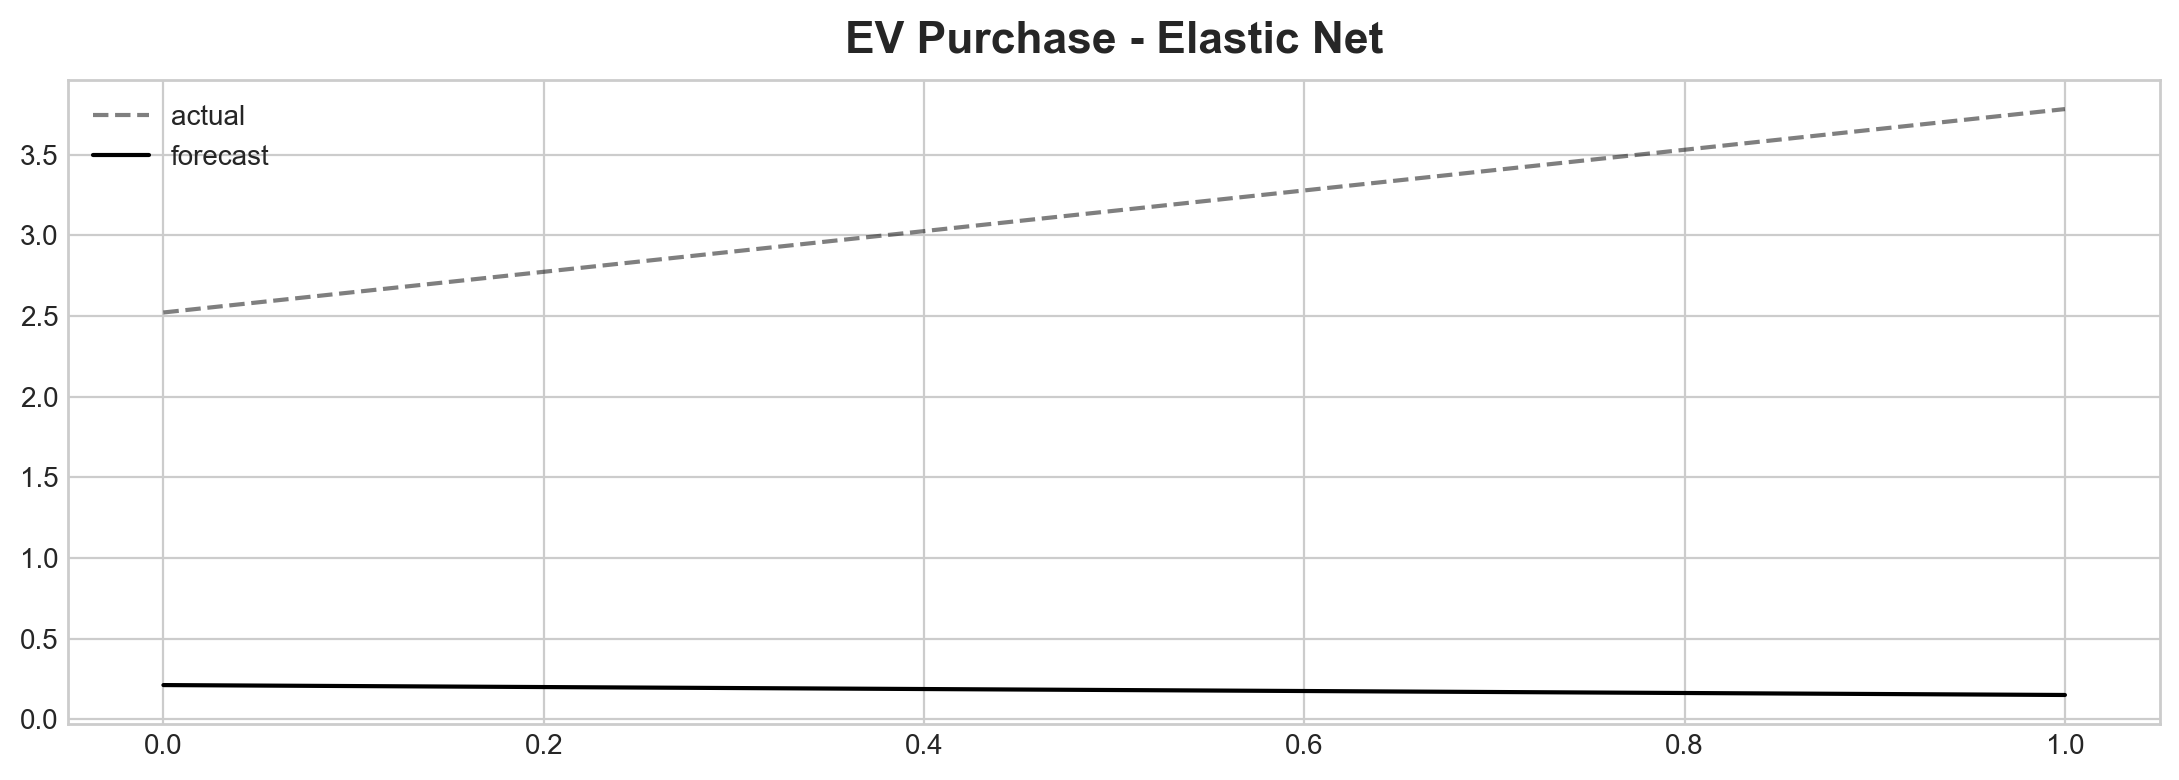

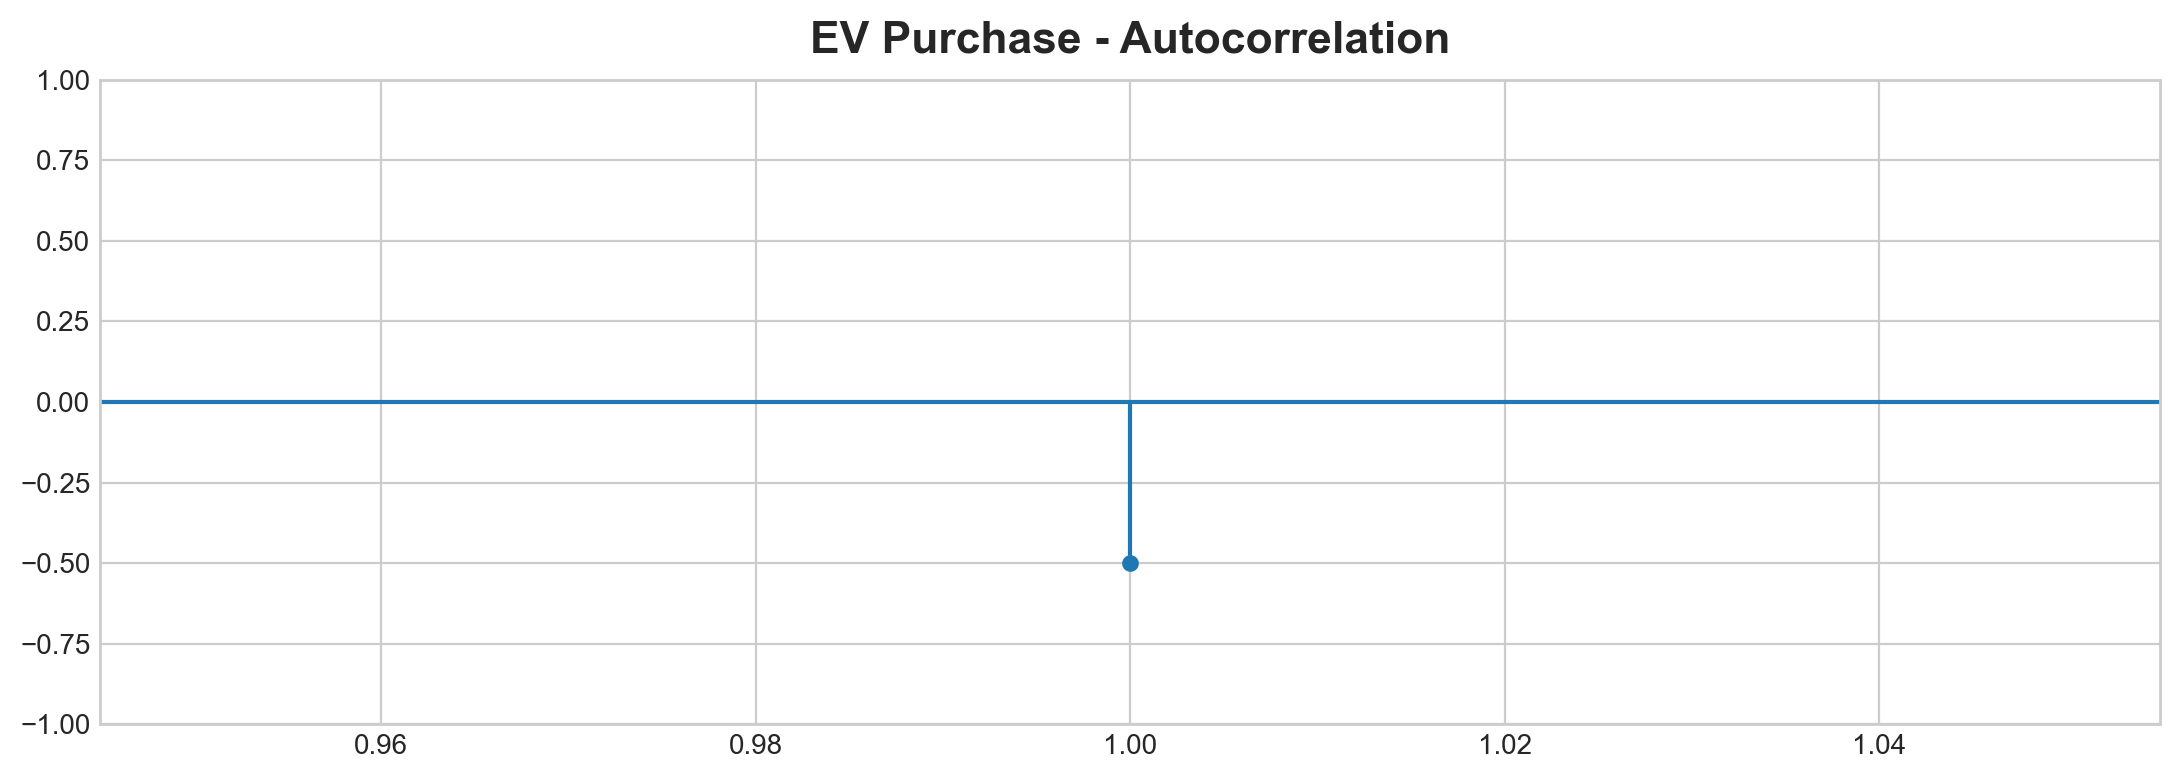

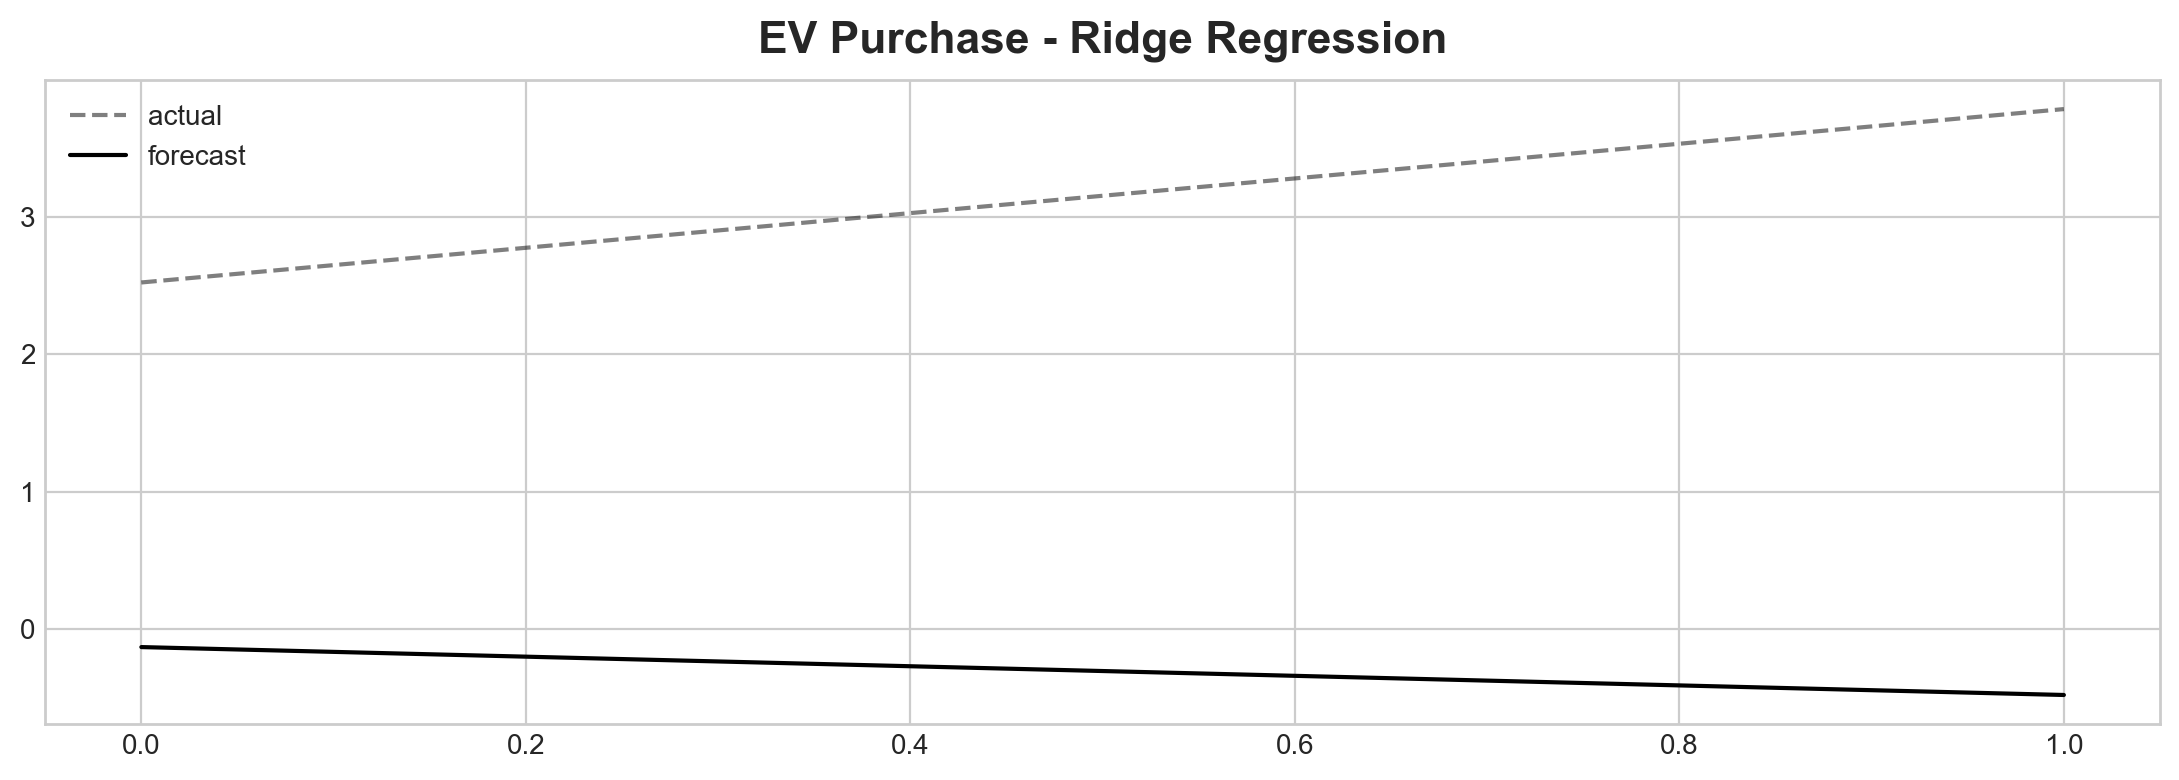

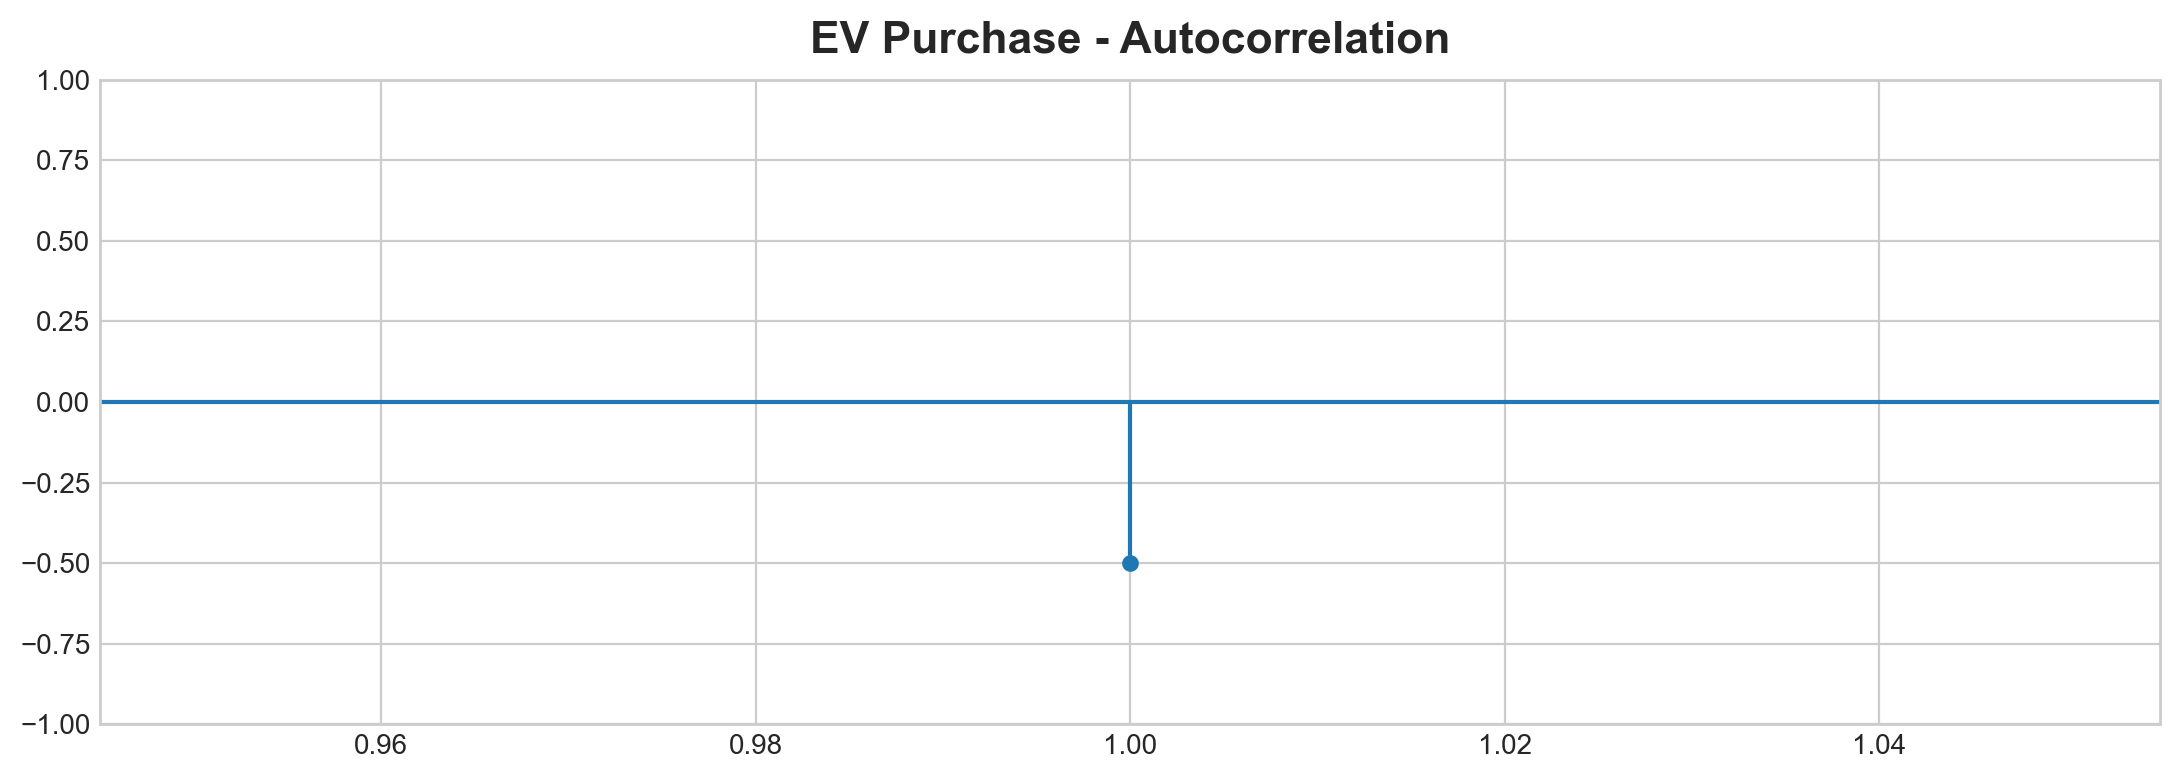

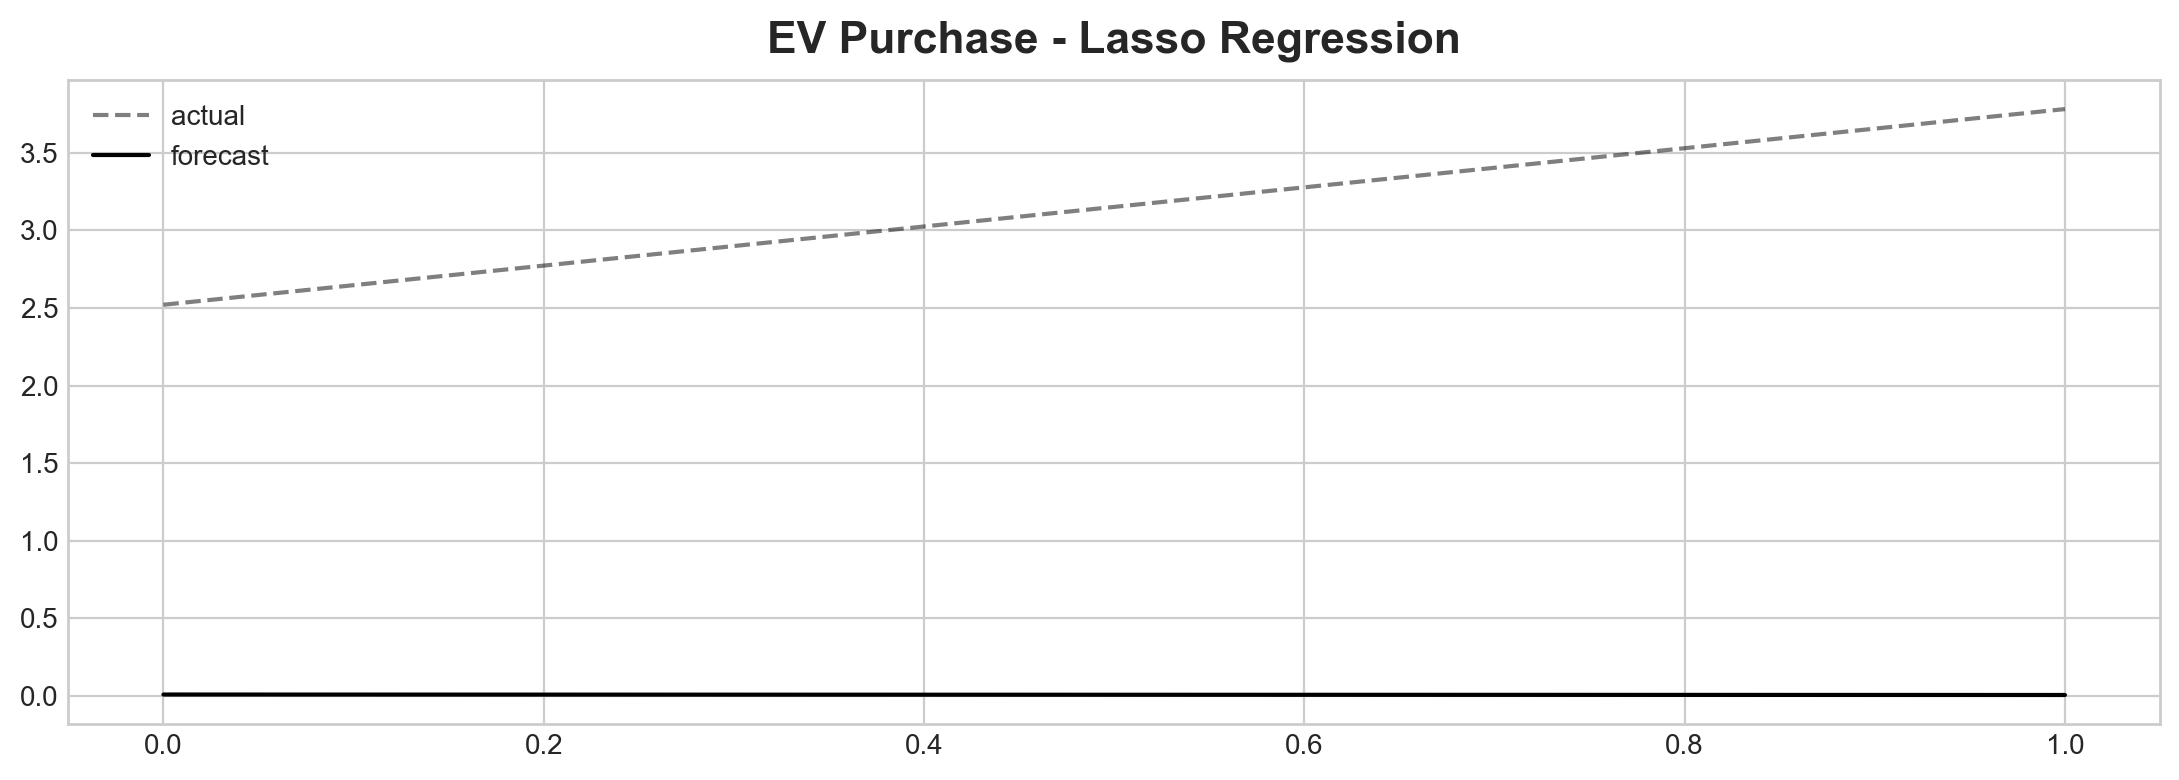

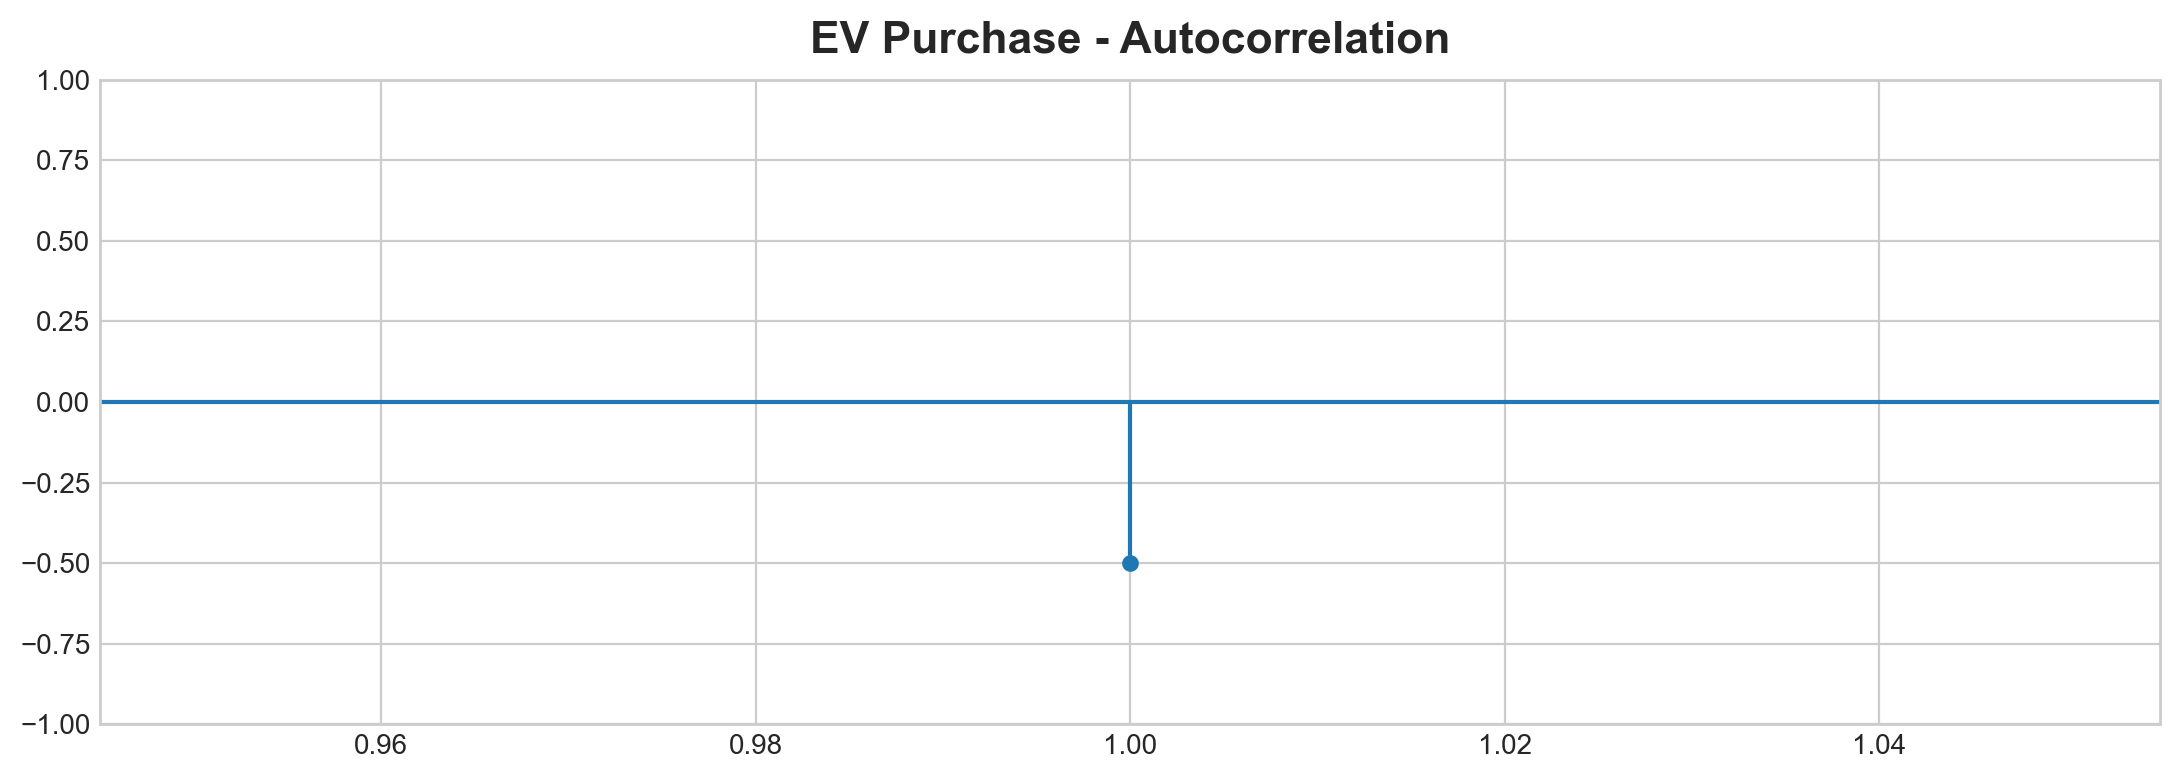

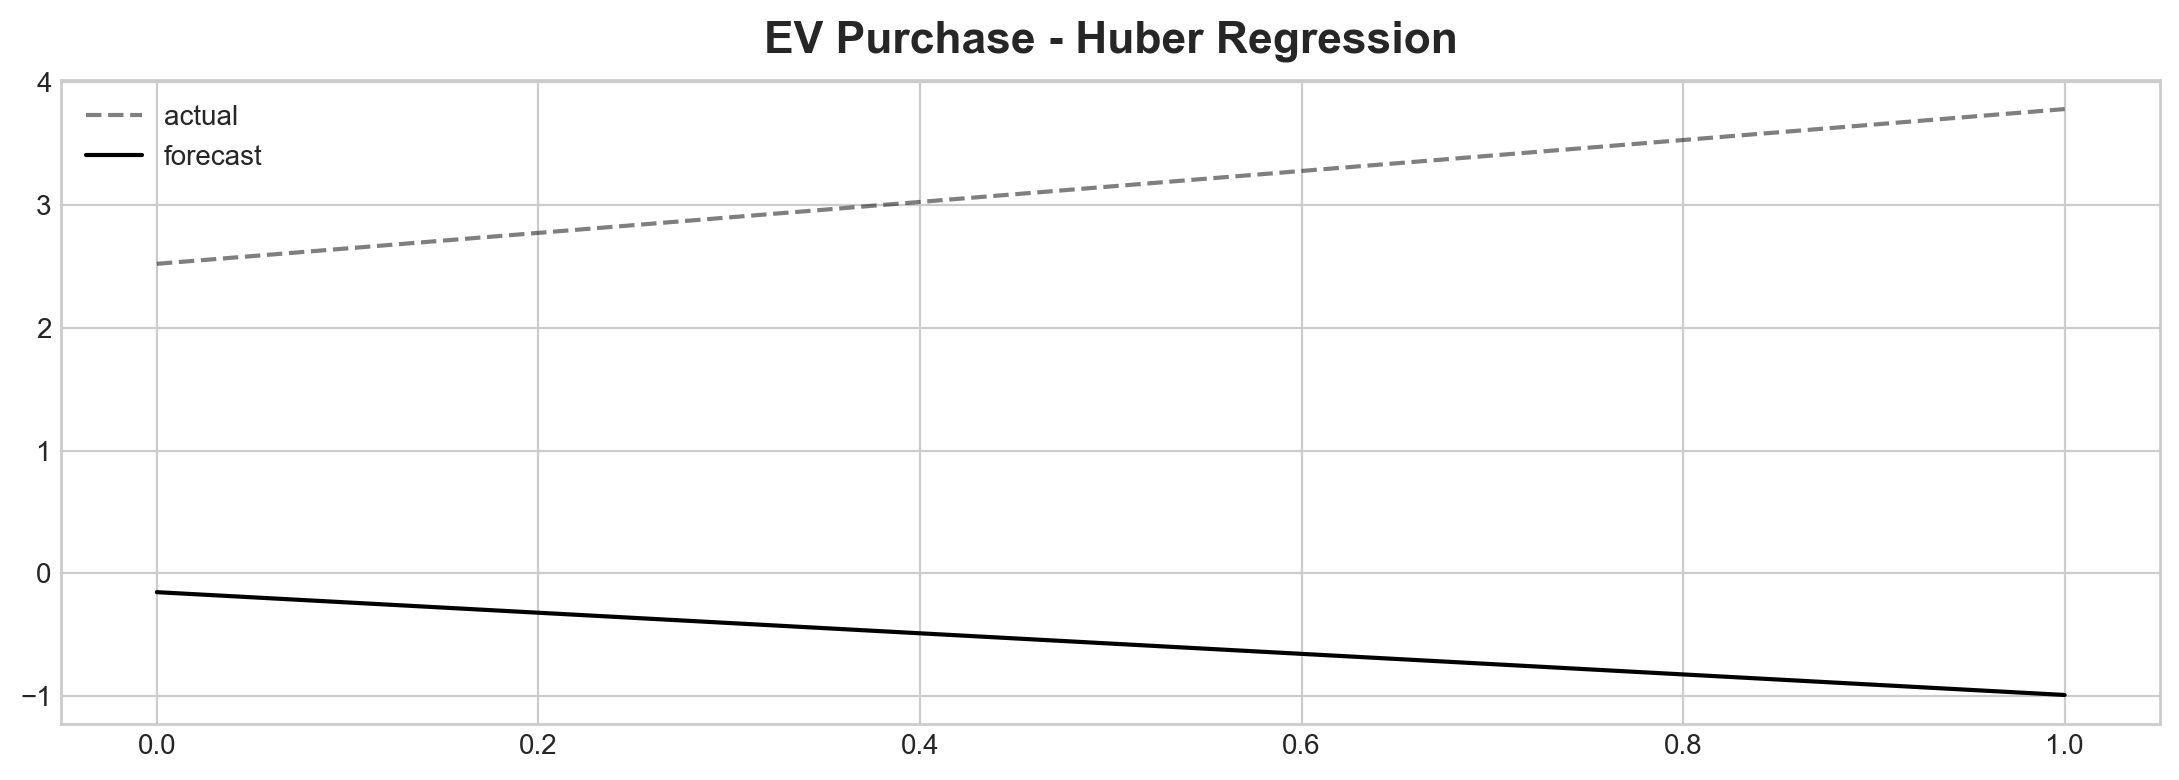

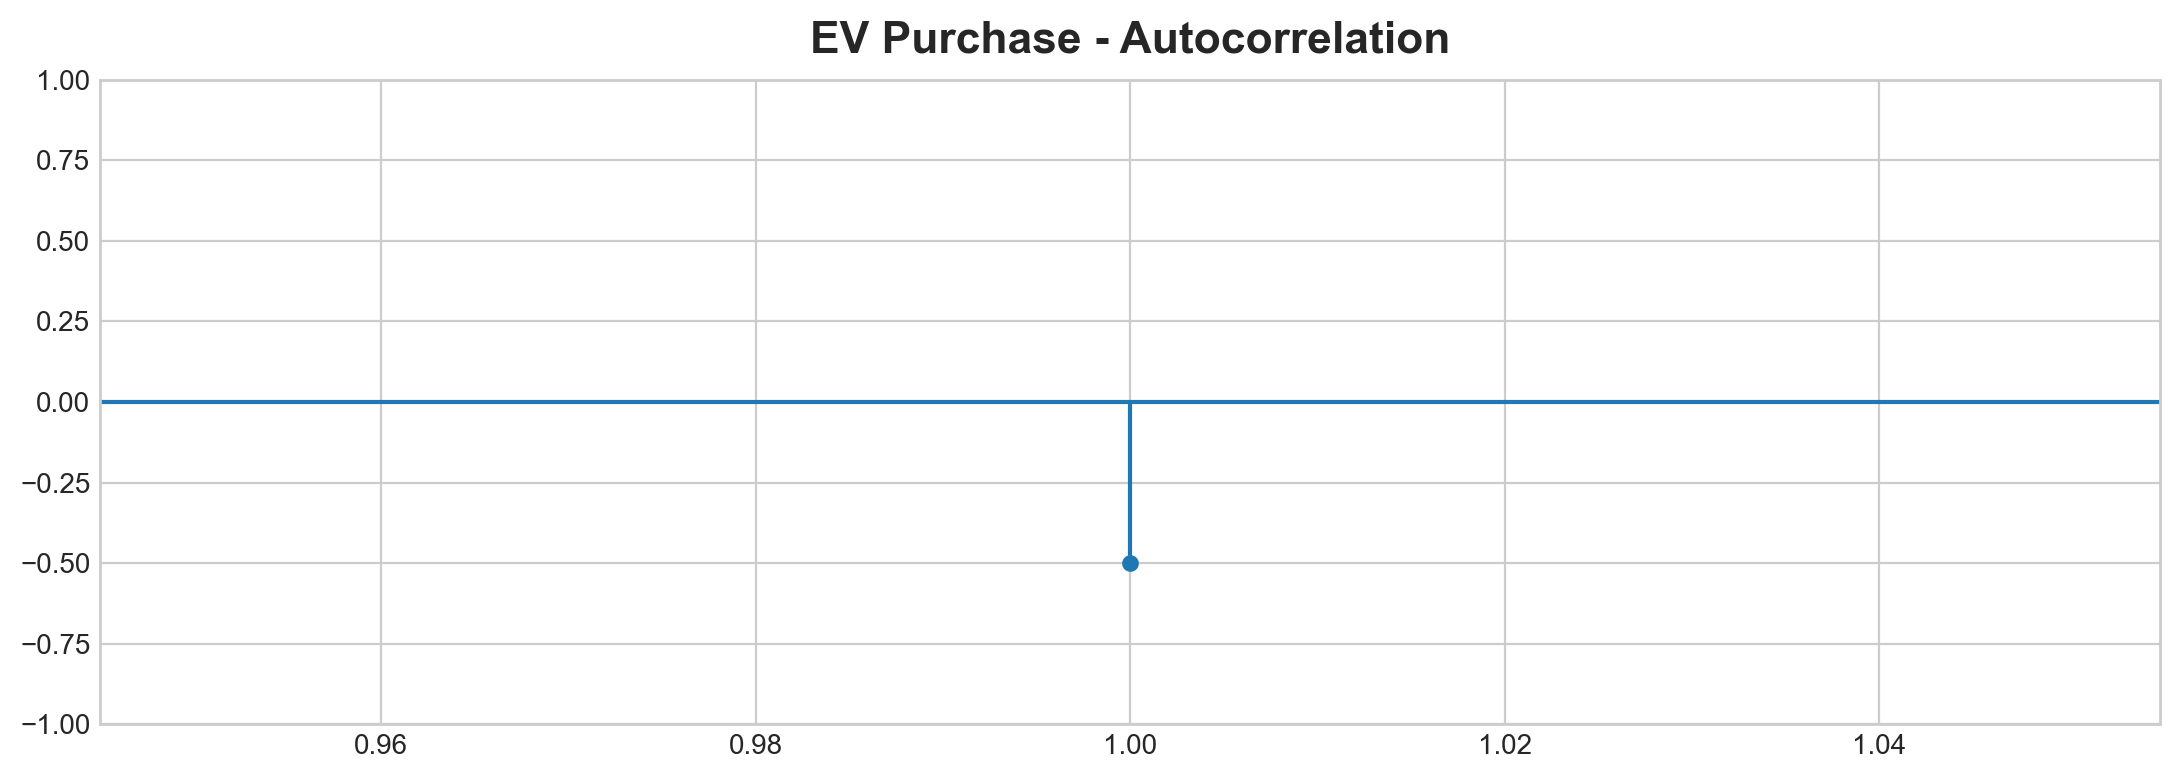

In [195]:
cols = ['yhat', 'resid', 'actual', 'Model Name']
plot_results(cols, ev_results, 'EV Purchase')

In [196]:
cols = ['Model Name', 'Model']
en_models = ev_results.iloc[0:4][cols]

for row in en_models.iterrows():
    print(row[1][0])
    print(row[1][1].coef_)

Linear Regression
[ 0.95178089 -0.15471187 -0.32882951]
Elastic Net
[0.23943777 0.         0.        ]
Ridge Regression
[ 0.69966362  0.01245886 -0.26627549]
Lasso Regression
[0.0112691 0.        0.       ]


NAIVE FORECASTER

In [197]:
from sktime.forecasting.naive import NaiveForecaster
forecaster = NaiveForecaster(strategy="last", sp=1)

In [198]:
forecaster.fit(ev["count"])

NaiveForecaster()

In [199]:
fh = np.arange(1,3)
fh

array([1, 2])

In [200]:
y_pred = forecaster.predict(fh)

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='count'>)

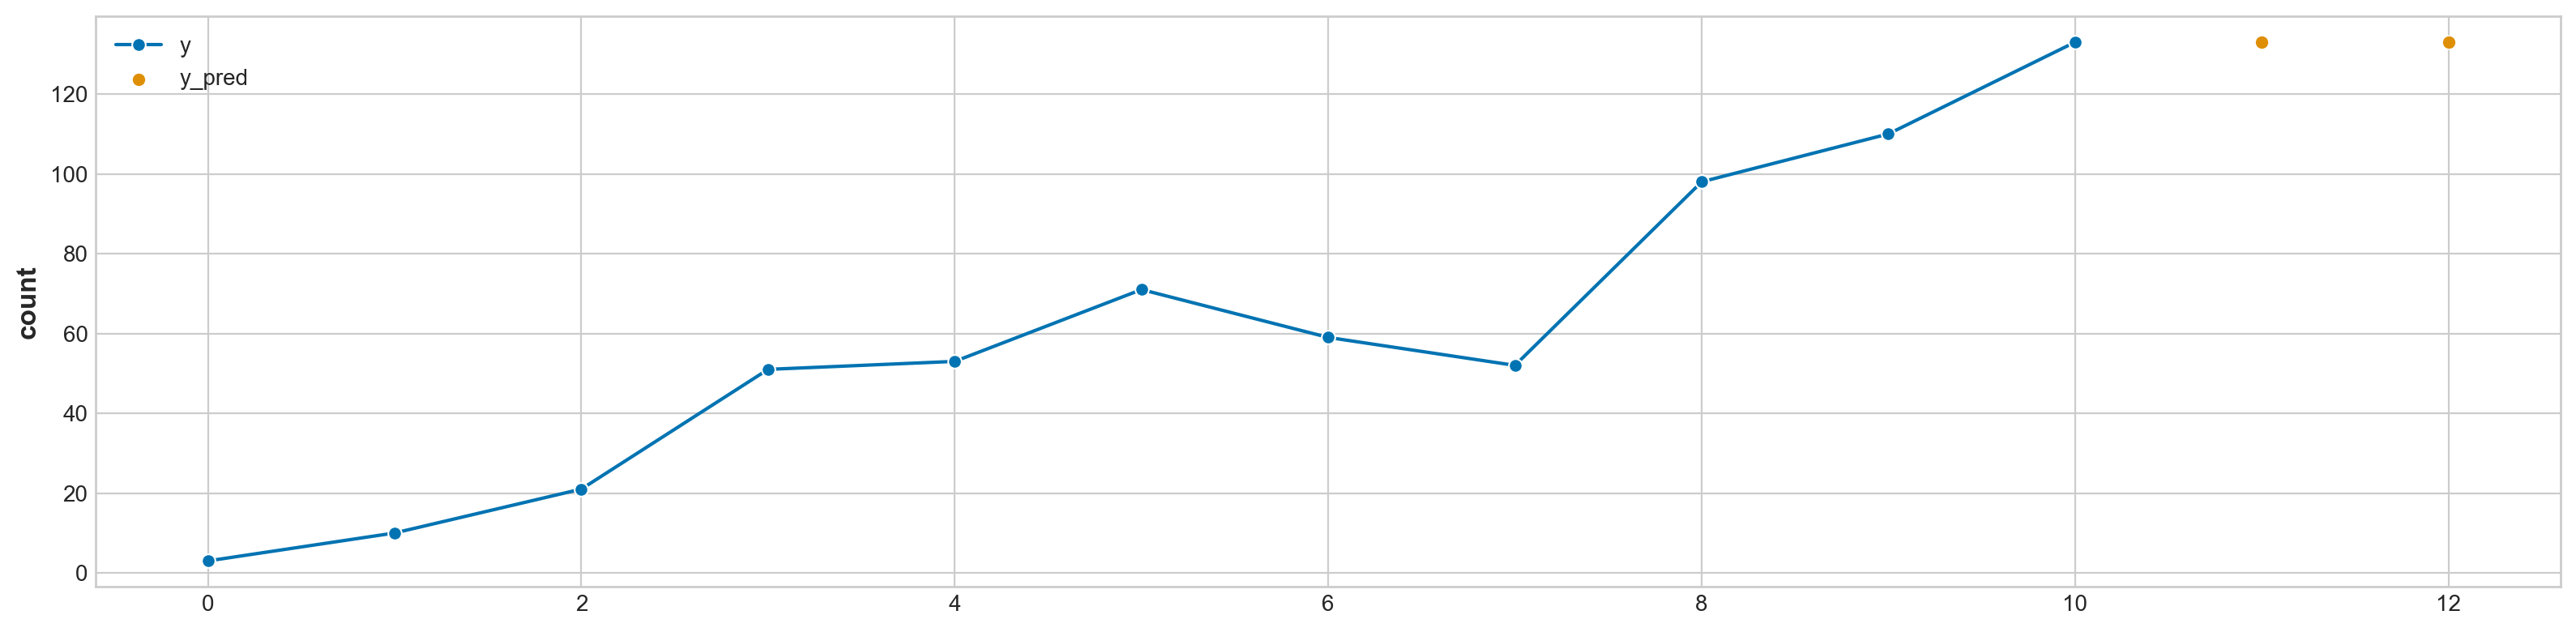

In [201]:
# plotting predictions and past data
plot_series(ev["count"], y_pred, labels=["y", "y_pred"])

ARIMA

In [202]:
ev

year  count
0   2011      3
1   2012     10
2   2013     21
3   2014     51
4   2015     53
5   2016     71
6   2017     59
7   2018     52
8   2019     98
9   2020    110
10  2021    133

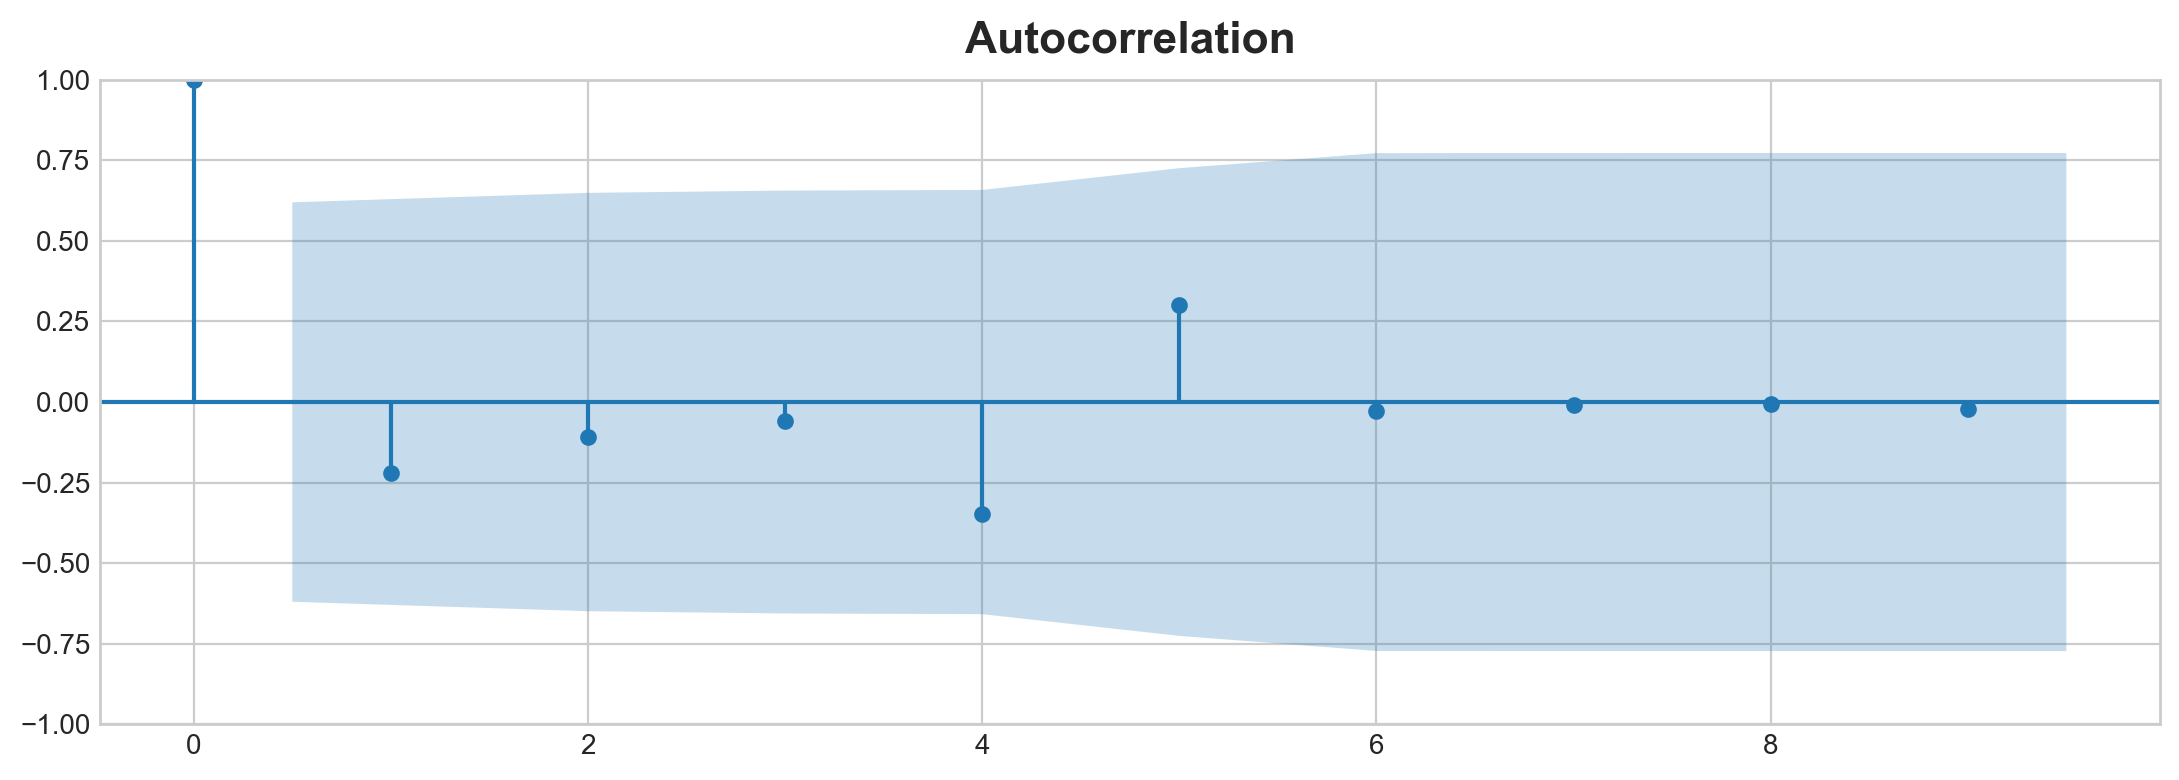

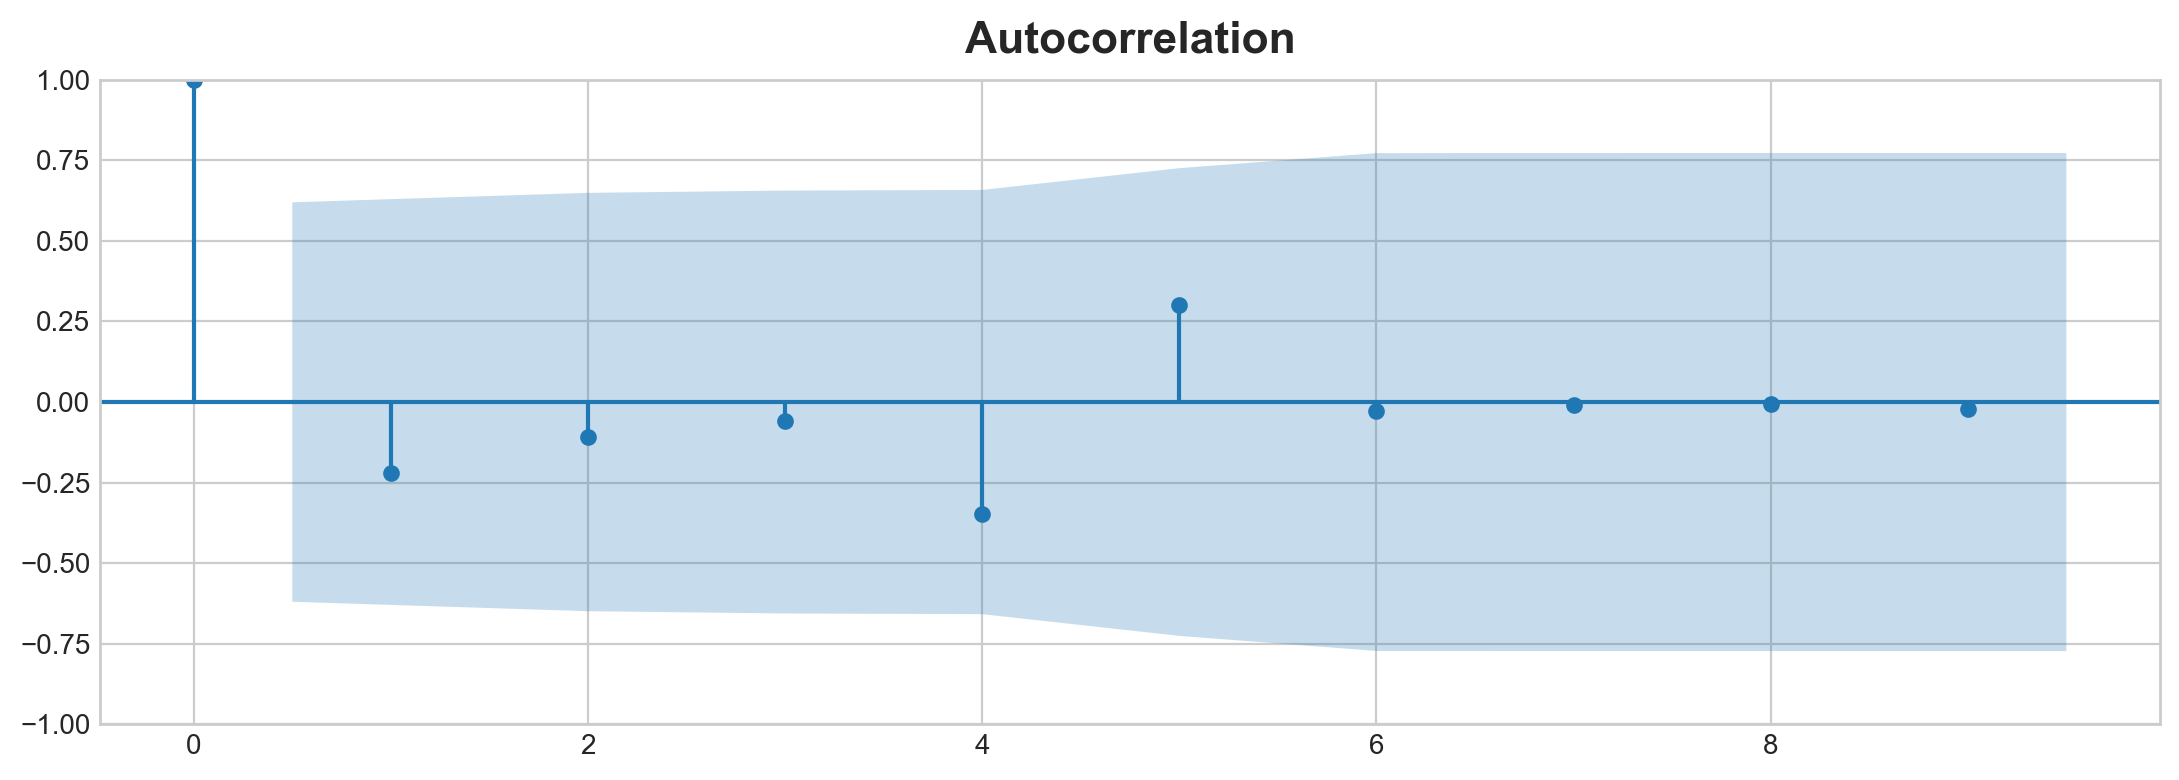

In [205]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(ev["count"].diff().dropna())

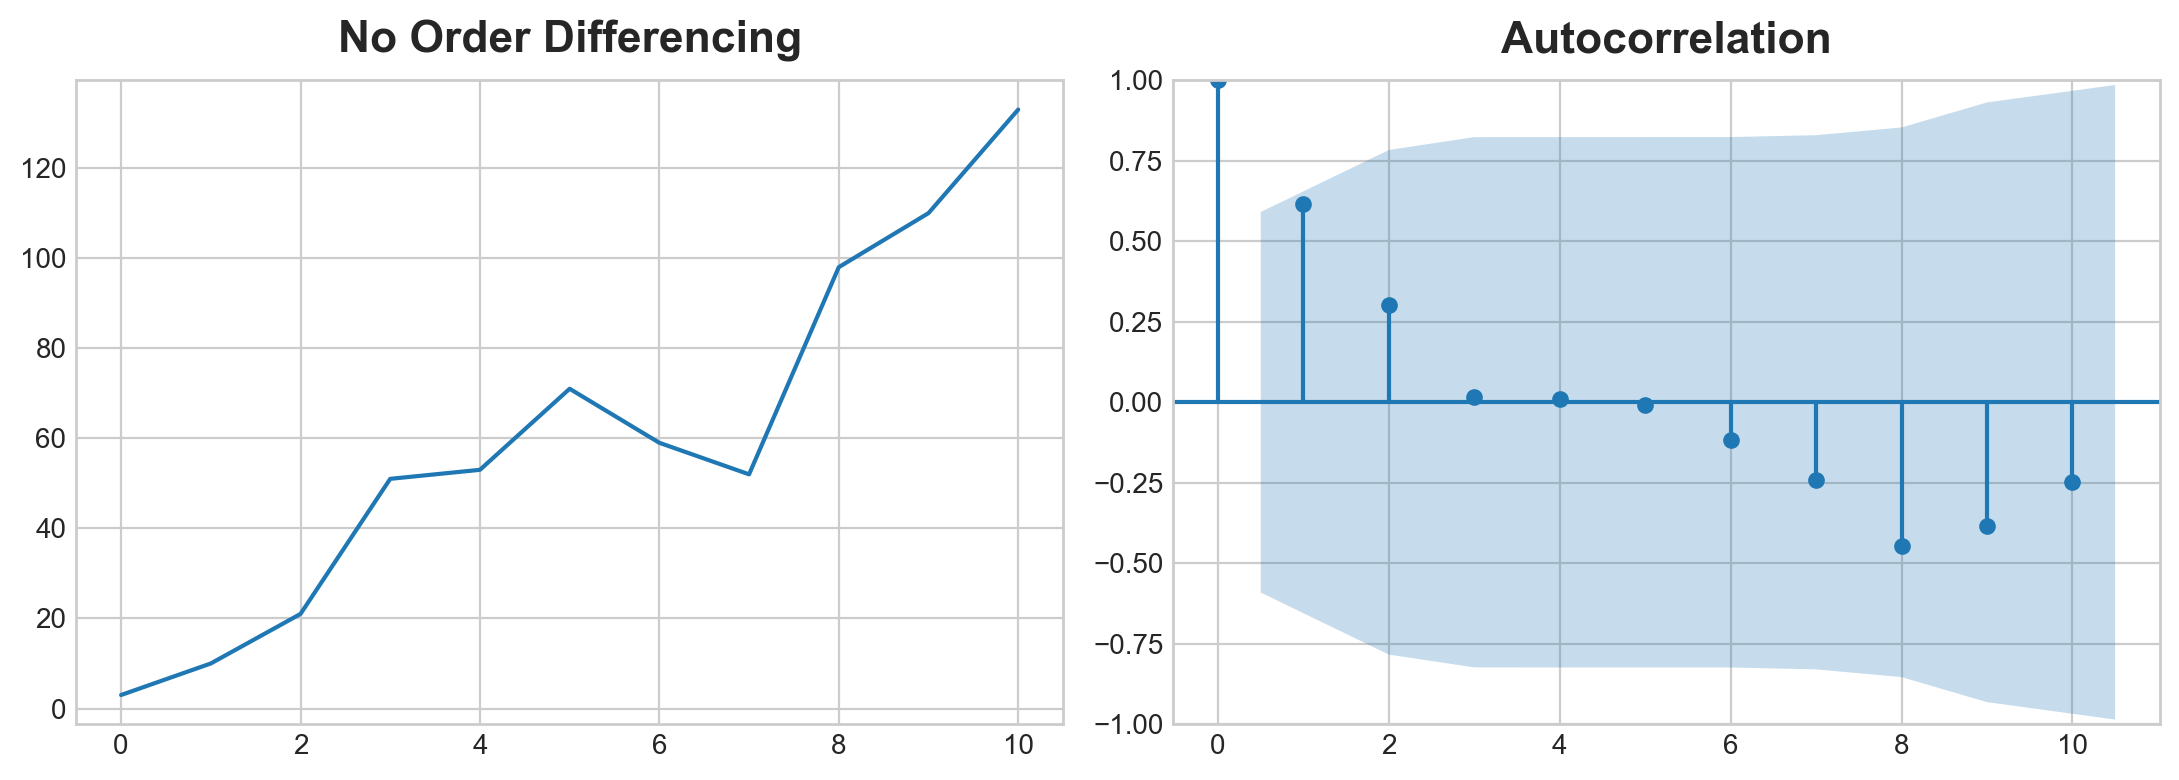

In [206]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("No Order Differencing")
ax1.plot(ev["count"])

ax2 = f.add_subplot(122)
plot_acf(ev["count"], ax = ax2)
plt.show()

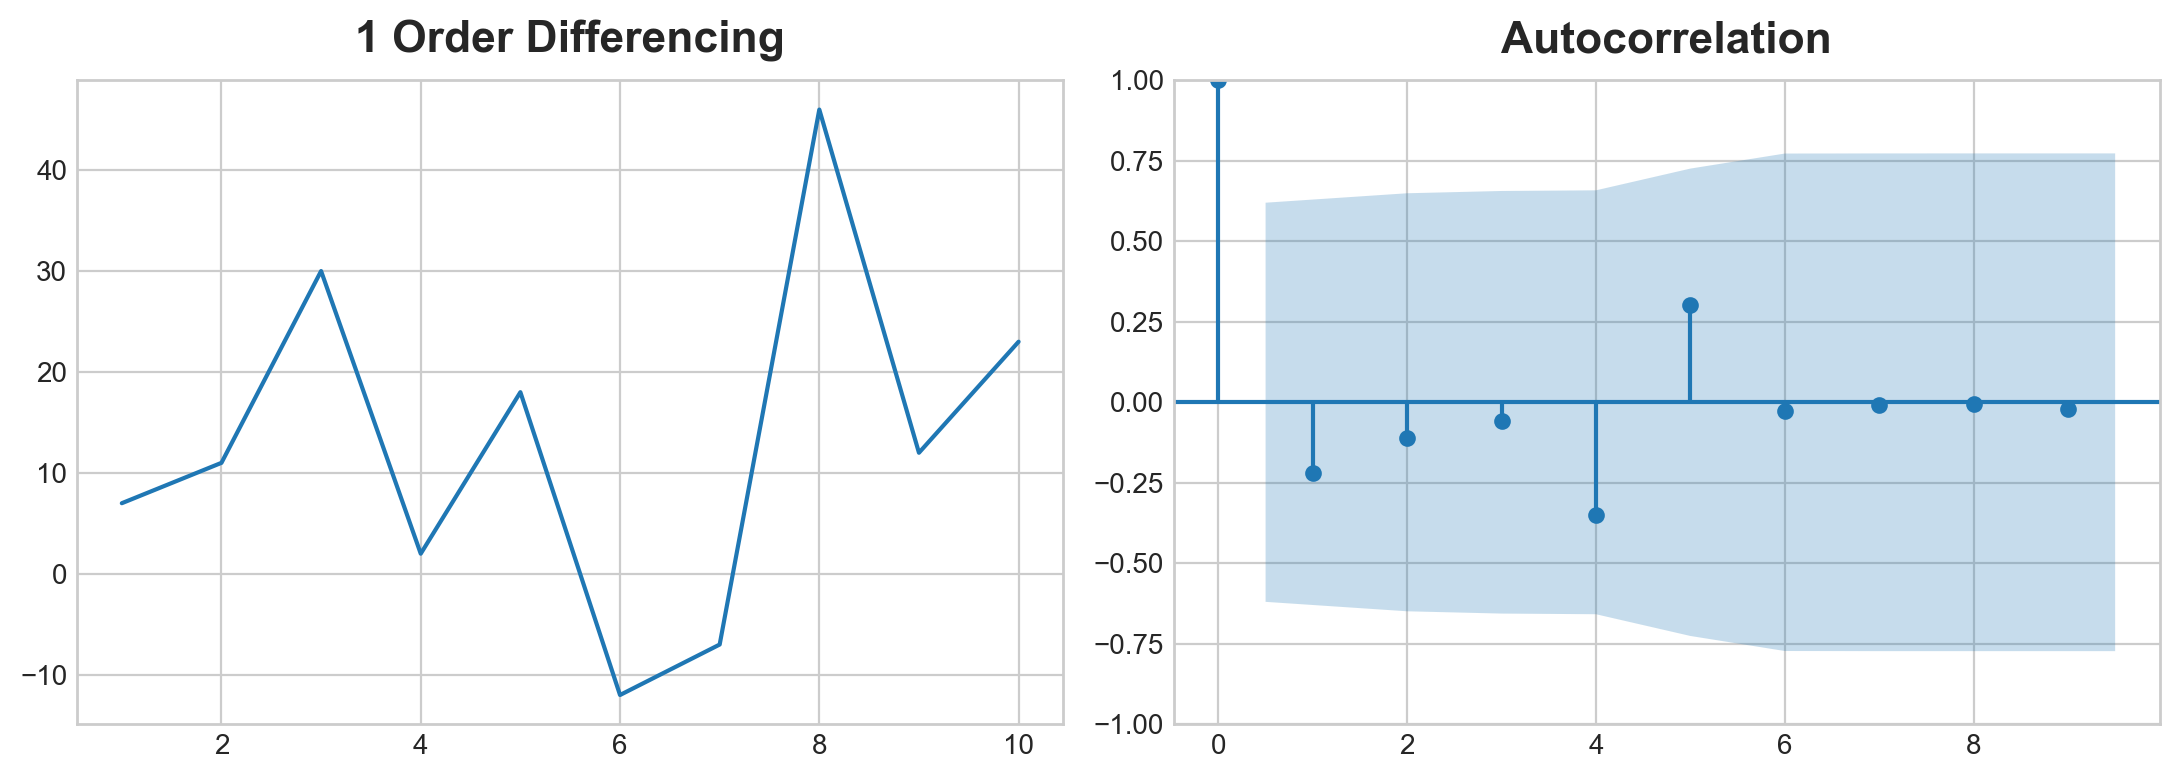

In [208]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("1 Order Differencing")
ax1.plot(ev["count"].diff().dropna())

ax2 = f.add_subplot(122)
plot_acf(ev["count"].diff().dropna(), ax = ax2)
plt.show()

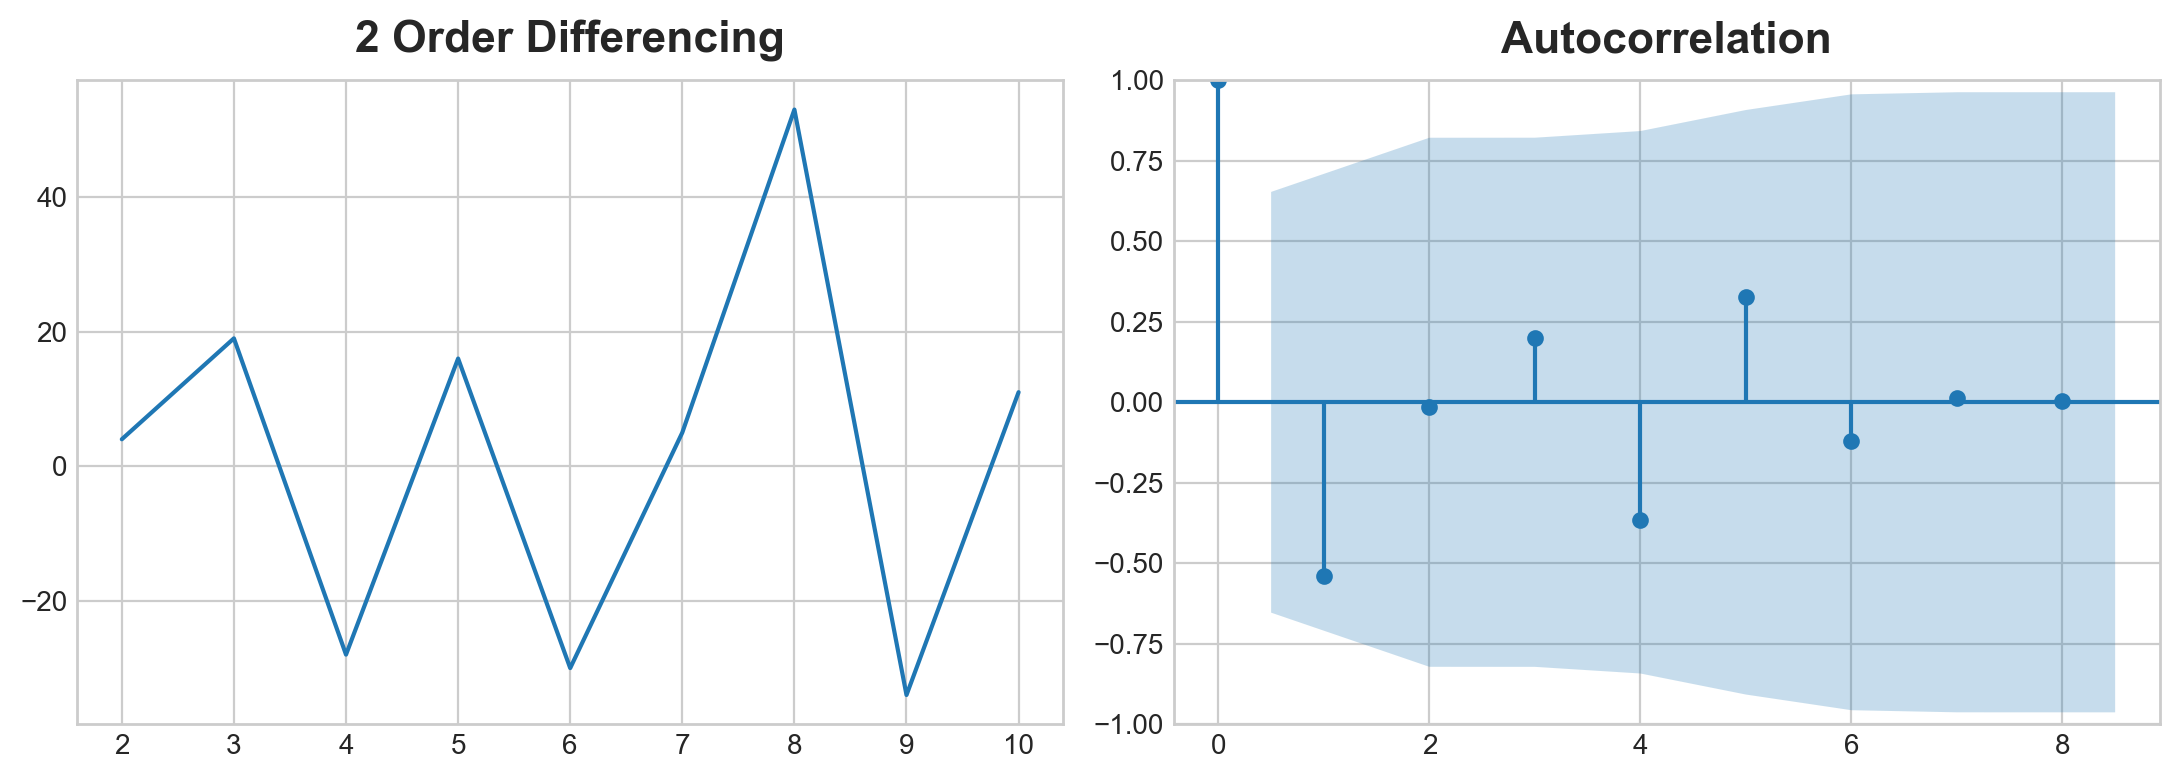

In [209]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("2 Order Differencing")
ax1.plot(ev["count"].diff().diff().dropna())

ax2 = f.add_subplot(122)
plot_acf(ev["count"].diff().diff().dropna(), ax = ax2)
plt.show()

In [210]:
check_stationarity(ev["count"])

ADF Statistic: -0.111300
p-value: 0.948301
Critical Values:
	1%: -4.332
	5%: -3.233
	10%: -2.749
Non-stationary


In [211]:
check_stationarity(ev["count"].diff().dropna())

ADF Statistic: -3.098058
p-value: 0.026697
Critical Values:
	1%: -5.354
	5%: -3.646
	10%: -2.901
Non-stationary


In [212]:
check_stationarity(ev["count"].diff().diff().dropna())

ADF Statistic: -4.485415
p-value: 0.000209
Critical Values:
	1%: -4.665
	5%: -3.367
	10%: -2.803
Stationary


In [213]:
df_test = ev[[ 'year','count']].loc[9:]
df = ev[[ 'year','count']].loc[:8]
df_test

year  count
9   2020    110
10  2021    133

In [214]:
arima_model = ARIMA(df["count"], order=(1,2,1))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                    9
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 -31.575
Date:                Wed, 01 Feb 2023   AIC                             69.150
Time:                        13:15:26   BIC                             68.987
Sample:                             0   HQIC                            67.144
                                  - 9                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2075      1.096     -0.189      0.850      -2.355       1.940
ma.L1         -0.9993    413.793     -0.002      0.998    -812.018     810.020
sigma2       341.4971   1.41e+05      0.002      0.9

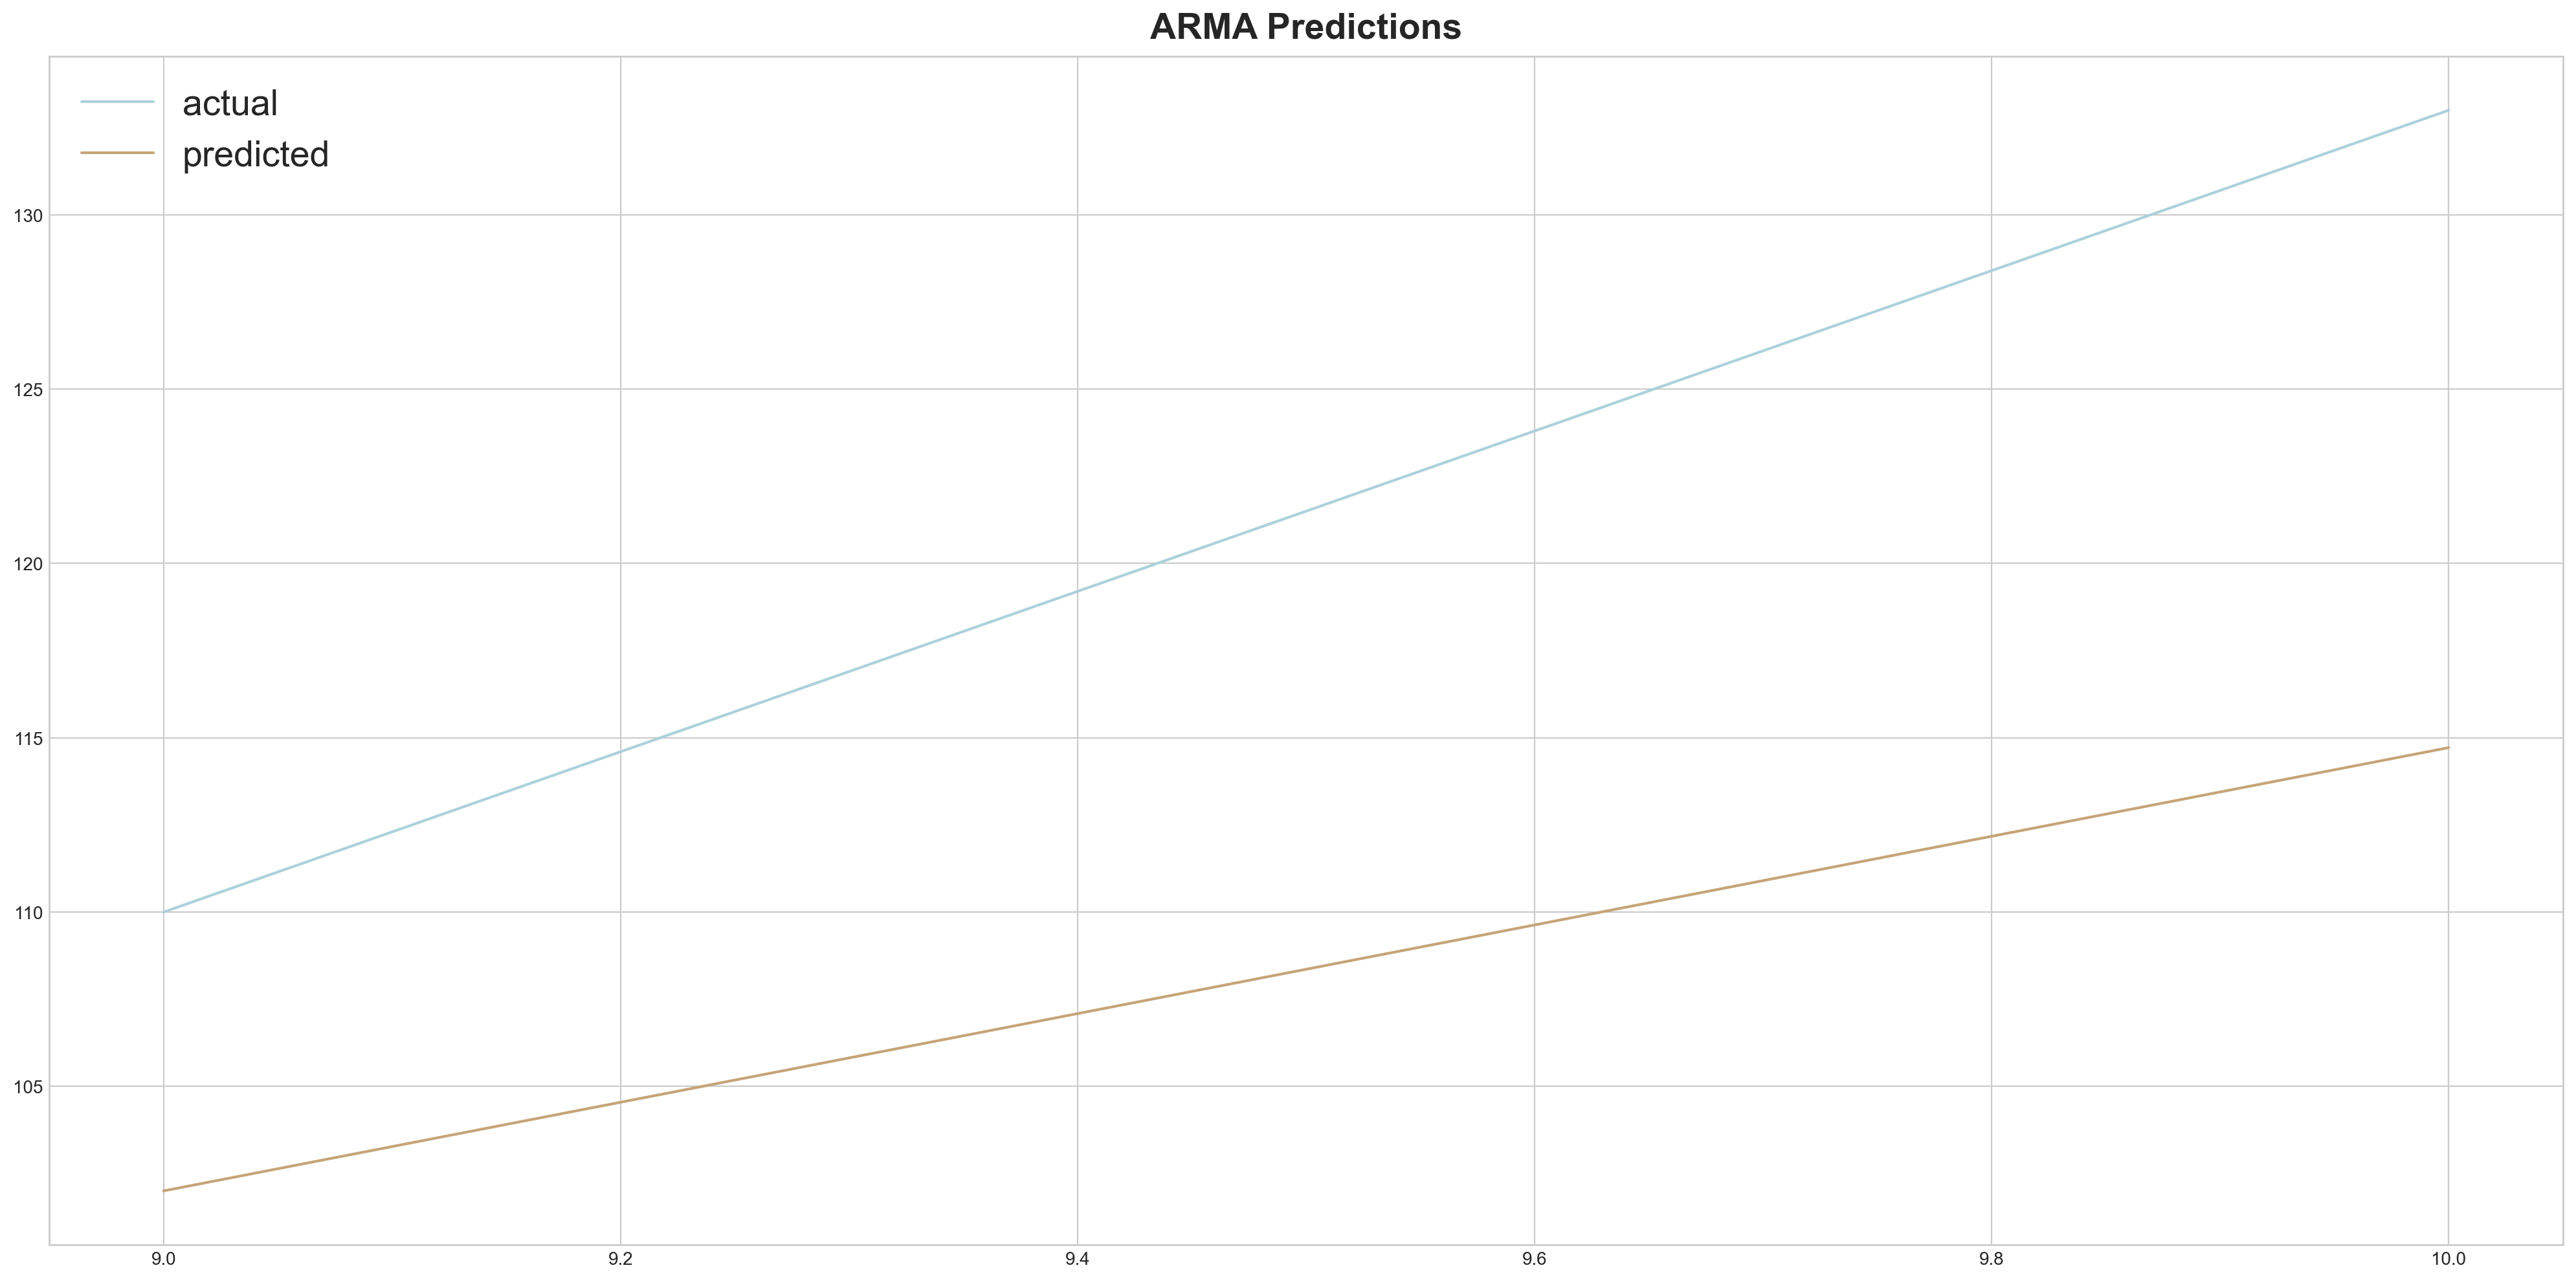

In [215]:
# generate predictions
df_pred = model.predict(start=9, end=10)
# plot actual vs. predicted
fig = plt.figure(figsize=(20, 10))
plt.title('ARMA Predictions', fontsize=20)
plt.plot(df_test['count'], label='actual', color='#ABD1DC')
plt.plot(df_pred, label='predicted', color='#C6A477')
plt.legend(fontsize =20, loc='upper left')

In [216]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  count   No. Observations:                    9
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 -31.575
Date:                Wed, 01 Feb 2023   AIC                             69.150
Time:                        13:16:07   BIC                             68.987
Sample:                             0   HQIC                            67.144
                                  - 9                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2075      1.096     -0.189      0.850      -2.355       1.940
ma.L1         -0.9993    413.793     -0.002      0.998    -812.018     810.020
sigma2       341.4971   1.41e+05      0.002      0.998   -2.77e+05    2.77e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 0.45
Prob(Q):                              0.61   Prob(JB):                         0.80
Heteroskedasticity (H):               5.14   Skew:                             0.41
Prob(H) (two-sided):                  0.33   Kurtosis:                         2.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Recursive multi-step forecasting

In [217]:
ev

year  count
0   2011      3
1   2012     10
2   2013     21
3   2014     51
4   2015     53
5   2016     71
6   2017     59
7   2018     52
8   2019     98
9   2020    110
10  2021    133

In [218]:
ev_cp = ev.copy()

In [220]:
ev_cp.rename(columns={"count": "y"}, inplace=True)
ev_cp

year    y
0   2011    3
1   2012   10
2   2013   21
3   2014   51
4   2015   53
5   2016   71
6   2017   59
7   2018   52
8   2019   98
9   2020  110
10  2021  133

In [221]:
ev_cp = ev_cp.set_index("year")
ev_cp

y
year     
2011    3
2012   10
2013   21
2014   51
2015   53
2016   71
2017   59
2018   52
2019   98
2020  110
2021  133

In [222]:
ev_cp = ev_cp['y']

In [223]:
steps = 2
data_train = ev_cp[:-steps]
data_test  = ev_cp[-steps:]

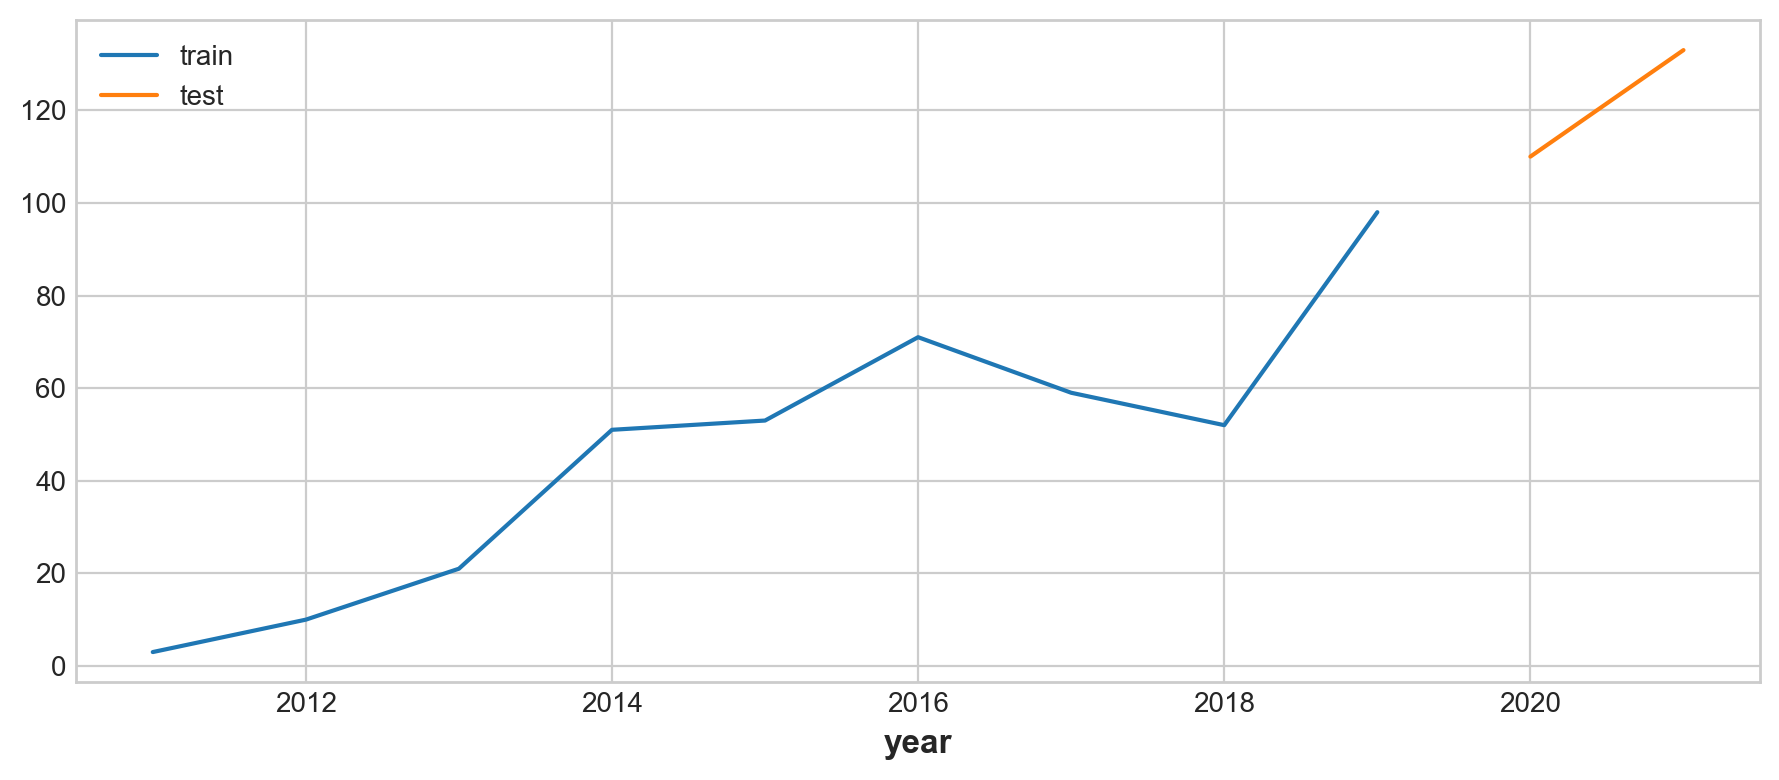

In [224]:
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();

In [225]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 8
             )

forecaster.fit(y=data_train)
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: None 
Transformer for exog: None 
Window size: 8 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 8] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-02-01 13:21:07 
Last fit date: 2023-02-01 13:21:07 
Skforecast version: 0.6.0 
Python version: 3.9.16 

In [226]:
predictions = forecaster.predict(steps=2)
predictions.head()

8    98.0
9    98.0
Name: pred, dtype: float64

In [227]:
predictions.index = [2020,2021]

In [228]:
ahead_predictions = forecaster.predict(steps=7)
ahead_predictions

8     98.0
9     98.0
10    98.0
11    98.0
12    98.0
13    98.0
14    98.0
Name: pred, dtype: float64

In [229]:
ahead_predictions.index = [2020,2021,2022,2023,2024,2025,2026]

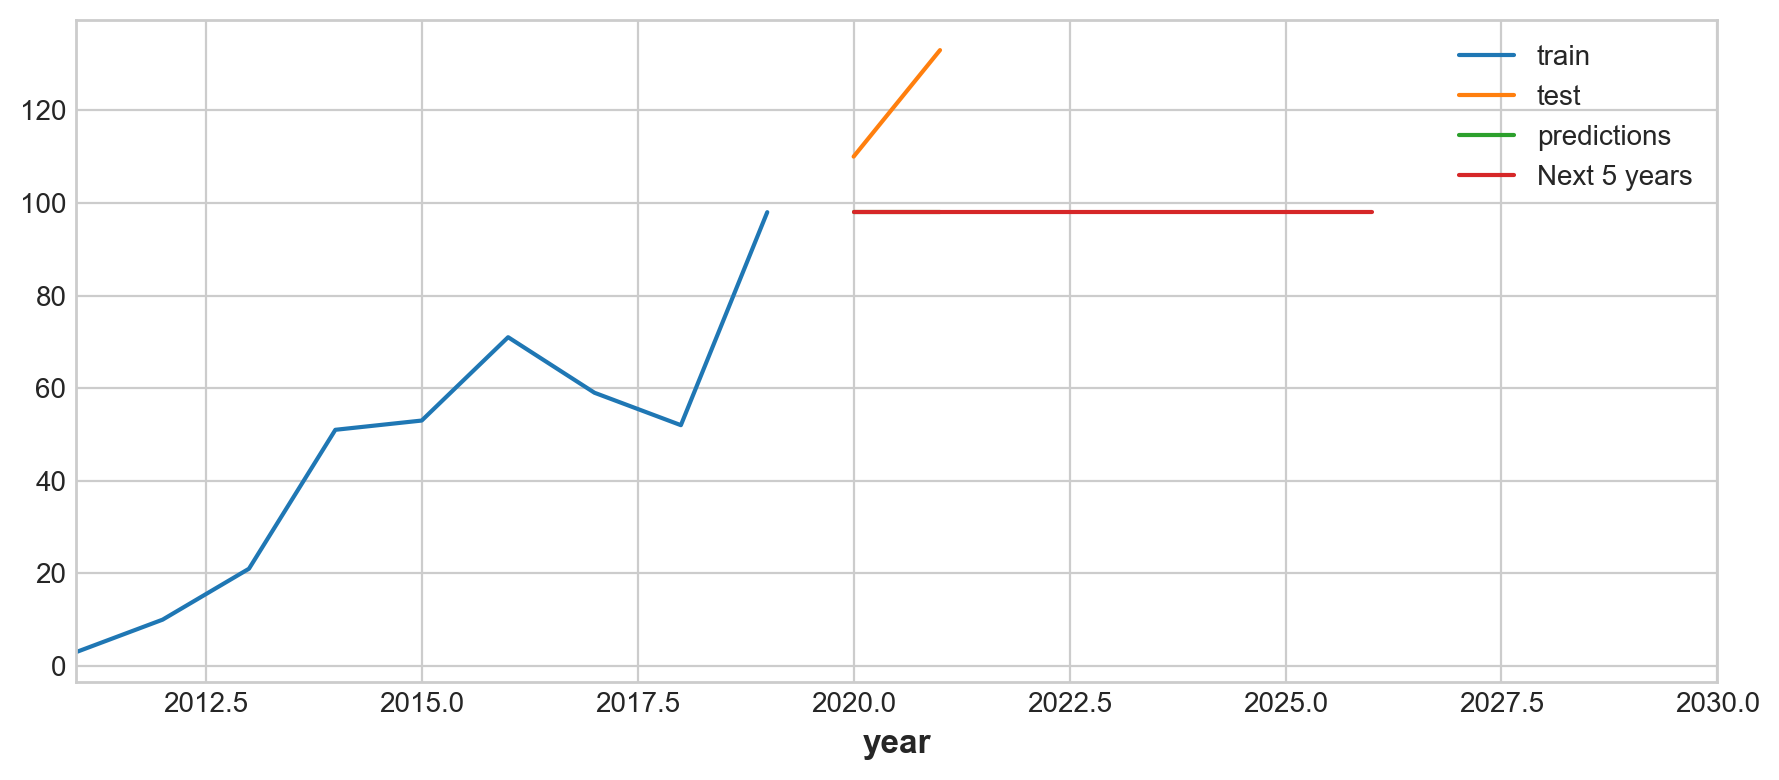

In [230]:
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train', xlim = (2011,2030))
data_test.plot(ax=ax, label='test', xlim = (2011,2030))
predictions.plot(ax=ax, label='predictions')
ahead_predictions.plot(ax=ax, label='Next 5 years')
ax.legend();

In [63]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) or (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [53]:
check_stationarity(ev["count"])

ADF Statistic: 1.288994
p-value: 0.996547
Critical Values:
	1%: -4.665
	5%: -3.367
	10%: -2.803
Non-stationary


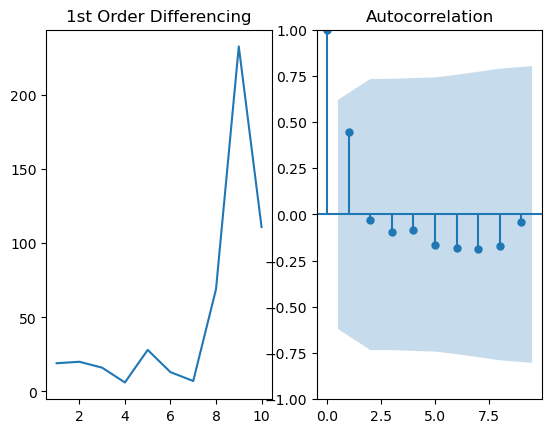

In [54]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("1st Order Differencing")
ax1.plot(ev["count"].diff())

ax2 = f.add_subplot(122)
plot_acf(ev["count"].diff().dropna(), ax = ax2)
plt.show()

In [64]:
check_stationarity(ev["count"].diff().diff().dropna())

ADF Statistic: -3.186139
p-value: 0.020801
Critical Values:
	1%: -4.939
	5%: -3.478
	10%: -2.844
Stationary


c:\Users\harri\anaconda3\envs\dataScience\lib\site-packages\matplotlib\axes\_base.py:2539: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


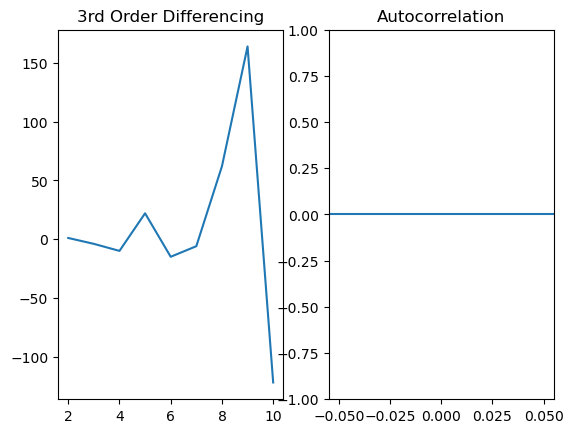

In [65]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("3rd Order Differencing")
ax1.plot(ev["count"].diff().diff())

ax2 = f.add_subplot(122)
plot_acf(ev["count"].diff().diff(), ax = ax2)
plt.show()

All EV cars are automatic, not manual. All EVs are automatic. EVs are power-efficient throughout their revs, unlike fuel engines which have a narrow rev band in which they can deliver maximum performance. EVs need only one gear.(based on https://www.rivervaleleasing.co.uk/guides/electric-vehicle-leasing/are-electric-cars-automatic-or-manual#:~:text=reach%20maximum%20torque.-,Are%20electric%20cars%20automatic%20or%20manual%3F,EVs%20need%20only%20one%20gear.)

However, there is a few companies started to invent EV cars with manual transmission and introduced it around 2022 and it is still new!! (based on https://www.motorbiscuit.com/electric-vehicles-manual-transmissions/ and https://robbreport.com/motors/cars/manual-transmission-electric-vehicles-future-1234774864/)

In [8]:
gear_data = dict(data["gear"].value_counts())
gear_data

{'Manual': 30309, 'Automatic': 15706, 'Semi-automatic': 56}

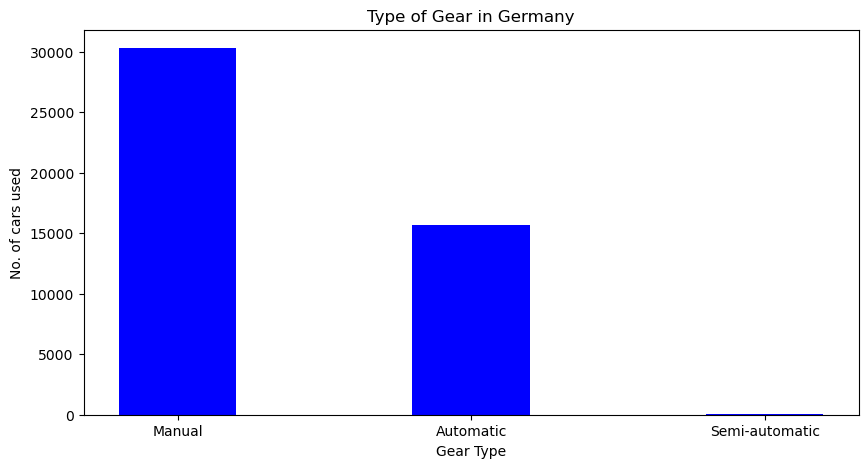

In [10]:
cat = list(gear_data.keys())
freq = list(gear_data.values())
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(cat, freq,color ='blue',
        width = 0.4, label = list(map(str,gear_data.values())))
 
plt.xlabel("Gear Type")
plt.ylabel("No. of cars used")
plt.title("Type of Gear in Germany")
plt.show()

Based on the bar chart, cars with manual transmission are two times bigger than cars with automatics and it is less amount of cars with semi-automatic.

In [61]:
#check data with manual gear type
data.query('gear =="Manual"')


mileage        make   model               fuel    gear       offerType  \
0       235000         BMW     316             Diesel  Manual            Used   
1        92800  Volkswagen    Golf           Gasoline  Manual            Used   
2       149300        SEAT    Exeo           Gasoline  Manual            Used   
3        96200     Renault  Megane           Gasoline  Manual            Used   
4       156000     Peugeot     308           Gasoline  Manual            Used   
...        ...         ...     ...                ...     ...             ...   
46066       99        Fiat     500  Electric/Gasoline  Manual  Pre-registered   
46067       99        Fiat     500  Electric/Gasoline  Manual  Pre-registered   
46068       99        Fiat     500  Electric/Gasoline  Manual  Pre-registered   
46069       99        Fiat     500  Electric/Gasoline  Manual  Pre-registered   
46070       99        Fiat     500  Electric/Gasoline  Manual  Pre-registered   

       price     hp  year  
0       6800  116.0  2011  
1       6877  122.0  2011  
2       6900  160.0  2011  
3       6950  110.0  2011  
4       6950  156.0  2011  
...      ...    ...   ...  
46066  12990   71.0  2021  
46067  12990   71.0  2021  
46068  12990   71.0  2021  
46069  12990   71.0  2021  
46070  12990   71.0  2021  

[30309 rows x 9 columns]

In [69]:
data["price"].min()

1100

In [62]:
data.query('gear =="Manual"')["fuel"].value_counts()

Gasoline             21804
Diesel                7922
Electric/Gasoline      301
LPG                    109
CNG                     95
Others                  37
-/- (Fuel)              16
Electric                16
Electric/Diesel          7
Ethanol                  2
Name: fuel, dtype: int64

Impossible! Records with manual gear should not have electric fuel.  

In [63]:
data.query('gear =="Manual" & fuel =="Electric/Gasoline"')

mileage  make   model               fuel    gear       offerType  \
195         15  Fiat   Panda  Electric/Gasoline  Manual  Pre-registered   
197         15  Fiat   Panda  Electric/Gasoline  Manual  Pre-registered   
198         15  Fiat   Panda  Electric/Gasoline  Manual  Pre-registered   
394       9990  Ford  Fiesta  Electric/Gasoline  Manual  Employee's car   
395       6315  Ford  Fiesta  Electric/Gasoline  Manual  Employee's car   
...        ...   ...     ...                ...     ...             ...   
46066       99  Fiat     500  Electric/Gasoline  Manual  Pre-registered   
46067       99  Fiat     500  Electric/Gasoline  Manual  Pre-registered   
46068       99  Fiat     500  Electric/Gasoline  Manual  Pre-registered   
46069       99  Fiat     500  Electric/Gasoline  Manual  Pre-registered   
46070       99  Fiat     500  Electric/Gasoline  Manual  Pre-registered   

       price     hp  year  
195    10680   69.0  2021  
197    10980   69.0  2021  
198    10980   69.0  2021  
394    15970  125.0  2020  
395    16450  125.0  2020  
...      ...    ...   ...  
46066  12990   71.0  2021  
46067  12990   71.0  2021  
46068  12990   71.0  2021  
46069  12990   71.0  2021  
46070  12990   71.0  2021  

[301 rows x 9 columns]

In [66]:
data.query('gear =="Manual" & fuel =="Electric/Gasoline" & make =="Fiat"')

mileage  make  model               fuel    gear       offerType  price  \
195         15  Fiat  Panda  Electric/Gasoline  Manual  Pre-registered  10680   
197         15  Fiat  Panda  Electric/Gasoline  Manual  Pre-registered  10980   
198         15  Fiat  Panda  Electric/Gasoline  Manual  Pre-registered  10980   
999         10  Fiat   500C  Electric/Gasoline  Manual  Pre-registered  15990   
1000        10  Fiat   500C  Electric/Gasoline  Manual  Pre-registered  15990   
...        ...   ...    ...                ...     ...             ...    ...   
46066       99  Fiat    500  Electric/Gasoline  Manual  Pre-registered  12990   
46067       99  Fiat    500  Electric/Gasoline  Manual  Pre-registered  12990   
46068       99  Fiat    500  Electric/Gasoline  Manual  Pre-registered  12990   
46069       99  Fiat    500  Electric/Gasoline  Manual  Pre-registered  12990   
46070       99  Fiat    500  Electric/Gasoline  Manual  Pre-registered  12990   

         hp  year  
195    69.0  2021  
197    69.0  2021  
198    69.0  2021  
999    69.0  2021  
1000   69.0  2021  
...     ...   ...  
46066  71.0  2021  
46067  71.0  2021  
46068  71.0  2021  
46069  71.0  2021  
46070  71.0  2021  

[164 rows x 9 columns]

In [70]:
data.query('gear =="Manual" & fuel =="Electric/Gasoline" & make =="Fiat"')["offerType"].value_counts()

Pre-registered    134
Demonstration      23
Used                7
Name: offerType, dtype: int64

In [ ]:
data.query('gear =="Manual" & fuel =="Electric/Gasoline" & make =="Fiat"')["model"].value_counts()

In [60]:
#dfObj[(dfObj['Sale'] > 30) & (dfObj['Sale'] < 33) ]
temp2 = temp1.query('make=="Fiat" & model == "500"')
temp2

mileage  make model               fuel    gear       offerType  price  \
1645        10  Fiat   500  Electric/Gasoline  Manual  Pre-registered  11488   
1836        15  Fiat   500  Electric/Gasoline  Manual  Pre-registered  12780   
2647      1111  Fiat   500  Electric/Gasoline  Manual  Pre-registered  13090   
2648      1111  Fiat   500  Electric/Gasoline  Manual  Pre-registered  13090   
2649      1111  Fiat   500  Electric/Gasoline  Manual  Pre-registered  13090   
...        ...   ...   ...                ...     ...             ...    ...   
46066       99  Fiat   500  Electric/Gasoline  Manual  Pre-registered  12990   
46067       99  Fiat   500  Electric/Gasoline  Manual  Pre-registered  12990   
46068       99  Fiat   500  Electric/Gasoline  Manual  Pre-registered  12990   
46069       99  Fiat   500  Electric/Gasoline  Manual  Pre-registered  12990   
46070       99  Fiat   500  Electric/Gasoline  Manual  Pre-registered  12990   

         hp  year  
1645   69.0  2021  
1836   69.0  2021  
2647   69.0  2020  
2648   69.0  2020  
2649   69.0  2020  
...     ...   ...  
46066  71.0  2021  
46067  71.0  2021  
46068  71.0  2021  
46069  71.0  2021  
46070  71.0  2021  

[120 rows x 9 columns]

In [44]:
manual_gear_data[manual_gear_data["fuel"]=="Electric/Gasoline"]["make"].value_counts()

Fiat          164
Ford           69
Suzuki         27
Hyundai        21
Mazda          14
Honda           4
Toyota          1
Volkswagen      1
Name: make, dtype: int64

In [30]:
fuel_feat = dict(data["fuel"].value_counts())
fuel_feat

{'Gasoline': 28720,
 'Diesel': 15178,
 'Electric/Gasoline': 1146,
 'Electric': 661,
 'LPG': 125,
 'CNG': 116,
 'Electric/Diesel': 53,
 'Others': 47,
 '-/- (Fuel)': 22,
 'Ethanol': 2,
 'Hydrogen': 1}

In [31]:
len(fuel_feat)

11

ICE - Gasoline, Diesel, LPG, CNG, Ethanol, Hydrogen, -/- (Fuel), 
EV - Electric/Gasoline, Electric, Electric/Diesel

In [33]:
temp_data = data[data["fuel"]=="Electric/Gasoline"]
temp_data

mileage    make  model               fuel       gear       offerType  \
5       147000  Toyota  Auris  Electric/Gasoline  Automatic            Used   
63       84600  Toyota  Yaris  Electric/Gasoline  Automatic            Used   
175      23490    Audi     A6  Electric/Gasoline  Automatic            Used   
176      19000    Audi     Q5  Electric/Gasoline  Automatic   Demonstration   
184        999    Audi     A7  Electric/Gasoline  Automatic            Used   
...        ...     ...    ...                ...        ...             ...   
46066       99    Fiat    500  Electric/Gasoline     Manual  Pre-registered   
46067       99    Fiat    500  Electric/Gasoline     Manual  Pre-registered   
46068       99    Fiat    500  Electric/Gasoline     Manual  Pre-registered   
46069       99    Fiat    500  Electric/Gasoline     Manual  Pre-registered   
46070       99    Fiat    500  Electric/Gasoline     Manual  Pre-registered   

       price     hp  year  
5       6950   99.0  2011  
63      8990  143.0  2014  
175    59440  367.0  2020  
176    59850  367.0  2020  
184    66890  367.0  2020  
...      ...    ...   ...  
46066  12990   71.0  2021  
46067  12990   71.0  2021  
46068  12990   71.0  2021  
46069  12990   71.0  2021  
46070  12990   71.0  2021  

[1146 rows x 9 columns]

In [34]:
temp_data["gear"].value_counts()

Automatic    845
Manual       301
Name: gear, dtype: int64

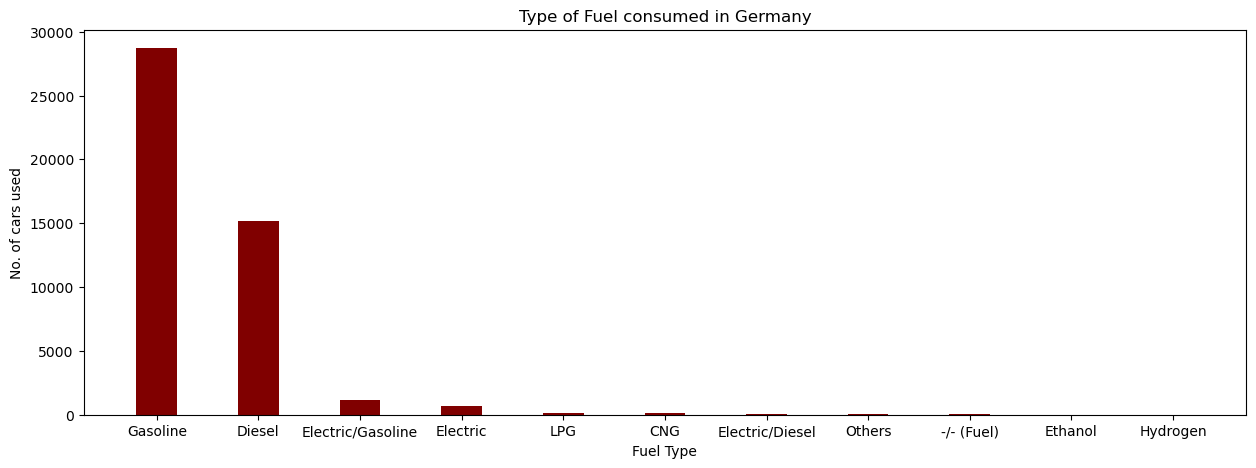

In [37]:
cat = list(fuel_feat.keys())
freq = list(fuel_feat.values())
fig = plt.figure(figsize = (15, 5))
 
# creating the bar plot
plt.bar(cat, freq,color ='maroon',
        width = 0.4, label = list(map(str,fuel_feat.values())))
 
plt.xlabel("Fuel Type")
plt.ylabel("No. of cars used")
plt.title("Type of Fuel consumed in Germany")
plt.show()

In [15]:
data["offerType"].value_counts()

Used              39822
Pre-registered     2768
Demonstration      2351
Employee's car     1117
New                  13
Name: offerType, dtype: int64

In [14]:
data["gear"].value_counts()

Manual            30309
Automatic         15706
Semi-automatic       56
Name: gear, dtype: int64